In [ ]:
# Load data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, accuracy_score, f1_score,
                           precision_score, recall_score, confusion_matrix)
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style='darkgrid')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import scipy.stats as stats

# Model Loader

The `ModelLoader` class is a centralized utility for **loading pre-trained machine learning models** and their **corresponding test datasets** for the **CICIDS2017** and **CICIDS2018** intrusion detection datasets.

* It stores the file paths in a consistent way using a base path.
* It loads different model types (Random Forest, Decision Tree, KNN, Naive Bayes, Logistic Regression, LightGBM) for both datasets.
* It also loads the saved test feature sets and labels for each year.
* This ensures that all models and data are easily accessible in one place, avoiding repetitive code and making the evaluation pipeline cleaner.


In [ ]:
class ModelLoader:
    """Centralized model and data loading"""

    def __init__(self, base_path):
        self.base_path = base_path
        self.models_2017 = {}
        self.models_2018 = {}

    def load_models(self):
        """Load all pre-trained models"""
        model_types = ['random_forest', 'decision_tree', 'knn', 'nb', 'lr', 'lgb']

        try:
            for model_type in model_types:
                # Load 2017 models (note the space after "Capstone ")
                path_2017 = f'{self.base_path} /CICIDS2017/{model_type}_model_2017.joblib'
                self.models_2017[model_type] = joblib.load(path_2017)

                # Load 2018 models
                path_2018 = f'{self.base_path} /CICIDS2018_kaggle/{model_type}_model_2018.joblib'
                self.models_2018[model_type] = joblib.load(path_2018)

            print("✅ All models loaded successfully")
            return True

        except FileNotFoundError as e:
            print(f"❌ Error loading models: {e}")
            return False

    def load_test_data(self):
        """Load test datasets"""
        try:
            # Load 2017 test data (note the space after "Capstone ")
            X_test2017 = pd.read_csv(f'{self.base_path} /CICIDS2017/test_train_split/X_test2017.csv')
            y_test2017 = pd.read_csv(f'{self.base_path} /CICIDS2017/test_train_split/y_test2017.csv').squeeze()

            # Load 2018 test data
            X_test2018 = pd.read_csv(f'{self.base_path} /CICIDS2018_kaggle/test_train_split/X_test2018.csv')
            y_test2018 = pd.read_csv(f'{self.base_path} /CICIDS2018_kaggle/test_train_split/y_test2018.csv').squeeze()

            print("✅ Test data loaded successfully")
            return X_test2017, y_test2017, X_test2018, y_test2018

        except FileNotFoundError as e:
            print(f"❌ Error loading test data: {e}")
            return None, None, None, None


# Ensemble Predictor

The `EnsemblePredictor` class combines the predictions of **two trained models** to produce a single, more reliable final prediction.
It does this by:

* Creating a **unified label space** that includes all possible classes from both models.
* Aligning each model's predicted probabilities to this common label space.
* Combining the probabilities using a chosen method (**average**, **weighted average**, or **maximum voting**) to get the final prediction.
* Returning both the predicted labels and their confidence scores.

This approach helps improve prediction accuracy by leveraging the strengths of multiple models.


In [ ]:
class EnsemblePredictor:
    """Improved ensemble prediction with better error handling"""

    def __init__(self):
        self.full_label_space = None # stores all possible output labels

    def _setup_label_space(self, model1, model2):
        """Create unified label space from both models"""
        self.full_label_space = sorted(list(set(model1.classes_.tolist() + model2.classes_.tolist())))

    def _align_probabilities(self, model_proba, model_classes):
        """Align model probabilities to full label space"""
        aligned = np.zeros((model_proba.shape[0], len(self.full_label_space))) # blank table for all possible labels
        # Fills it with the probabilities from the current model, placing each value in the right column based on the full label space.
        for i, label in enumerate(model_classes):
            if label in self.full_label_space:
                idx = self.full_label_space.index(label)
                aligned[:, idx] = model_proba[:, i]
        return aligned

    def predict_ensemble(self, X_input, model1, model2, method='average'):
        """
        Enhanced ensemble prediction with multiple combination methods

        Parameters:
        - X_input: data you want predicitions for
        - model1, model2: Trained models
        - method: 'average', 'weighted', 'max_voting'
        """
        try:
            self._setup_label_space(model1, model2)

            # Get probabilities from both models
            # predict_proba → tells you how sure the model is about each possible class
            proba1 = model1.predict_proba(X_input)
            proba2 = model2.predict_proba(X_input)

            # Align probabilities to the unified label space
            aligned1 = self._align_probabilities(proba1, model1.classes_)
            aligned2 = self._align_probabilities(proba2, model2.classes_)

            # Combine based on method
            if method == 'average': # Take the mean of the two models' probabilities.
                combined = (aligned1 + aligned2) / 2
            elif method == 'weighted': # Give one model more importance
                # You can adjust weights based on model performance
                w1, w2 = 0.6, 0.4
                combined = (w1 * aligned1 + w2 * aligned2)
            elif method == 'max_voting': # Pick the highest probability from either model for each class.
                combined = np.maximum(aligned1, aligned2)
            else:
                combined = (aligned1 + aligned2) / 2

            # Get final predictions
            predictions = [self.full_label_space[i] for i in np.argmax(combined, axis=1)]
            confidence_scores = np.max(combined, axis=1)

            return predictions, confidence_scores

        except Exception as e:
            print(f"❌ Error in ensemble prediction: {e}")
            return None, None

# What makes an Ensemble Adaptive?
A simple ensemble just averages or votes between the models.

An adaptive ensemble goes further:

- It adjusts how much it trusts each model for each prediction.

- It adapts dynamically depending on which model seems more confident or reliable on the current example.

For example:

- For one image, Model 1 might be more confident → we trust it more.

- For another image, Model 2 might be better → we give it more weight.

So the ensemble adapts, rather than treating both models equally all the time.

-------

# Adaptive Ensemble Predictor

The `AdaptiveEnsemblePredictor` class is an advanced framework for combining predictions from **two different machine learning models** using **dynamic, confidence-based weighting** instead of a simple fixed average.

🔑 **Key features:**

* It first creates a **unified label space**, so both models' probability outputs are aligned correctly even if they have different sets of predicted classes.
* It calculates multiple **confidence metrics** for each prediction, such as maximum probability, entropy, margin between top classes, and Gini index.
* Based on these confidence measures, it adaptively adjusts how much weight to give to each model for each input sample.
* It supports several weighting methods:

  * **Simple average:** equal weight to both models.
  * **Confidence adaptive:** adjusts weights according to how confident each model is.
  * **Meta-learner:** trains a separate model to learn the best way to combine predictions.
  * **Hybrid:** combines both adaptive rules and meta-learning.
* It keeps track of how the weights are distributed for analysis and tuning.
* It also includes methods to compare different ensemble methods side by side, showing how each weighting strategy affects performance.

✅ **Purpose:**
This makes the ensemble system **smarter**, more **flexible**, and able to handle varying model strengths, aiming for more robust predictions than any single model alone.


In [ ]:
class AdaptiveEnsemblePredictor:
    """Enhanced ensemble prediction with adaptive weighting strategies"""

    def __init__(self):
        self.full_label_space = None
        self.meta_learner = None # A machine learning model that learns how to choose the best weights between Model 1 and Model 2.
        self.confidence_threshold = 0.5 # A cutoff to decide when to trust a model more heavily.
        self.weighting_history = [] # Keeps a record of the weights used in past predictions.

    def _setup_label_space(self, model1, model2):
        """Create unified label space from both models"""
        self.full_label_space = sorted(list(set(model1.classes_.tolist() + model2.classes_.tolist())))

    def _align_probabilities(self, model_proba, model_classes):
        """Align model probabilities to full label space"""
        aligned = np.zeros((model_proba.shape[0], len(self.full_label_space)))
        for i, label in enumerate(model_classes):
            if label in self.full_label_space:
                idx = self.full_label_space.index(label)
                aligned[:, idx] = model_proba[:, i]
        return aligned

    def _calculate_confidence_metrics(self, proba_array):
        """Calculate multiple confidence metrics for probability distributions"""
        # Max probability (highest probability)
        max_conf = np.max(proba_array, axis=1)

        # Entropy-based confidence (lower entropy = higher confidence)(uncertainity)
        entropy = -np.sum(proba_array * np.log(proba_array + 1e-10), axis=1)
        entropy_conf = 1 - (entropy / np.log(len(self.full_label_space)))  # Normalized

        # Margin confidence (difference between top 2 predictions)
        sorted_proba = np.sort(proba_array, axis=1)
        margin_conf = sorted_proba[:, -1] - sorted_proba[:, -2]

        # Gini coefficient based confidence (Measures how “uneven” the probabilities are)(higher gini = more confidence)
        gini_conf = 1 - np.sum(proba_array ** 2, axis=1)
        gini_conf = 1 - gini_conf  # Invert so higher = more confident

        return {
            'max_prob': max_conf,
            'entropy': entropy_conf,
            'margin': margin_conf,
            'gini': gini_conf
        }

    def _confidence_based_weighting(self, conf1, conf2, method='adaptive_ratio'):
        """Calculate adaptive weights based on confidence scores"""

        if method == 'adaptive_ratio':
            # Higher confidence gets higher weight
            # dividde confidences
            total_conf = conf1 + conf2 + 1e-10  # Avoid division by zero
            w1 = conf1 / total_conf
            w2 = conf2 / total_conf

        elif method == 'exponential':
            # Exponential weighting emphasizes high confidence more
            exp_conf1 = np.exp(conf1 * 3)  # Scale factor of 3
            exp_conf2 = np.exp(conf2 * 3)
            total_exp = exp_conf1 + exp_conf2
            w1 = exp_conf1 / total_exp
            w2 = exp_conf2 / total_exp

        elif method == 'threshold_based':
            # If one model is very confident, give it more weight
            w1 = np.where(conf1 > self.confidence_threshold,
                         np.minimum(conf1 * 1.5, 0.9), 0.5)
            w2 = 1 - w1

        elif method == 'softmax':
            # Softmax weighting
            logits = np.column_stack([conf1, conf2])
            softmax_weights = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
            w1 = softmax_weights[:, 0]
            w2 = softmax_weights[:, 1]

        else:  # default to simple ratio
            total_conf = conf1 + conf2 + 1e-10
            w1 = conf1 / total_conf
            w2 = conf2 / total_conf

        return w1, w2

    def _train_meta_learner(self, X_train, y_train, model1, model2):
        """Train a meta-learner to predict optimal weights"""
        print("🧠 Training meta-learner for adaptive weighting...")

        # Get predictions and confidence scores on training data
        proba1 = model1.predict_proba(X_train)
        proba2 = model2.predict_proba(X_train)

        # Align probabilities
        aligned1 = self._align_probabilities(proba1, model1.classes_)
        aligned2 = self._align_probabilities(proba2, model2.classes_)

        # Calculate confidence metrics
        conf_metrics1 = self._calculate_confidence_metrics(aligned1)
        conf_metrics2 = self._calculate_confidence_metrics(aligned2)

        # Create feature matrix for meta-learner
        # Features: [conf1_max, conf1_entropy, conf1_margin, conf2_max, conf2_entropy, conf2_margin,
        #           agreement_score, prediction_diversity]

        # Agreement score (how much models agree)
        # Agreement: Whether both models predicted the same label (1) or not (0).
        pred1 = np.argmax(aligned1, axis=1)
        pred2 = np.argmax(aligned2, axis=1)
        agreement = (pred1 == pred2).astype(float)

        # Prediction diversity (KL divergence between predictions)
        # KL Divergence: Measures how different their full probability distributions are (more disagreement = higher KL).
        kl_div = np.sum(aligned1 * np.log((aligned1 + 1e-10) / (aligned2 + 1e-10)), axis=1)

        meta_features = np.column_stack([
            conf_metrics1['max_prob'],
            conf_metrics1['entropy'],
            conf_metrics1['margin'],
            conf_metrics2['max_prob'],
            conf_metrics2['entropy'],
            conf_metrics2['margin'],
            agreement,
            kl_div
        ])

        # Create target: optimal weight for model 1 (based on which model is more accurate)
        y_true_indices = [self.full_label_space.index(label) for label in y_train]

        # Calculate per-sample accuracy for each model
        acc1 = (pred1 == y_true_indices).astype(float)
        acc2 = (pred2 == y_true_indices).astype(float)

        # Target weight: higher weight for more accurate model
        optimal_weights = np.where(acc1 >= acc2,
                                 np.minimum(acc1 + 0.1, 0.9),  # Boost accurate model (If Model 1 is better (or equal), give it a higher weight)
                                 np.maximum(acc1 - 0.1, 0.1))  # Reduce inaccurate model (If it’s worse, reduce its weight)

        # For regression target (weights), we'll use RandomForestRegressor
        from sklearn.ensemble import RandomForestRegressor
        self.meta_learner = RandomForestRegressor(n_estimators=100, random_state=42)

        self.meta_learner.fit(meta_features, optimal_weights)

        # Evaluate meta-learner
        cv_scores = cross_val_score(self.meta_learner, meta_features, optimal_weights, cv=5)
        print(f"Meta-learner CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

        return meta_features, optimal_weights

    def _predict_with_meta_learner(self, aligned1, aligned2):
        """Use meta-learner to predict optimal weights"""
        # Calculate same features as during training
        conf_metrics1 = self._calculate_confidence_metrics(aligned1)
        conf_metrics2 = self._calculate_confidence_metrics(aligned2)

        pred1 = np.argmax(aligned1, axis=1)
        pred2 = np.argmax(aligned2, axis=1)
        agreement = (pred1 == pred2).astype(float)

        kl_div = np.sum(aligned1 * np.log((aligned1 + 1e-10) / (aligned2 + 1e-10)), axis=1)

        meta_features = np.column_stack([
            conf_metrics1['max_prob'],
            conf_metrics1['entropy'],
            conf_metrics1['margin'],
            conf_metrics2['max_prob'],
            conf_metrics2['entropy'],
            conf_metrics2['margin'],
            agreement,
            kl_div
        ])

        # Predict optimal weights
        w1_predicted = self.meta_learner.predict(meta_features)
        w1_predicted = np.clip(w1_predicted, 0.1, 0.9)  # Ensure reasonable bounds
        w2_predicted = 1 - w1_predicted

        return w1_predicted, w2_predicted

    def predict_ensemble(self, X_input, model1, model2, method='confidence_adaptive',
                        confidence_metric='max_prob', X_train=None, y_train=None):
        """
        Enhanced ensemble prediction with multiple adaptive weighting strategies

        Parameters:
        - X_input: Input features for prediction
        - model1, model2: Trained models
        - method: 'average', 'confidence_adaptive', 'meta_learner', 'hybrid'
        - confidence_metric: 'max_prob', 'entropy', 'margin', 'gini'
        - X_train, y_train: Training data for meta-learner (required for meta_learner method)
        """
        try:
            self._setup_label_space(model1, model2)

            # Get probabilities from both models
            proba1 = model1.predict_proba(X_input)
            proba2 = model2.predict_proba(X_input)

            # Align probabilities
            aligned1 = self._align_probabilities(proba1, model1.classes_)
            aligned2 = self._align_probabilities(proba2, model2.classes_)

            # Calculate confidence metrics
            conf_metrics1 = self._calculate_confidence_metrics(aligned1)
            conf_metrics2 = self._calculate_confidence_metrics(aligned2)

            # Select confidence metric
            conf1 = conf_metrics1[confidence_metric]
            conf2 = conf_metrics2[confidence_metric]

            # Calculate weights based on method
            if method == 'average':
                # Simple average (original method)
                combined = (aligned1 + aligned2) / 2
                weights_used = np.full((len(X_input), 2), 0.5)

            elif method == 'confidence_adaptive':
                # Adaptive weighting based on confidence
                # This reshapes things so weights apply per sample, not globally.
                w1, w2 = self._confidence_based_weighting(conf1, conf2, 'adaptive_ratio')
                combined = (aligned1.T * w1).T + (aligned2.T * w2).T
                weights_used = np.column_stack([w1, w2])

            elif method == 'meta_learner':
                # Use meta-learner to predict optimal weights
                # Instead of using confidence directly, the meta-learner predicts: “For this particular sample, how much weight should model 1 get?”
                if self.meta_learner is None:
                    if X_train is None or y_train is None:
                        raise ValueError("Training data required for meta-learner method")
                    self._train_meta_learner(X_train, y_train, model1, model2)

                w1, w2 = self._predict_with_meta_learner(aligned1, aligned2)
                combined = (aligned1.T * w1).T + (aligned2.T * w2).T
                weights_used = np.column_stack([w1, w2])

            elif method == 'hybrid':
                # Hybrid approach: use meta-learner when available, fallback to confidence
                if self.meta_learner is not None:
                    w1, w2 = self._predict_with_meta_learner(aligned1, aligned2)
                else:
                    w1, w2 = self._confidence_based_weighting(conf1, conf2, 'exponential')
                combined = (aligned1.T * w1).T + (aligned2.T * w2).T
                weights_used = np.column_stack([w1, w2])

            else:
                # Default to simple average
                combined = (aligned1 + aligned2) / 2
                weights_used = np.full((len(X_input), 2), 0.5)

            # Get final predictions
            predictions = [self.full_label_space[i] for i in np.argmax(combined, axis=1)]
            confidence_scores = np.max(combined, axis=1)

            # Store weighting information for analysis
            self.weighting_history.append({
                'method': method,
                'weights': weights_used,
                'confidences': np.column_stack([conf1, conf2]),
                'predictions': predictions
            })

            return predictions, confidence_scores, weights_used

        except Exception as e:
            print(f"❌ Error in adaptive ensemble prediction: {e}")
            return None, None, None

    def analyze_weighting_patterns(self):
        """Analyze how weights are distributed across different methods"""
        if not self.weighting_history:
            print("No weighting history available")
            return

        print("\n🔍 ADAPTIVE WEIGHTING ANALYSIS")
        print("=" * 50)

        for i, history in enumerate(self.weighting_history):
            method = history['method']
            weights = history['weights']

            print(f"\n📊 Method: {method}")
            print(f"Weight Statistics:")
            print(f"  Model 1 - Mean: {np.mean(weights[:, 0]):.4f}, Std: {np.std(weights[:, 0]):.4f}")
            print(f"  Model 2 - Mean: {np.mean(weights[:, 1]):.4f}, Std: {np.std(weights[:, 1]):.4f}")

            # Show distribution of weights
            w1_bins = np.histogram(weights[:, 0], bins=10, range=(0, 1))[0]
            print(f"  Model 1 weight distribution: {w1_bins}")

    def compare_weighting_methods(self, X_test, y_test, model1, model2, X_train=None, y_train=None):
        """Compare different weighting methods on the same test set"""
        print("\n🏁 COMPARING ADAPTIVE WEIGHTING METHODS")
        print("=" * 60)

        methods = ['average', 'confidence_adaptive', 'meta_learner', 'hybrid']
        confidence_metrics = ['max_prob', 'entropy', 'margin']

        results = {}

        for method in methods:
            if method == 'meta_learner' and (X_train is None or y_train is None):
                print(f"⚠️  Skipping {method} - requires training data")
                continue

            for conf_metric in confidence_metrics:
                if method == 'average':
                    # For average method, confidence metric doesn't matter
                    if conf_metric != 'max_prob':
                        continue

                method_name = f"{method}_{conf_metric}" if method != 'average' else method

                try:
                    predictions, confidence_scores, weights = self.predict_ensemble(
                        X_test, model1, model2, method=method,
                        confidence_metric=conf_metric, X_train=X_train, y_train=y_train
                    )

                    if predictions is not None:
                        # Calculate metrics
                        from sklearn.metrics import accuracy_score, f1_score
                        accuracy = accuracy_score(y_test, predictions)
                        f1_macro = f1_score(y_test, predictions, average='macro')
                        f1_weighted = f1_score(y_test, predictions, average='weighted')

                        results[method_name] = {
                            'accuracy': accuracy,
                            'f1_macro': f1_macro,
                            'f1_weighted': f1_weighted,
                            'avg_confidence': np.mean(confidence_scores),
                            'weight_variance': np.var(weights[:, 0])  # Variance in model 1 weights
                        }

                        print(f"✅ {method_name:20} - Acc: {accuracy:.4f}, F1: {f1_macro:.4f}, Conf: {np.mean(confidence_scores):.4f}")

                except Exception as e:
                    print(f"❌ {method_name:20} - Error: {str(e)[:50]}...")

        # Find best performing method
        if results:
            best_method = max(results.items(), key=lambda x: x[1]['accuracy'])
            print(f"\n🏆 Best Method: {best_method[0]} with accuracy {best_method[1]['accuracy']:.4f}")

            # Create comparison DataFrame
            comparison_df = pd.DataFrame(results).T
            comparison_df = comparison_df.sort_values('accuracy', ascending=False)

            print("\n📊 DETAILED COMPARISON:")
            print(comparison_df.round(4))

            return comparison_df

        return None


In [ ]:
class EvaluationMetrics:
    """Comprehensive evaluation metrics calculation"""

    @staticmethod
    def calculate_metrics(y_true, y_pred):
        """Calculate comprehensive metrics"""
        try:
            metrics = {
                'accuracy': accuracy_score(y_true, y_pred),
                'f1_macro': f1_score(y_true, y_pred, average='macro'),
                'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
                'precision_macro': precision_score(y_true, y_pred, average='macro'),
                'recall_macro': recall_score(y_true, y_pred, average='macro'),
                'classification_report': classification_report(y_true, y_pred)
            }
            return metrics
        except Exception as e:
            print(f"❌ Error calculating metrics: {e}")
            return None

    @staticmethod
    def print_evaluation_results(dataset_name, model_name, metrics):
        """Print formatted evaluation results"""
        print(f"\n{'='*50}")
        print(f"📊 {model_name} Ensemble on {dataset_name}")
        print(f"{'='*50}")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"F1-Score (Macro): {metrics['f1_macro']:.4f}")
        print(f"F1-Score (Weighted): {metrics['f1_weighted']:.4f}")
        print(f"Precision (Macro): {metrics['precision_macro']:.4f}")
        print(f"Recall (Macro): {metrics['recall_macro']:.4f}")
        print(f"\nDetailed Classification Report:")
        print(metrics['classification_report'])

In [ ]:
class VisualizationTools:
    """Improved visualization tools"""

    @staticmethod
    def plot_confusion_matrices_comparison(y_true_1, y_pred_1, title_1,
                                         y_true_2, y_pred_2, title_2,
                                         figsize=(20, 8)):
        """Plot side-by-side confusion matrices with better formatting"""

        # Get all unique labels
        labels = sorted(list(set(y_true_1) | set(y_pred_1) | set(y_true_2) | set(y_pred_2)))

        # Calculate confusion matrices
        cm1 = confusion_matrix(y_true_1, y_pred_1, labels=labels)
        cm2 = confusion_matrix(y_true_2, y_pred_2, labels=labels)

        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        # Plot first confusion matrix
        sns.heatmap(pd.DataFrame(cm1, index=labels, columns=labels),
                   annot=True, fmt='d', cmap='Blues', ax=axes[0])
        axes[0].set_title(title_1, fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Predicted Label', fontsize=12)
        axes[0].set_ylabel('True Label', fontsize=12)

        # Plot second confusion matrix
        sns.heatmap(pd.DataFrame(cm2, index=labels, columns=labels),
                   annot=True, fmt='d', cmap='Blues', ax=axes[1])
        axes[1].set_title(title_2, fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Predicted Label', fontsize=12)
        axes[1].set_ylabel('True Label', fontsize=12)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_model_performance_comparison(results_dict):
        """Plot performance comparison across different ensemble methods"""
        models = list(results_dict.keys())
        accuracies = [results_dict[model]['accuracy'] for model in models]

        # Limit to top 15 for readability
        if len(models) > 15:
            top_indices = np.argsort(accuracies)[-15:]
            models = [models[i] for i in top_indices]
            accuracies = [accuracies[i] for i in top_indices]

        plt.figure(figsize=(16, 10))
        bars = plt.bar(range(len(models)), accuracies, color='skyblue', edgecolor='navy')
        plt.title('Top 15 Ensemble Model Performance Comparison', fontsize=16, fontweight='bold')
        plt.xlabel('Model Combinations', fontsize=12)
        plt.ylabel('Average Accuracy', fontsize=12)
        plt.ylim(0, 1)

        # Add value labels on bars
        for i, (bar, acc) in enumerate(zip(bars, accuracies)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

        # Rotate labels for better readability
        plt.xticks(range(len(models)), models, rotation=45, ha='right', fontsize=10)
        plt.tight_layout()
        plt.show()

        # Create a heatmap showing all combinations
        plt.figure(figsize=(12, 10))

        # Extract model types for heatmap
        model_types = ['RF', 'DT', 'KNN', 'NB', 'LR', 'LGB']
        heatmap_data = np.zeros((len(model_types), len(model_types)))

        # Fill heatmap with accuracies
        full_results = list(results_dict.items())
        for model_name, result in full_results:
            if '(' in model_name and '+' in model_name:
                try:
                    model1 = model_name.split('(2017)')[0].strip()
                    model2 = model_name.split('+ ')[1].split('(2018)')[0].strip()

                    if model1 in model_types and model2 in model_types:
                        i = model_types.index(model1)
                        j = model_types.index(model2)
                        heatmap_data[i, j] = result['accuracy']
                except:
                    continue

        # Create heatmap
        sns.heatmap(heatmap_data,
                   xticklabels=[f'{m}(2018)' for m in model_types],
                   yticklabels=[f'{m}(2017)' for m in model_types],
                   annot=True, fmt='.3f', cmap='viridis',
                   cbar_kws={'label': 'Average Accuracy'})

        plt.title('Ensemble Performance Heatmap\n(2017 Models × 2018 Models)',
                 fontsize=14, fontweight='bold')
        plt.xlabel('Second Model (from 2018 dataset)', fontsize=12)
        plt.ylabel('First Model (from 2017 dataset)', fontsize=12)
        plt.tight_layout()
        plt.show()

# Ensemble Experiment Runner

This class manages the entire workflow for testing and comparing ensemble models on the CICIDS2017 and CICIDS2018 intrusion detection datasets. It:

* **Loads** pre-trained models and test data.
* Runs **all combinations** of model pairs to create ensemble predictions.
* Computes performance metrics (**accuracy, F1**), and shows confusion matrices.
* Evaluates each **individual model** to compare with the ensembles.
* Runs **adaptive ensemble methods** (like confidence-based and meta-learning) to test smarter weighting strategies.
* Generates **summary reports** comparing standard vs adaptive ensembles, highlighting best combinations and improvements.

In short, it helps find out which model pairs and weighting strategies work best for robust intrusion detection.


In [ ]:
class EnsembleExperimentRunner:
    """Main class to run ensemble experiments"""

    def __init__(self, base_path):
        self.adaptive_predictor = AdaptiveEnsemblePredictor()
        self.adaptive_results = {}
        self.loader = ModelLoader(base_path)
        self.predictor = EnsemblePredictor()
        self.evaluator = EvaluationMetrics()
        self.visualizer = VisualizationTools()
        self.results = {}
        self.individual_results = {}

    def setup(self):
        """Setup models and data"""
        print("🚀 Setting up ensemble experiments...")

        # Load models
        if not self.loader.load_models():
            return False

        # Load test data
        self.X_test2017, self.y_test2017, self.X_test2018, self.y_test2018 = self.loader.load_test_data()

        if self.X_test2017 is None:
            return False

        print("✅ Setup completed successfully!")
        return True

    def run_single_ensemble_experiment(self, model_name, model1, model2):
        """Run ensemble experiment for a single model combination"""
        print(f"\n🔬 Running {model_name} ensemble experiment...")

        # Predict on CICIDS2017
        preds_2017, conf_2017 = self.predictor.predict_ensemble(
            self.X_test2017, model1, model2)

        # Predict on CICIDS2018
        preds_2018, conf_2018 = self.predictor.predict_ensemble(
            self.X_test2018, model1, model2)

        if preds_2017 is None or preds_2018 is None:
            print(f"❌ Failed to run {model_name} ensemble")
            return

        # Calculate metrics
        metrics_2017 = self.evaluator.calculate_metrics(self.y_test2017, preds_2017)
        metrics_2018 = self.evaluator.calculate_metrics(self.y_test2018, preds_2018)

        # Print results
        self.evaluator.print_evaluation_results("CICIDS2017", model_name, metrics_2017)
        self.evaluator.print_evaluation_results("CICIDS2018", model_name, metrics_2018)

        # Store results
        self.results[model_name] = {
            'cicids2017': {'predictions': preds_2017, 'metrics': metrics_2017, 'confidence': conf_2017},
            'cicids2018': {'predictions': preds_2018, 'metrics': metrics_2018, 'confidence': conf_2018}
        }

        # Plot confusion matrices
        self.visualizer.plot_confusion_matrices_comparison(
            self.y_test2017, preds_2017, f"{model_name} Ensemble - CICIDS2017",
            self.y_test2018, preds_2018, f"{model_name} Ensemble - CICIDS2018"
        )

    def run_all_experiments(self):
        """Run ALL possible ensemble experiments"""

        model_types = ['random_forest', 'decision_tree', 'knn', 'nb', 'lr', 'lgb']
        total_combinations = len(model_types) ** 2

        print(f"🔬 Running {total_combinations} ensemble combinations...")
        print("This includes: Same-model ensembles + All cross-model combinations")

        combination_count = 0

        # Try every combination of models from 2017 and 2018 datasets
        for model1_type in model_types:
            for model2_type in model_types:
                combination_count += 1

                # Create descriptive name
                model1_name = self._get_model_display_name(model1_type)
                model2_name = self._get_model_display_name(model2_type)
                display_name = f"{model1_name}(2017) + {model2_name}(2018)"

                # Get the actual models
                model1 = self.loader.models_2017[model1_type]
                model2 = self.loader.models_2018[model2_type]

                print(f"\n[{combination_count}/{total_combinations}] Testing: {display_name}")

                self.run_single_ensemble_experiment(display_name, model1, model2)

    def _get_model_display_name(self, model_type):
        """Convert model type to display name"""
        name_mapping = {
            'random_forest': 'RF',
            'decision_tree': 'DT',
            'knn': 'KNN',
            'nb': 'NB',
            'lr': 'LR',
            'lgb': 'LGB'
        }
        return name_mapping.get(model_type, model_type.upper())

    def generate_summary_report(self):
        """Generate comprehensive summary report of all experiments"""
        print(f"\n{'='*80}")
        print("📋 COMPREHENSIVE ENSEMBLE EXPERIMENTS SUMMARY REPORT")
        print(f"{'='*80}")
        print(f"Total combinations tested: {len(self.results)}")

        # Create summary DataFrame
        summary_data = []
        for model_name, results in self.results.items():
            summary_data.append({
                'Model_Combination': model_name,
                'CICIDS2017_Accuracy': results['cicids2017']['metrics']['accuracy'],
                'CICIDS2018_Accuracy': results['cicids2018']['metrics']['accuracy'],
                'CICIDS2017_F1_Macro': results['cicids2017']['metrics']['f1_macro'],
                'CICIDS2018_F1_Macro': results['cicids2018']['metrics']['f1_macro'],
                'CICIDS2017_F1_Weighted': results['cicids2017']['metrics']['f1_weighted'],
                'CICIDS2018_F1_Weighted': results['cicids2018']['metrics']['f1_weighted'],
                'Avg_Accuracy': (results['cicids2017']['metrics']['accuracy'] +
                               results['cicids2018']['metrics']['accuracy']) / 2,
                'Avg_F1_Macro': (results['cicids2017']['metrics']['f1_macro'] +
                               results['cicids2018']['metrics']['f1_macro']) / 2
            })

        summary_df = pd.DataFrame(summary_data)
        summary_df = summary_df.sort_values('Avg_Accuracy', ascending=False)

        print("\n🏆 TOP 10 PERFORMING ENSEMBLES (by Average Accuracy):")
        print("-" * 80)
        top_10 = summary_df.head(10)
        print(top_10[['Model_Combination', 'Avg_Accuracy', 'Avg_F1_Macro',
                     'CICIDS2017_Accuracy', 'CICIDS2018_Accuracy']].to_string(
                     index=False, float_format='%.4f'))

        print("\n🔍 ANALYSIS BY MODEL TYPES:")
        print("-" * 50)

        # Analyze same-model combinations
        same_model_combinations = summary_df[summary_df['Model_Combination'].str.contains(r'(\w+)\(2017\) \+ \1\(2018\)', regex=True)]
        print(f"\n📊 Same-Model Combinations (e.g., RF+RF):")
        if not same_model_combinations.empty:
            print(same_model_combinations[['Model_Combination', 'Avg_Accuracy']].to_string(
                index=False, float_format='%.4f'))

        # Find best performing model types
        print(f"\n🎯 MODEL TYPE ANALYSIS:")
        model_performance = {}
        for _, row in summary_df.iterrows():
            combination = row['Model_Combination']
            accuracy = row['Avg_Accuracy']

            # Extract model types
            if '(' in combination:
                model1 = combination.split('(2017)')[0].strip()
                model2 = combination.split('+ ')[1].split('(2018)')[0].strip()

                # Track individual model performance
                if model1 not in model_performance:
                    model_performance[model1] = []
                if model2 not in model_performance:
                    model_performance[model2] = []

                model_performance[model1].append(accuracy)
                model_performance[model2].append(accuracy)

        # Calculate average performance for each model type
        avg_performance = {}
        for model, scores in model_performance.items():
            avg_performance[model] = np.mean(scores)

        # Sort by performance
        sorted_models = sorted(avg_performance.items(), key=lambda x: x[1], reverse=True)

        print("Average performance when each model type is used:")
        for model, avg_score in sorted_models:
            print(f"  {model}: {avg_score:.4f}")

        # Plot performance comparison for top combinations
        performance_dict = {row['Model_Combination']: {'accuracy': row['Avg_Accuracy']}
                          for _, row in summary_df.head(15).iterrows()}
        self.visualizer.plot_model_performance_comparison(performance_dict)

        # Additional analysis: Best cross-combinations
        print(f"\n🔄 BEST CROSS-MODEL COMBINATIONS:")
        cross_combinations = summary_df[~summary_df['Model_Combination'].str.contains(r'(\w+)\(2017\) \+ \1\(2018\)', regex=True)]
        if not cross_combinations.empty:
            print(cross_combinations.head(10)[['Model_Combination', 'Avg_Accuracy', 'Avg_F1_Macro']].to_string(
                index=False, float_format='%.4f'))


        # INDIVIDUAL MODEL COMPARISON
        print(f"\n{'='*80}")
        print("📋 INDIVIDUAL MODEL PERFORMANCE SUMMARY")
        print(f"{'='*80}")

        individual_summary = []
        for model_name, metrics in self.individual_results.items():
            acc_2017 = metrics.get('CICIDS2017', {}).get('accuracy', None)
            acc_2018 = metrics.get('CICIDS2018', {}).get('accuracy', None)
            f1_macro_2017 = metrics.get('CICIDS2017', {}).get('f1_macro', None)
            f1_macro_2018 = metrics.get('CICIDS2018', {}).get('f1_macro', None)

            if acc_2017 is not None and acc_2018 is not None:
                avg_acc = (acc_2017 + acc_2018) / 2
            else:
                avg_acc = acc_2017 if acc_2018 is None else acc_2018

            individual_summary.append({
                'Model': model_name,
                'CICIDS2017_Accuracy': acc_2017,
                'CICIDS2018_Accuracy': acc_2018,
                'Avg_Accuracy': avg_acc,
                'CICIDS2017_F1_Macro': f1_macro_2017,
                'CICIDS2018_F1_Macro': f1_macro_2018,
            })

        # Display as DataFrame
        individual_df = pd.DataFrame(individual_summary)
        individual_df = individual_df.sort_values('Avg_Accuracy', ascending=False)

        print("\n🏅 TOP INDIVIDUAL MODELS:")
        print(individual_df[['Model', 'Avg_Accuracy', 'CICIDS2017_Accuracy', 'CICIDS2018_Accuracy']].to_string(index=False, float_format='%.4f'))

        # Combine with ensemble_df for comparison if needed
        combined_df = pd.concat([
            individual_df.rename(columns={'Model': 'Model_Combination'}),
            summary_df[['Model_Combination', 'Avg_Accuracy', 'CICIDS2017_Accuracy', 'CICIDS2018_Accuracy']]
        ])

        combined_df = combined_df.sort_values('Avg_Accuracy', ascending=False)
        print("\n🏆 OVERALL TOP 10 MODELS (Individual + Ensemble):")
        print(combined_df.head(10)[['Model_Combination', 'Avg_Accuracy', 'CICIDS2017_Accuracy', 'CICIDS2018_Accuracy']].to_string(index=False, float_format='%.4f'))


        return summary_df

    def run_individual_model_evaluations(self):
        """Evaluate each individual model on both 2017 and 2018 test data"""
        print(f"\n{'='*60}")
        print("🧪 Evaluating Individual Models on Both Test Sets")
        print(f"{'='*60}")

        model_types = ['random_forest', 'decision_tree', 'knn', 'nb', 'lr', 'lgb']

        for model_type in model_types:
            model_name = self._get_model_display_name(model_type)

            # === Model trained on 2017 ===
            model_2017 = self.loader.models_2017[model_type]
            preds_2017_on_2017 = model_2017.predict(self.X_test2017)
            preds_2017_on_2018 = model_2017.predict(self.X_test2018)

            metrics_2017_2017 = self.evaluator.calculate_metrics(self.y_test2017, preds_2017_on_2017)
            metrics_2017_2018 = self.evaluator.calculate_metrics(self.y_test2018, preds_2017_on_2018)

            self.evaluator.print_evaluation_results("CICIDS2017", f"{model_name}(2017)", metrics_2017_2017)
            self.evaluator.print_evaluation_results("CICIDS2018", f"{model_name}(2017)", metrics_2017_2018)

            # Confusion Matrix for 2017 model
            self.visualizer.plot_confusion_matrices_comparison(
                self.y_test2017, preds_2017_on_2017, f"{model_name}(2017) on CICIDS2017",
                self.y_test2018, preds_2017_on_2018, f"{model_name}(2017) on CICIDS2018"
            )

            self.individual_results[f"{model_name}(2017)"] = {
                'CICIDS2017': metrics_2017_2017,
                'CICIDS2018': metrics_2017_2018,
            }

            # === Model trained on 2018 ===
            model_2018 = self.loader.models_2018[model_type]
            preds_2018_on_2018 = model_2018.predict(self.X_test2018)
            preds_2018_on_2017 = model_2018.predict(self.X_test2017)

            metrics_2018_2018 = self.evaluator.calculate_metrics(self.y_test2018, preds_2018_on_2018)
            metrics_2018_2017 = self.evaluator.calculate_metrics(self.y_test2017, preds_2018_on_2017)

            self.evaluator.print_evaluation_results("CICIDS2018", f"{model_name}(2018)", metrics_2018_2018)
            self.evaluator.print_evaluation_results("CICIDS2017", f"{model_name}(2018)", metrics_2018_2017)

            # Confusion Matrix for 2018 model
            self.visualizer.plot_confusion_matrices_comparison(
                self.y_test2018, preds_2018_on_2018, f"{model_name}(2018) on CICIDS2018",
                self.y_test2017, preds_2018_on_2017, f"{model_name}(2018) on CICIDS2017"
            )

            self.individual_results[f"{model_name}(2018)"] = {
                'CICIDS2018': metrics_2018_2018,
                'CICIDS2017': metrics_2018_2017,
            }


    def run_adaptive_ensemble_experiment(self, model_name, model1, model2, X_train=None, y_train=None):
        """Run adaptive ensemble experiment for a single model combination"""
        print(f"\n🧠 Running ADAPTIVE {model_name} ensemble experiment...")

        # Compare different weighting methods on both datasets
        print(f"\n📊 Testing on CICIDS2017:")
        results_2017 = self.adaptive_predictor.compare_weighting_methods(
            self.X_test2017, self.y_test2017, model1, model2, X_train, y_train
        )

        print(f"\n📊 Testing on CICIDS2018:")
        results_2018 = self.adaptive_predictor.compare_weighting_methods(
            self.X_test2018, self.y_test2018, model1, model2, X_train, y_train
        )

        # Store results
        self.adaptive_results[model_name] = {
            'cicids2017': results_2017,
            'cicids2018': results_2018
        }

        # Analyze weighting patterns
        self.adaptive_predictor.analyze_weighting_patterns()

        return results_2017, results_2018

    def run_top_adaptive_experiments(self, top_n=5):
        """Run adaptive experiments on top performing model combinations"""
        print(f"\n🚀 Running adaptive experiments on top {top_n} model combinations...")

        # First run basic experiments to identify top performers
        if not self.results:
            print("Running basic experiments first...")
            self.run_all_experiments()

        # Calculate average performance for each combination
        performance_ranking = []
        for model_name, results in self.results.items():
            avg_accuracy = (results['cicids2017']['metrics']['accuracy'] +
                          results['cicids2018']['metrics']['accuracy']) / 2
            performance_ranking.append((model_name, avg_accuracy))

        # Sort by performance
        performance_ranking.sort(key=lambda x: x[1], reverse=True)
        top_combinations = performance_ranking[:top_n]

        print(f"\n🏆 Top {top_n} combinations for adaptive testing:")
        for i, (name, acc) in enumerate(top_combinations, 1):
            print(f"{i}. {name}: {acc:.4f}")

        # Run adaptive experiments on top combinations
        for model_name, _ in top_combinations:
            # Extract model types from name
            if '(' in model_name and '+' in model_name:
                try:
                    model1_type = model_name.split('(2017)')[0].strip()
                    model2_type = model_name.split('+ ')[1].split('(2018)')[0].strip()

                    # Map display names back to model types
                    reverse_mapping = {
                        'RF': 'random_forest',
                        'DT': 'decision_tree',
                        'KNN': 'knn',
                        'NB': 'nb',
                        'LR': 'lr',
                        'LGB': 'lgb'
                    }

                    model1_key = reverse_mapping.get(model1_type, model1_type.lower())
                    model2_key = reverse_mapping.get(model2_type, model2_type.lower())

                    if model1_key in self.loader.models_2017 and model2_key in self.loader.models_2018:
                        model1 = self.loader.models_2017[model1_key]
                        model2 = self.loader.models_2018[model2_key]

                        # For meta-learner, we need training data
                        # Use a subset of the training data (you might need to load this)
                        X_train_subset = self.X_test2017[:1000]  # Use part of test as proxy
                        y_train_subset = self.y_test2017[:1000]

                        self.run_adaptive_ensemble_experiment(
                            model_name, model1, model2, X_train_subset, y_train_subset
                        )

                except Exception as e:
                    print(f"❌ Error running adaptive experiment for {model_name}: {e}")

    def generate_adaptive_summary_report(self):
        """Generate summary report comparing adaptive vs standard ensemble methods"""
        print(f"\n{'='*80}")
        print("📋 ADAPTIVE ENSEMBLE COMPREHENSIVE SUMMARY")
        print(f"{'='*80}")

        if not self.adaptive_results:
            print("No adaptive results available. Run adaptive experiments first.")
            return

        # Compare adaptive vs standard results
        comparison_data = []

        for model_name in self.adaptive_results:
            if model_name in self.results:
                # Standard ensemble results
                std_acc_2017 = self.results[model_name]['cicids2017']['metrics']['accuracy']
                std_acc_2018 = self.results[model_name]['cicids2018']['metrics']['accuracy']
                std_avg = (std_acc_2017 + std_acc_2018) / 2

                # Best adaptive results
                adaptive_2017 = self.adaptive_results[model_name]['cicids2017']
                adaptive_2018 = self.adaptive_results[model_name]['cicids2018']

                if adaptive_2017 is not None and adaptive_2018 is not None:
                    best_adaptive_2017 = adaptive_2017['accuracy'].max()
                    best_adaptive_2018 = adaptive_2018['accuracy'].max()
                    adaptive_avg = (best_adaptive_2017 + best_adaptive_2018) / 2

                    improvement = adaptive_avg - std_avg

                    comparison_data.append({
                        'Model': model_name,
                        'Standard_Avg': std_avg,
                        'Adaptive_Best_Avg': adaptive_avg,
                        'Improvement': improvement,
                        'Improvement_Pct': (improvement / std_avg) * 100
                    })

        if comparison_data:
            comparison_df = pd.DataFrame(comparison_data)
            comparison_df = comparison_df.sort_values('Improvement', ascending=False)

            print("\n🏆 ADAPTIVE vs STANDARD ENSEMBLE COMPARISON:")
            print(comparison_df.round(4))

            # Summary statistics
            avg_improvement = comparison_df['Improvement'].mean()
            max_improvement = comparison_df['Improvement'].max()
            positive_improvements = (comparison_df['Improvement'] > 0).sum()

            print(f"\n📊 SUMMARY STATISTICS:")
            print(f"Average improvement: {avg_improvement:.4f} ({avg_improvement*100:.2f}%)")
            print(f"Maximum improvement: {max_improvement:.4f} ({max_improvement*100:.2f}%)")
            print(f"Models with positive improvement: {positive_improvements}/{len(comparison_df)}")

            return comparison_df

        return None

🚀 Setting up ensemble experiments...
✅ All models loaded successfully
✅ Test data loaded successfully
✅ Setup completed successfully!

🧪 Evaluating Individual Models on Both Test Sets

📊 RF(2017) Ensemble on CICIDS2017
Accuracy: 0.9826
F1-Score (Macro): 0.9826
F1-Score (Weighted): 0.9826
Precision (Macro): 0.9827
Recall (Macro): 0.9827

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.97      0.95      0.96      1247
         Bot       0.98      1.00      0.99      1222
 Brute Force       1.00      0.97      0.98      1226
        DDoS       0.98      0.99      0.98      1250
         DoS       0.98      0.98      0.98      1301
   Port Scan       0.99      1.00      0.99      1238
  Web Attack       0.98      0.99      0.99      1266

    accuracy                           0.98      8750
   macro avg       0.98      0.98      0.98      8750
weighted avg       0.98      0.98      0.98      8750


📊 RF(2017) Ensemble on CICIDS20

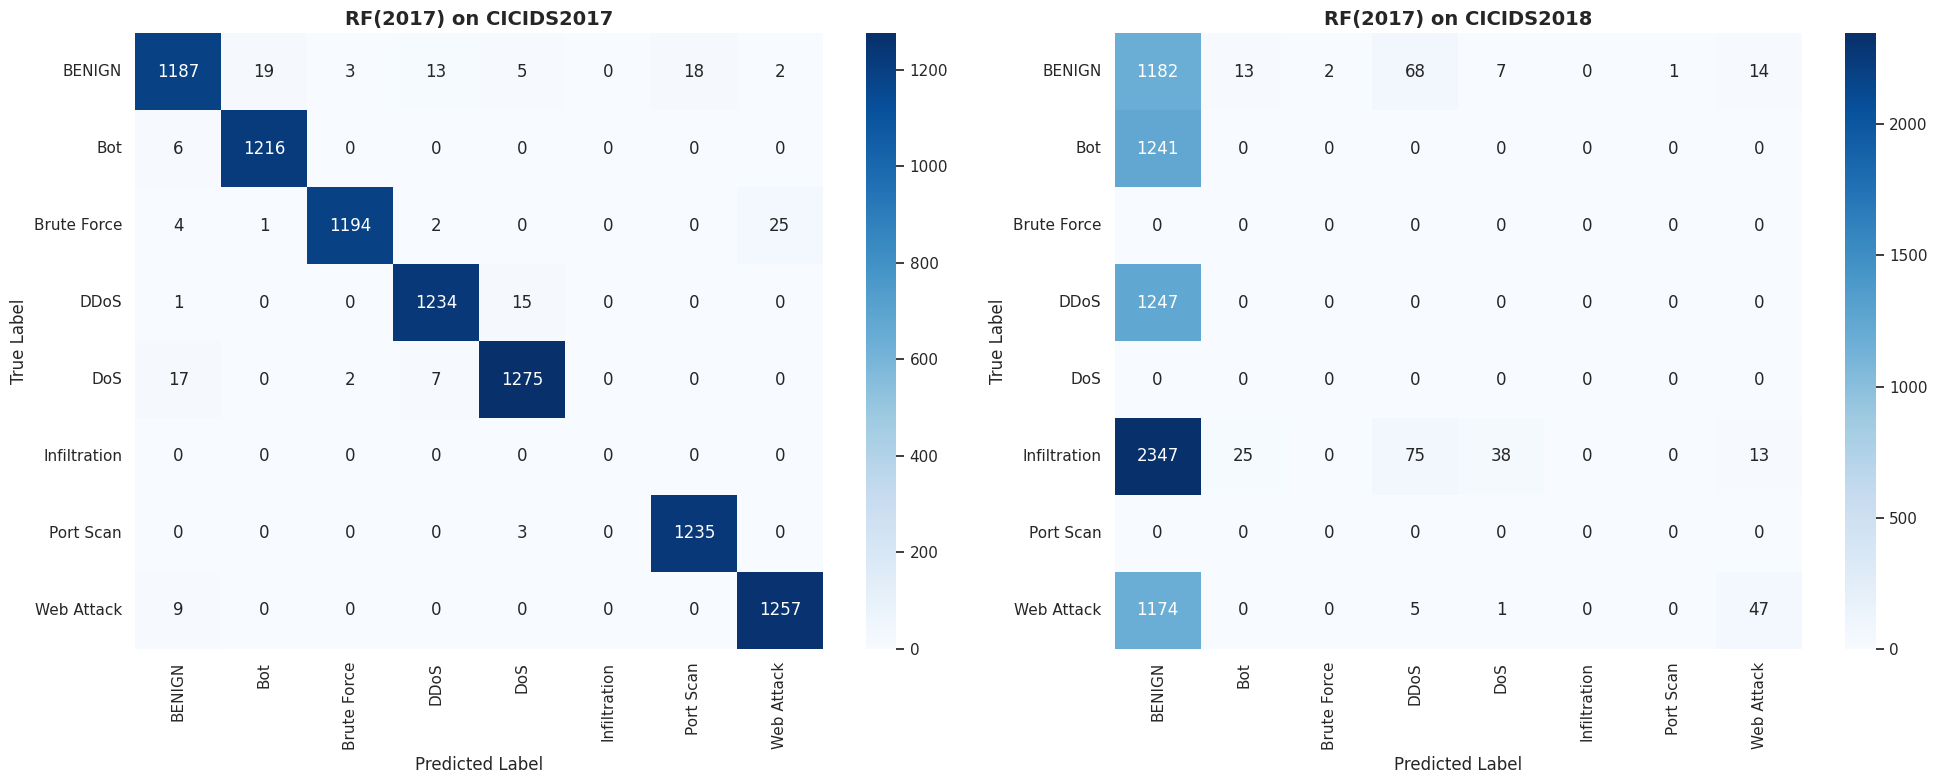


📊 RF(2018) Ensemble on CICIDS2018
Accuracy: 0.9064
F1-Score (Macro): 0.9076
F1-Score (Weighted): 0.9003
Precision (Macro): 0.9311
Recall (Macro): 0.8998

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.86      0.56      0.68      1287
         Bot       1.00      1.00      1.00      1241
        DDoS       1.00      1.00      1.00      1247
Infiltration       0.81      0.95      0.87      2498
  Web Attack       0.99      0.99      0.99      1227

    accuracy                           0.91      7500
   macro avg       0.93      0.90      0.91      7500
weighted avg       0.91      0.91      0.90      7500


📊 RF(2018) Ensemble on CICIDS2017
Accuracy: 0.0743
F1-Score (Macro): 0.0454
F1-Score (Weighted): 0.0517
Precision (Macro): 0.0348
Recall (Macro): 0.0652

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.28      0.52      0.36      1247
         Bot       0.00     

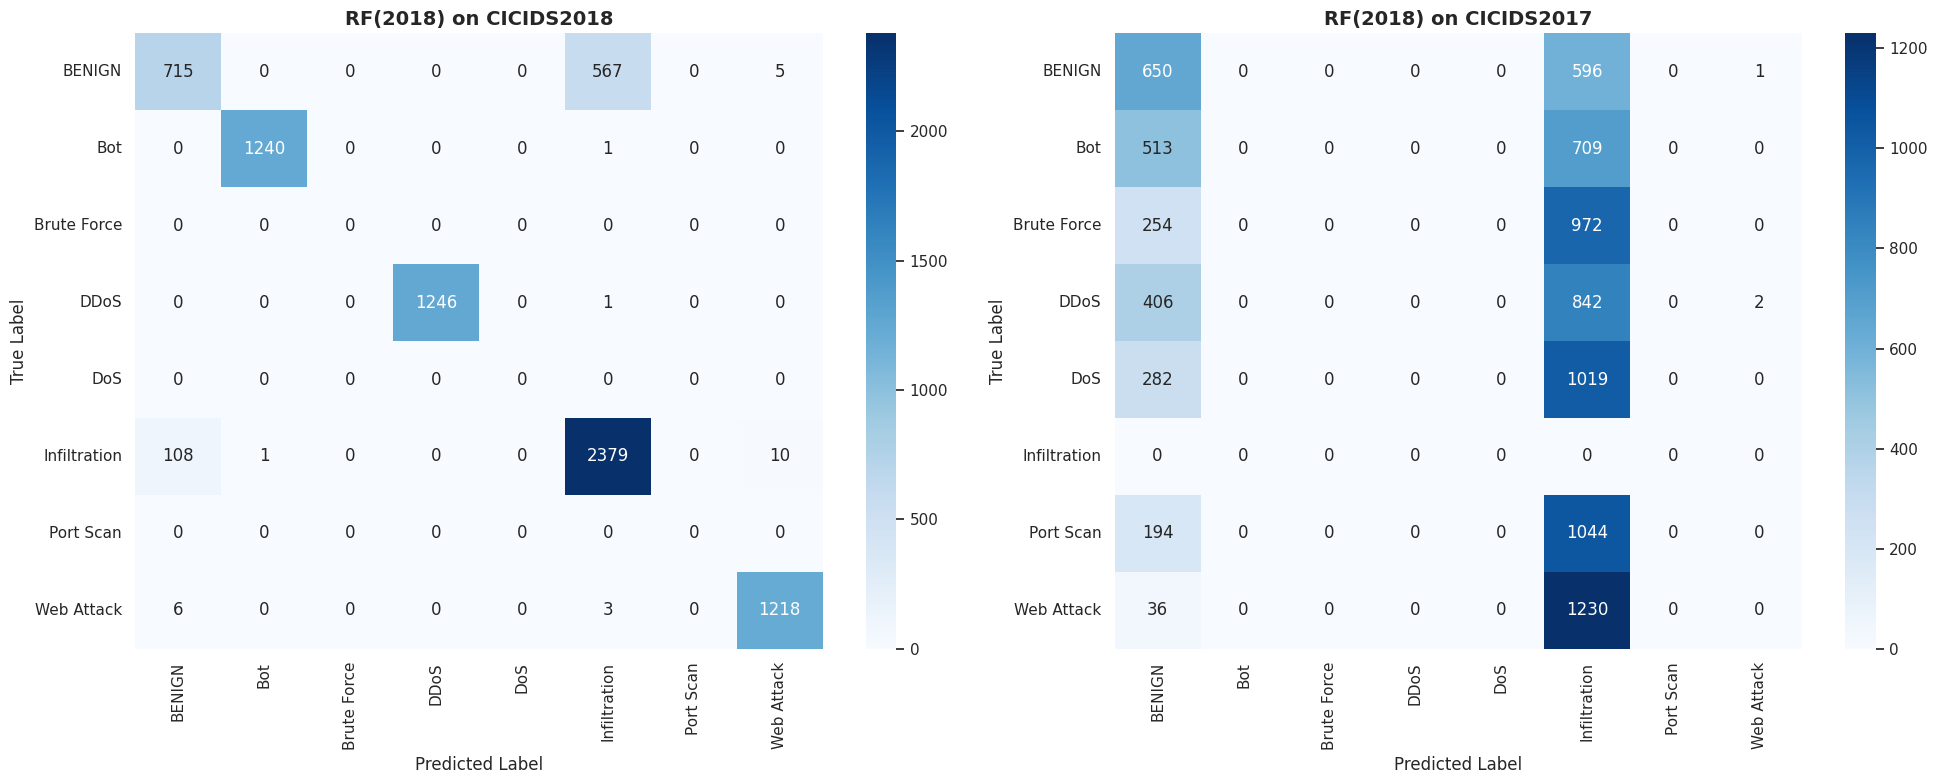


📊 DT(2017) Ensemble on CICIDS2017
Accuracy: 0.9798
F1-Score (Macro): 0.9798
F1-Score (Weighted): 0.9798
Precision (Macro): 0.9798
Recall (Macro): 0.9799

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.95      0.95      0.95      1247
         Bot       0.98      0.99      0.99      1222
 Brute Force       0.98      0.98      0.98      1226
        DDoS       0.99      0.99      0.99      1250
         DoS       0.98      0.97      0.98      1301
   Port Scan       0.98      0.99      0.99      1238
  Web Attack       0.99      0.98      0.99      1266

    accuracy                           0.98      8750
   macro avg       0.98      0.98      0.98      8750
weighted avg       0.98      0.98      0.98      8750


📊 DT(2017) Ensemble on CICIDS2018
Accuracy: 0.1403
F1-Score (Macro): 0.0390
F1-Score (Weighted): 0.0535
Precision (Macro): 0.0241
Recall (Macro): 0.1022

Detailed Classification Report:
              precision    re

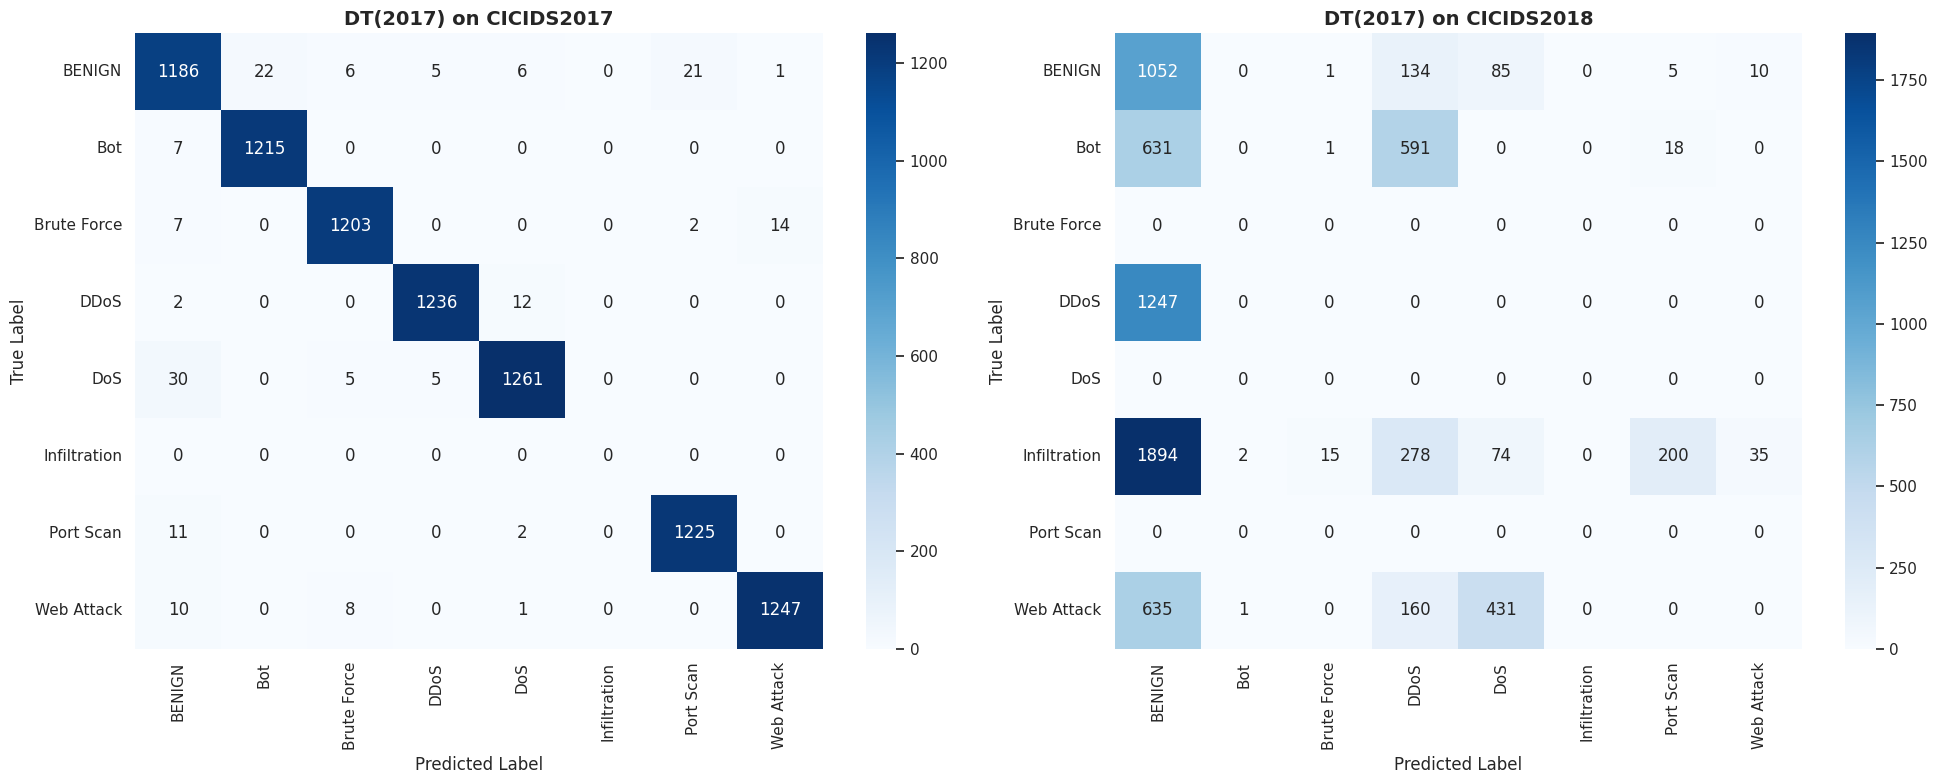


📊 DT(2018) Ensemble on CICIDS2018
Accuracy: 0.8876
F1-Score (Macro): 0.8871
F1-Score (Weighted): 0.8791
Precision (Macro): 0.9181
Recall (Macro): 0.8787

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.84      0.48      0.61      1287
         Bot       1.00      0.98      0.99      1241
        DDoS       1.00      1.00      1.00      1247
Infiltration       0.77      0.95      0.85      2498
  Web Attack       0.98      0.98      0.98      1227

    accuracy                           0.89      7500
   macro avg       0.92      0.88      0.89      7500
weighted avg       0.89      0.89      0.88      7500


📊 DT(2018) Ensemble on CICIDS2017
Accuracy: 0.0473
F1-Score (Macro): 0.0289
F1-Score (Weighted): 0.0330
Precision (Macro): 0.0222
Recall (Macro): 0.0415

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.18      0.33      0.23      1247
         Bot       0.00     

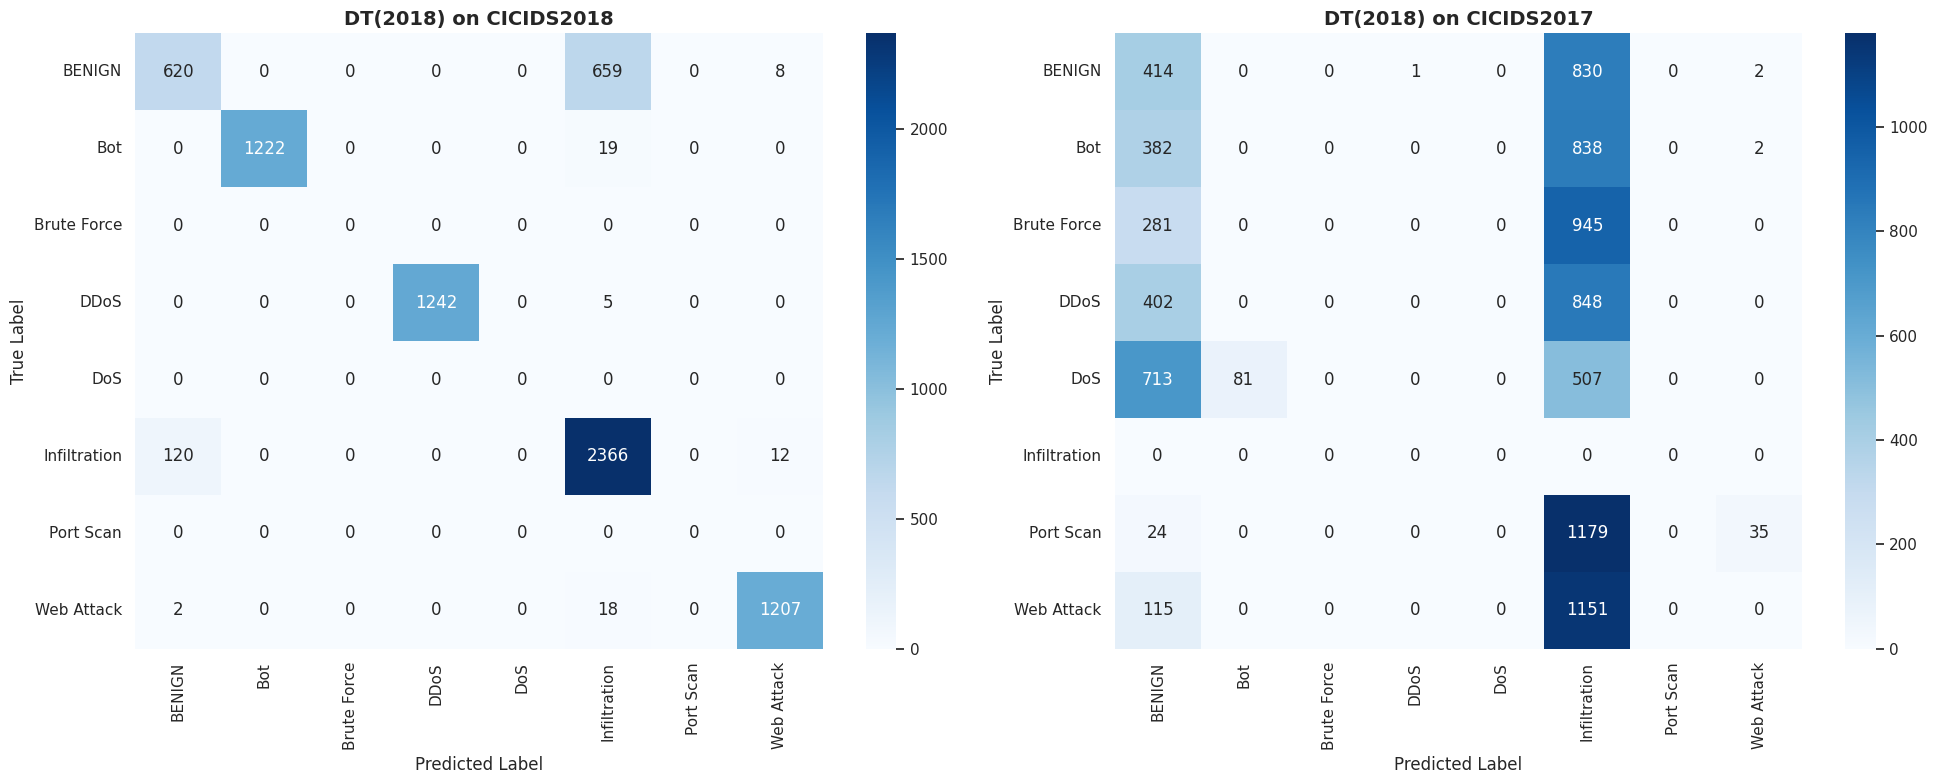


📊 KNN(2017) Ensemble on CICIDS2017
Accuracy: 0.9823
F1-Score (Macro): 0.9822
F1-Score (Weighted): 0.9822
Precision (Macro): 0.9824
Recall (Macro): 0.9823

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.98      0.93      0.96      1247
         Bot       0.97      1.00      0.98      1222
 Brute Force       0.99      0.99      0.99      1226
        DDoS       1.00      0.99      0.99      1250
         DoS       0.98      0.99      0.98      1301
   Port Scan       0.98      0.99      0.99      1238
  Web Attack       0.98      1.00      0.99      1266

    accuracy                           0.98      8750
   macro avg       0.98      0.98      0.98      8750
weighted avg       0.98      0.98      0.98      8750


📊 KNN(2017) Ensemble on CICIDS2018
Accuracy: 0.1425
F1-Score (Macro): 0.0348
F1-Score (Weighted): 0.0478
Precision (Macro): 0.0209
Recall (Macro): 0.1038

Detailed Classification Report:
              precision    

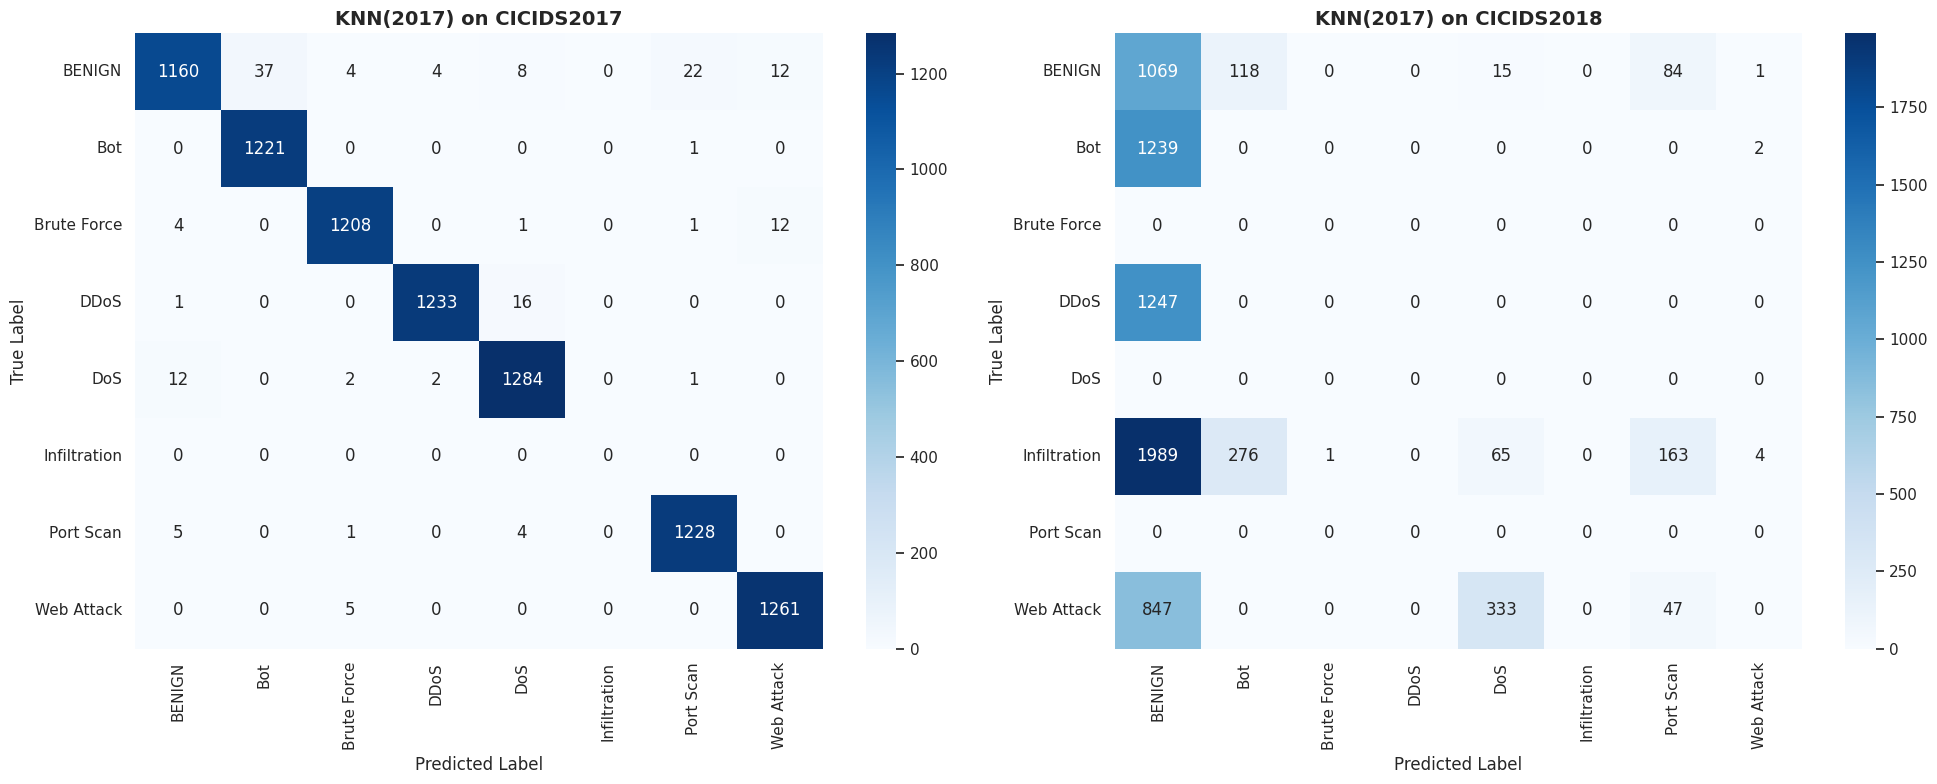


📊 KNN(2018) Ensemble on CICIDS2018
Accuracy: 0.9031
F1-Score (Macro): 0.9111
F1-Score (Weighted): 0.9012
Precision (Macro): 0.9144
Recall (Macro): 0.9091

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.75      0.66      0.71      1287
         Bot       1.00      1.00      1.00      1241
        DDoS       1.00      1.00      1.00      1247
Infiltration       0.84      0.88      0.86      2498
  Web Attack       0.98      1.00      0.99      1227

    accuracy                           0.90      7500
   macro avg       0.91      0.91      0.91      7500
weighted avg       0.90      0.90      0.90      7500


📊 KNN(2018) Ensemble on CICIDS2017
Accuracy: 0.0399
F1-Score (Macro): 0.0259
F1-Score (Weighted): 0.0295
Precision (Macro): 0.0305
Recall (Macro): 0.0350

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.16      0.28      0.20      1247
         Bot       0.08   

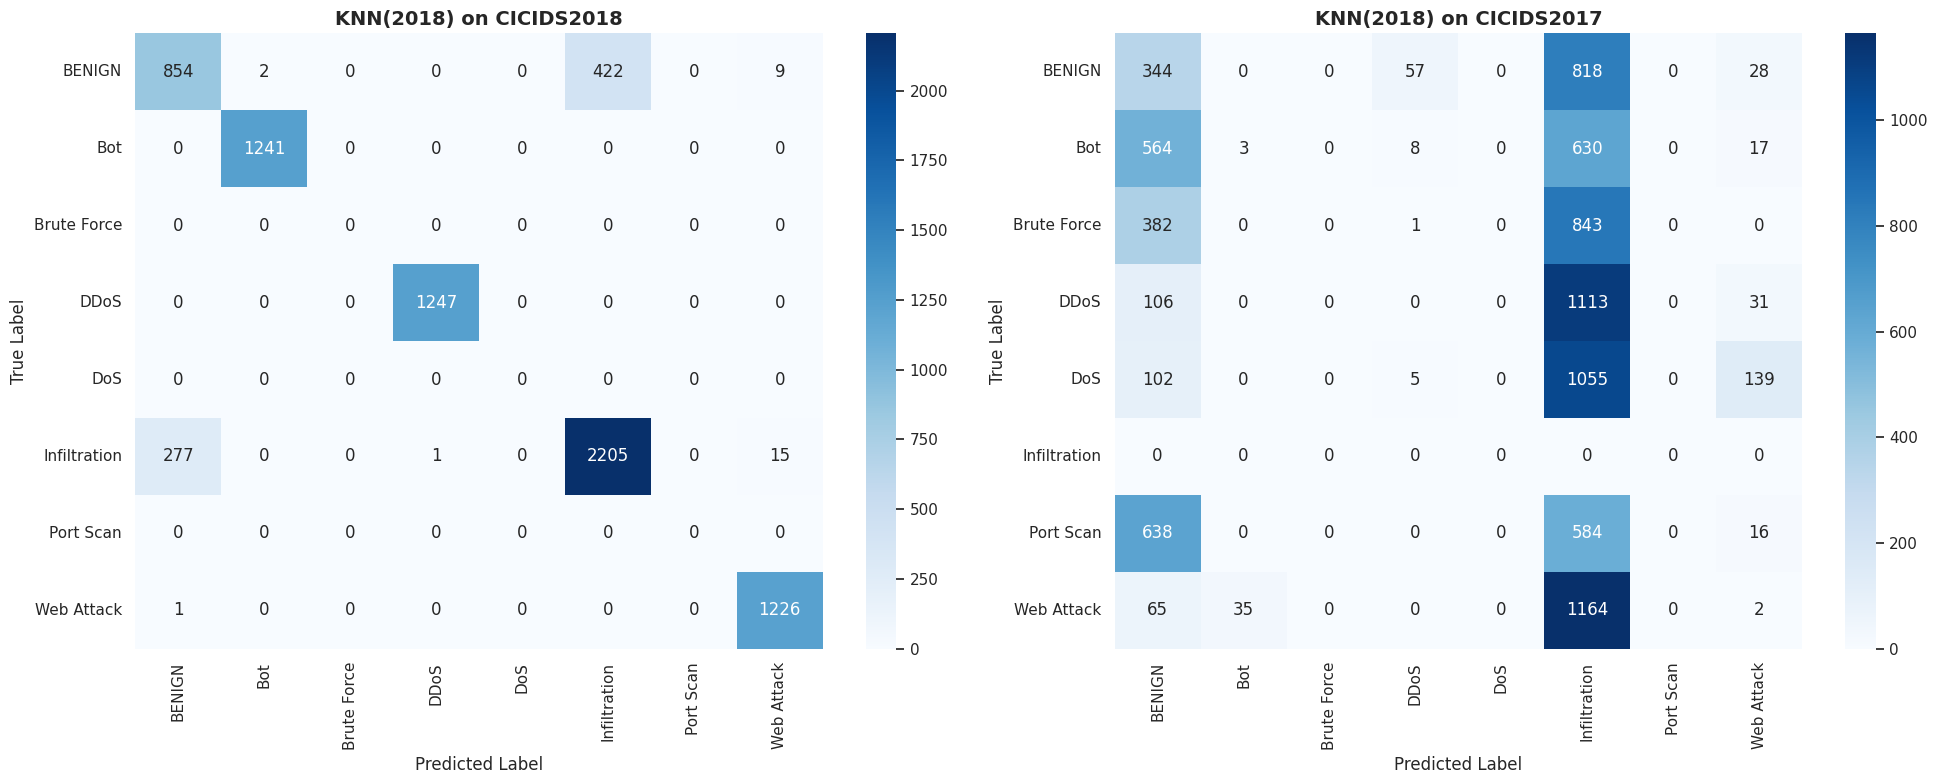


📊 NB(2017) Ensemble on CICIDS2017
Accuracy: 0.7998
F1-Score (Macro): 0.7912
F1-Score (Weighted): 0.7925
Precision (Macro): 0.8086
Recall (Macro): 0.7989

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.89      0.70      0.78      1247
         Bot       0.57      0.36      0.45      1222
 Brute Force       0.92      0.97      0.94      1226
        DDoS       0.82      0.94      0.88      1250
         DoS       0.89      0.80      0.84      1301
   Port Scan       0.61      0.97      0.75      1238
  Web Attack       0.96      0.85      0.90      1266

    accuracy                           0.80      8750
   macro avg       0.81      0.80      0.79      8750
weighted avg       0.81      0.80      0.79      8750


📊 NB(2017) Ensemble on CICIDS2018
Accuracy: 0.1308
F1-Score (Macro): 0.0428
F1-Score (Weighted): 0.0441
Precision (Macro): 0.1919
Recall (Macro): 0.1271

Detailed Classification Report:
              precision    re

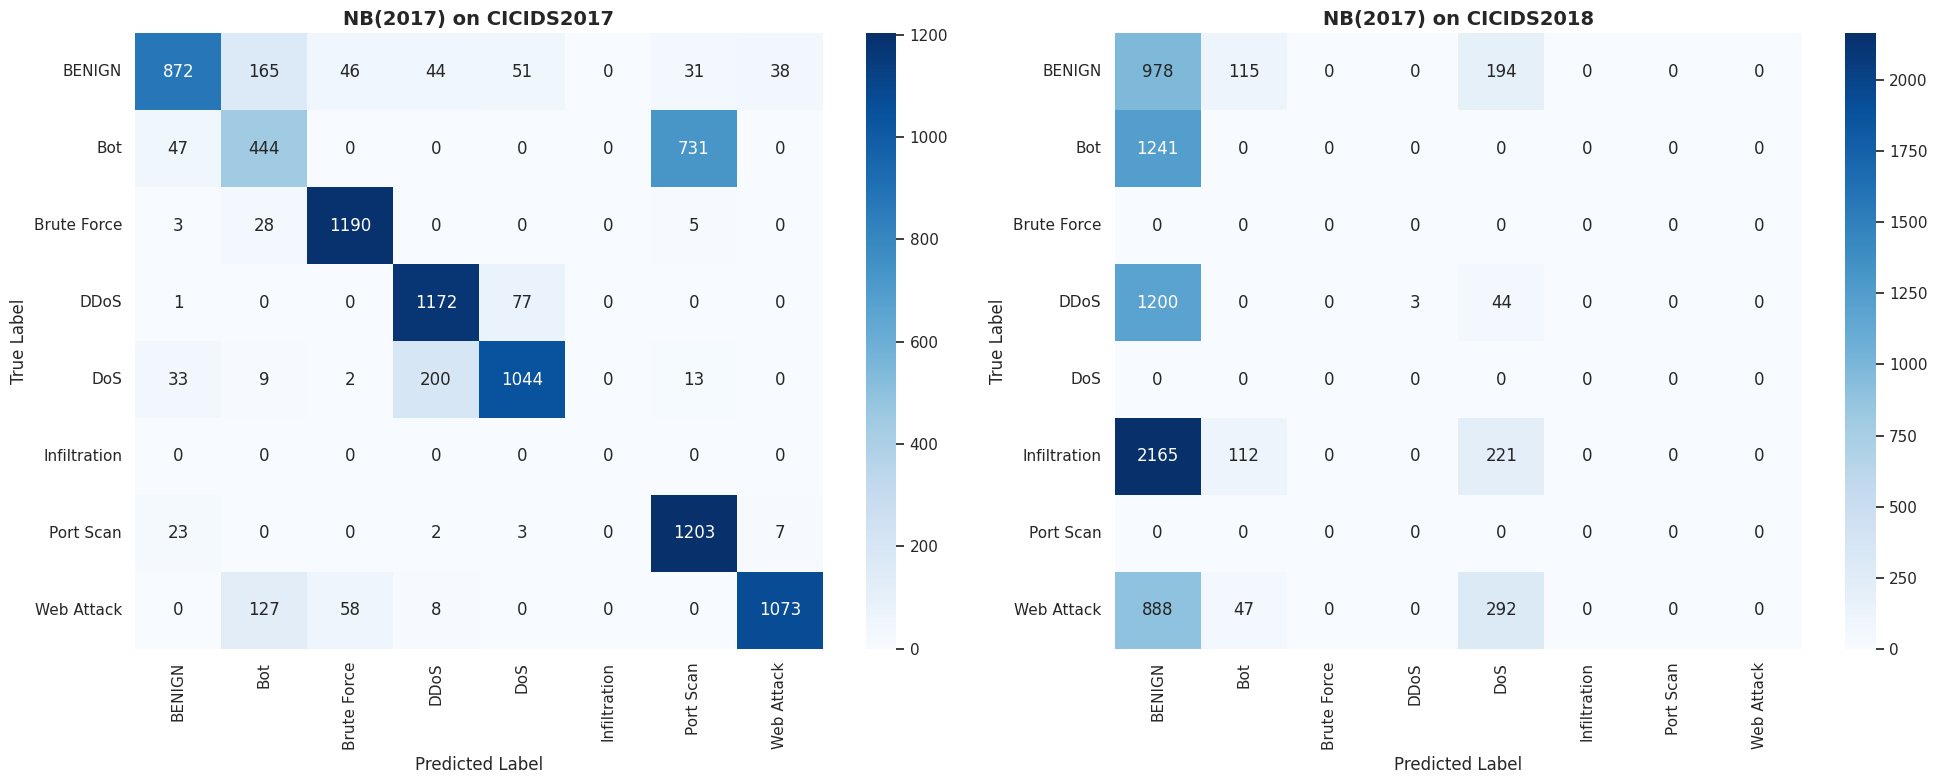


📊 NB(2018) Ensemble on CICIDS2018
Accuracy: 0.6217
F1-Score (Macro): 0.6467
F1-Score (Weighted): 0.5917
Precision (Macro): 0.7468
Recall (Macro): 0.7052

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.35      0.88      0.50      1287
         Bot       0.70      0.98      0.82      1241
        DDoS       1.00      1.00      1.00      1247
Infiltration       0.88      0.20      0.32      2498
  Web Attack       0.81      0.47      0.60      1227

    accuracy                           0.62      7500
   macro avg       0.75      0.71      0.65      7500
weighted avg       0.77      0.62      0.59      7500


📊 NB(2018) Ensemble on CICIDS2017
Accuracy: 0.1265
F1-Score (Macro): 0.0325
F1-Score (Weighted): 0.0371
Precision (Macro): 0.0193
Recall (Macro): 0.1110

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.15      0.88      0.26      1247
         Bot       0.00     

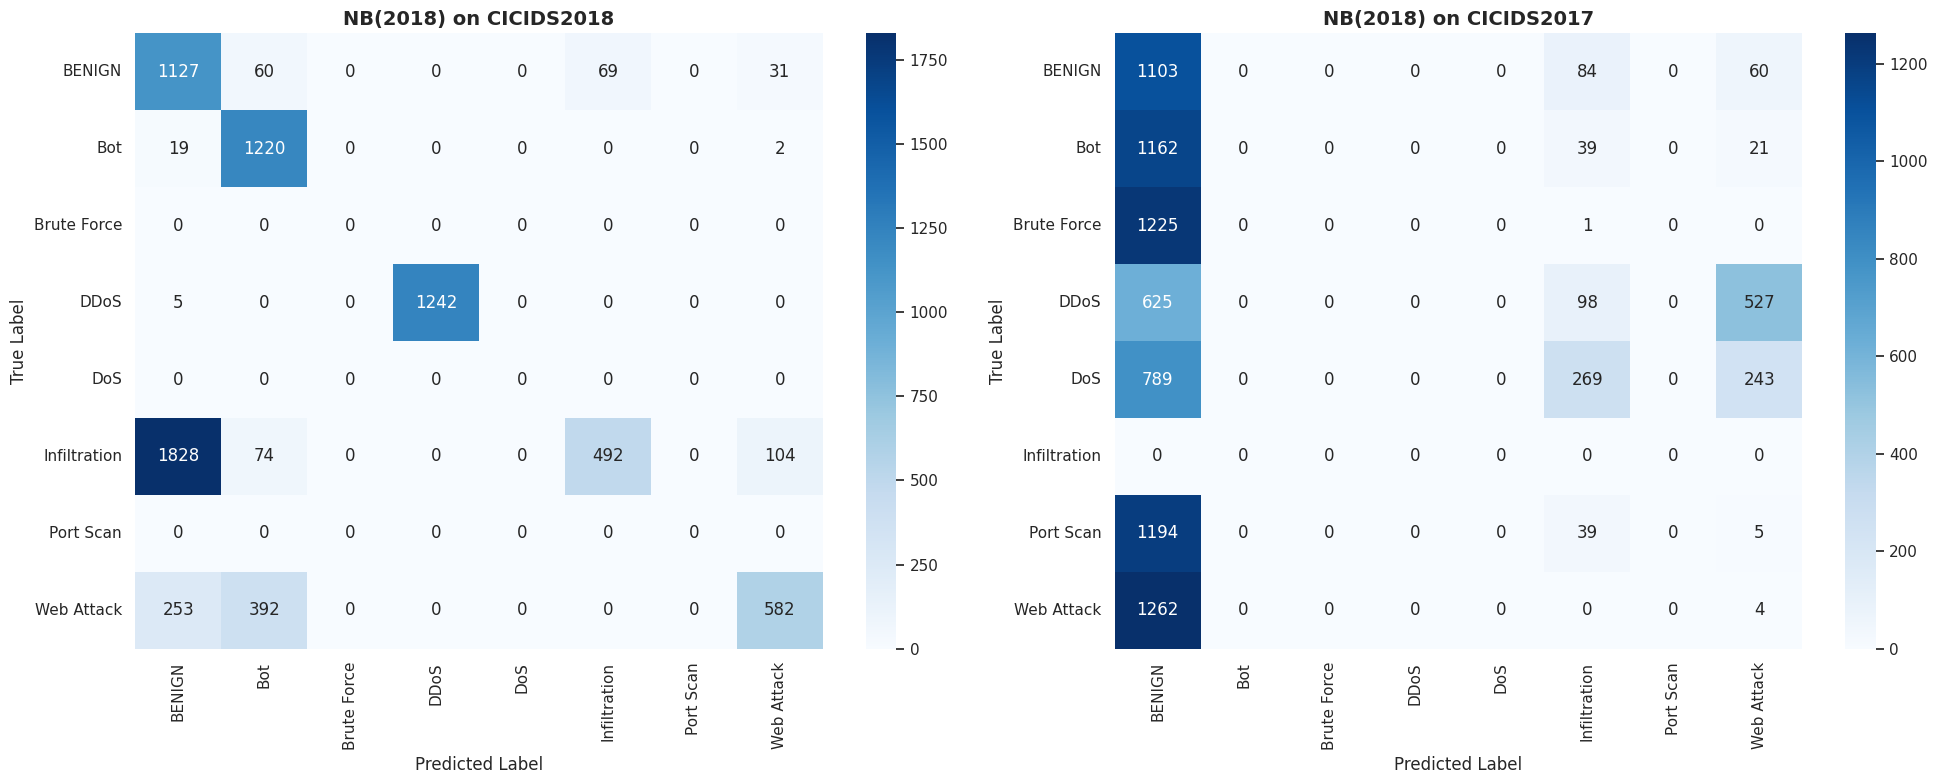


📊 LR(2017) Ensemble on CICIDS2017
Accuracy: 0.9514
F1-Score (Macro): 0.9505
F1-Score (Weighted): 0.9504
Precision (Macro): 0.9530
Recall (Macro): 0.9517

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.97      0.80      0.88      1247
         Bot       0.91      0.99      0.95      1222
 Brute Force       0.98      0.97      0.98      1226
        DDoS       0.92      1.00      0.96      1250
         DoS       0.98      0.92      0.95      1301
   Port Scan       0.98      0.99      0.99      1238
  Web Attack       0.93      0.99      0.96      1266

    accuracy                           0.95      8750
   macro avg       0.95      0.95      0.95      8750
weighted avg       0.95      0.95      0.95      8750


📊 LR(2017) Ensemble on CICIDS2018
Accuracy: 0.1763
F1-Score (Macro): 0.1032
F1-Score (Weighted): 0.1379
Precision (Macro): 0.1718
Recall (Macro): 0.1313

Detailed Classification Report:
              precision    re

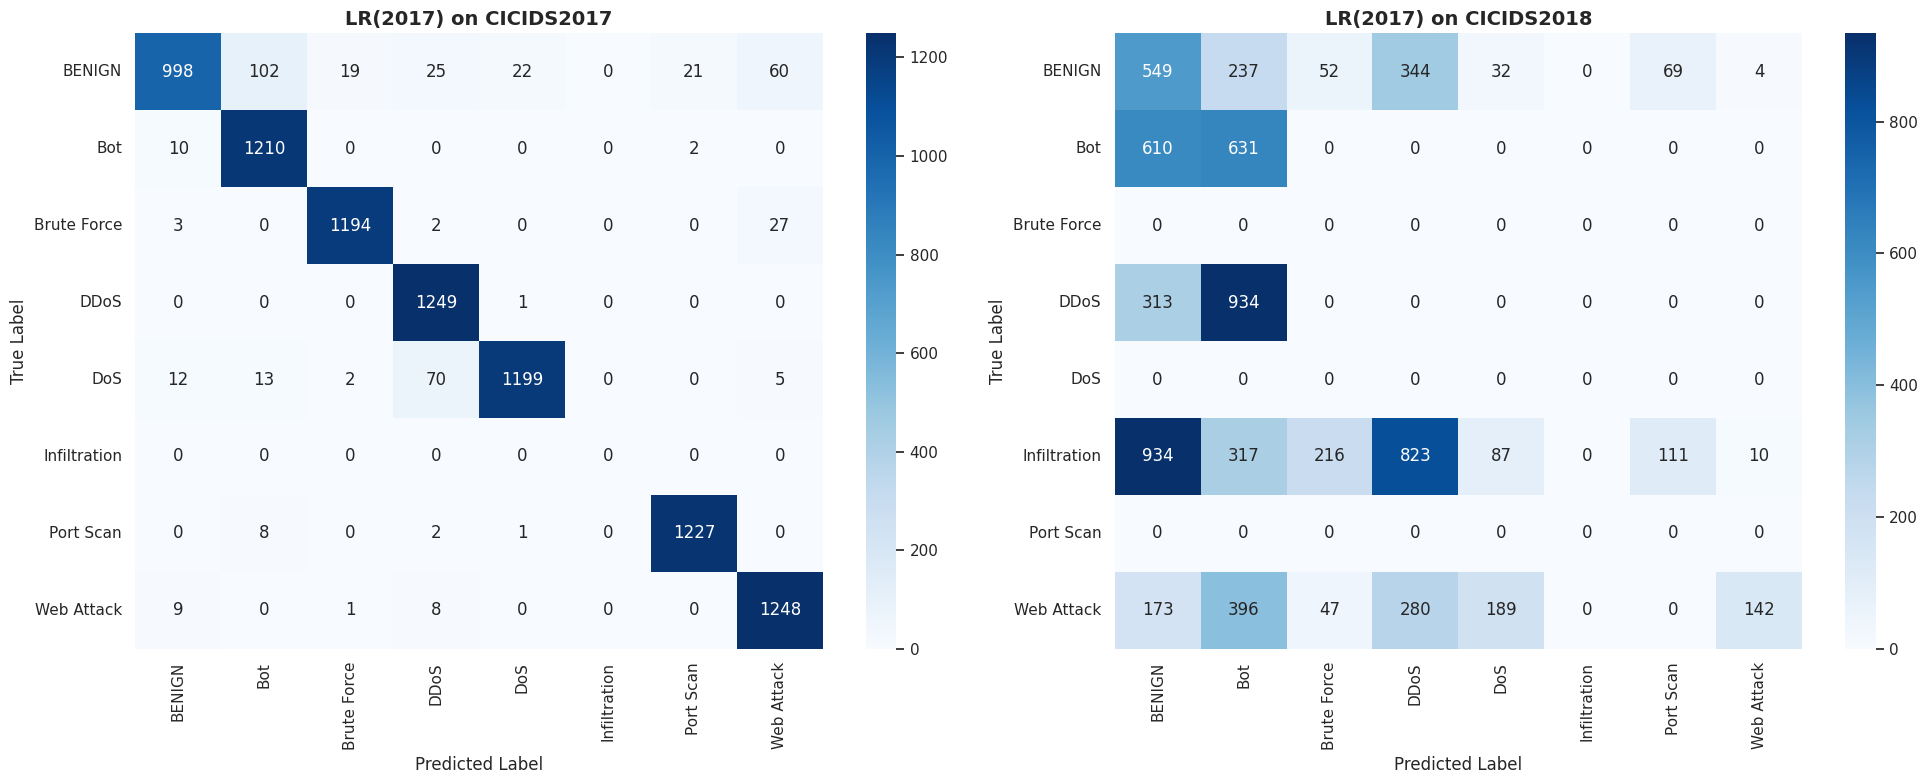


📊 LR(2018) Ensemble on CICIDS2018
Accuracy: 0.8380
F1-Score (Macro): 0.8266
F1-Score (Weighted): 0.8195
Precision (Macro): 0.8510
Recall (Macro): 0.8341

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.70      0.32      0.44      1287
         Bot       0.94      0.99      0.96      1241
        DDoS       1.00      1.00      1.00      1247
Infiltration       0.73      0.88      0.80      2498
  Web Attack       0.89      0.99      0.94      1227

    accuracy                           0.84      7500
   macro avg       0.85      0.83      0.83      7500
weighted avg       0.83      0.84      0.82      7500


📊 LR(2018) Ensemble on CICIDS2017
Accuracy: 0.0943
F1-Score (Macro): 0.0666
F1-Score (Weighted): 0.0761
Precision (Macro): 0.1370
Recall (Macro): 0.0826

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.16      0.47      0.24      1247
         Bot       0.05     

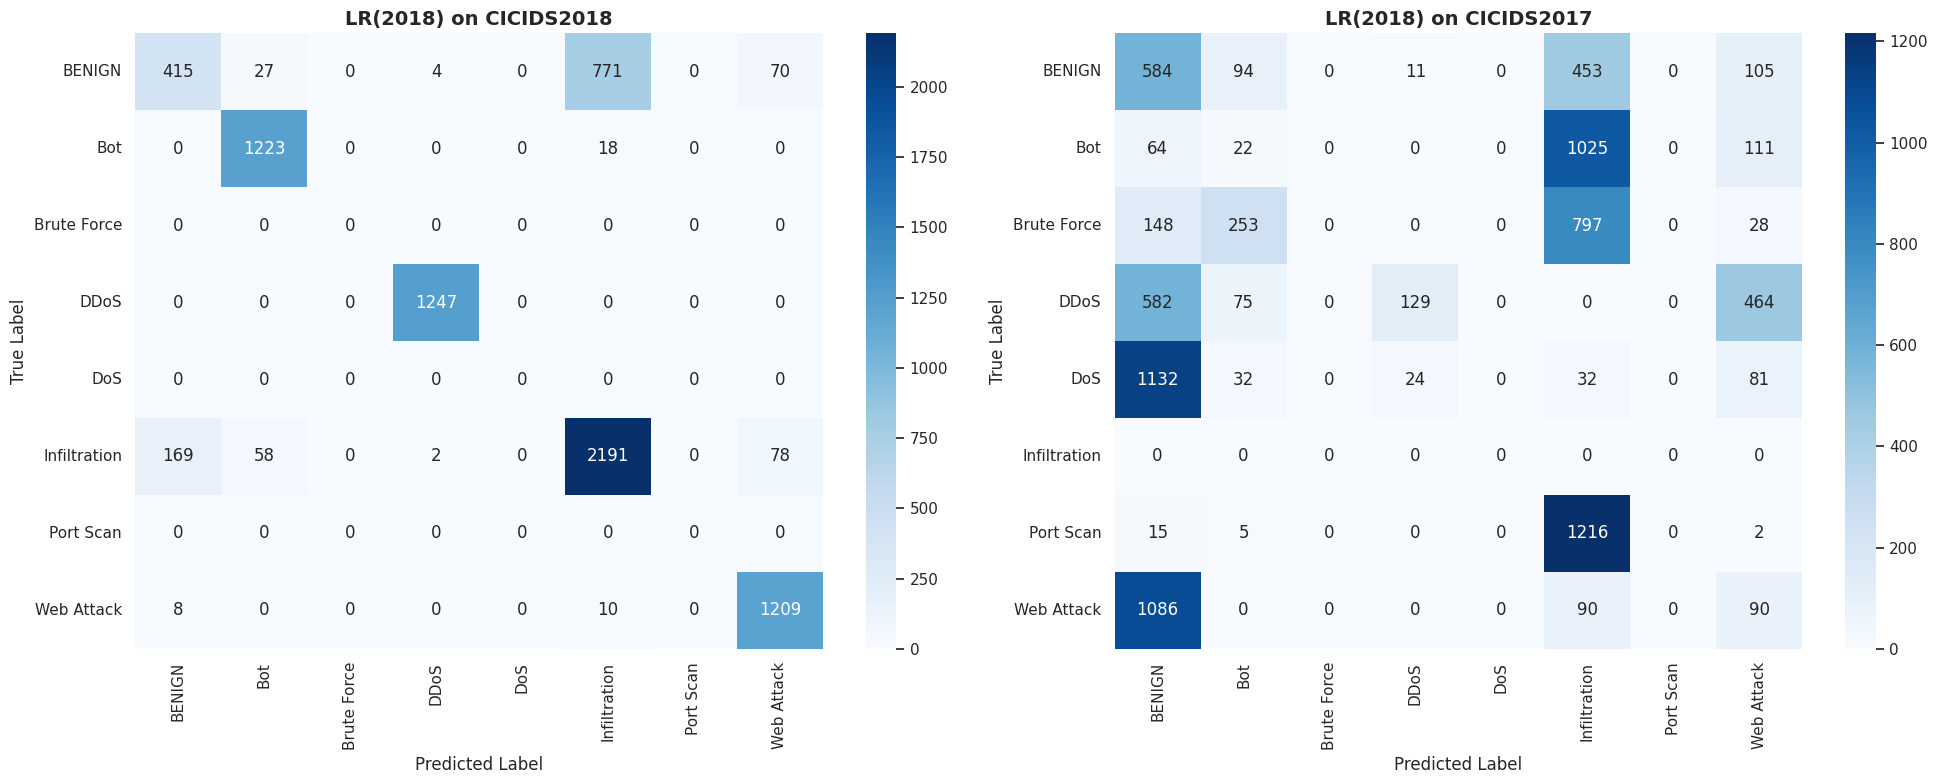


📊 LGB(2017) Ensemble on CICIDS2017
Accuracy: 0.9978
F1-Score (Macro): 0.9978
F1-Score (Weighted): 0.9978
Precision (Macro): 0.9978
Recall (Macro): 0.9978

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      0.99      0.99      1247
         Bot       1.00      1.00      1.00      1222
 Brute Force       1.00      1.00      1.00      1226
        DDoS       1.00      1.00      1.00      1250
         DoS       1.00      1.00      1.00      1301
   Port Scan       1.00      1.00      1.00      1238
  Web Attack       1.00      1.00      1.00      1266

    accuracy                           1.00      8750
   macro avg       1.00      1.00      1.00      8750
weighted avg       1.00      1.00      1.00      8750


📊 LGB(2017) Ensemble on CICIDS2018
Accuracy: 0.1439
F1-Score (Macro): 0.0437
F1-Score (Weighted): 0.0450
Precision (Macro): 0.0259
Recall (Macro): 0.1397

Detailed Classification Report:
              precision    

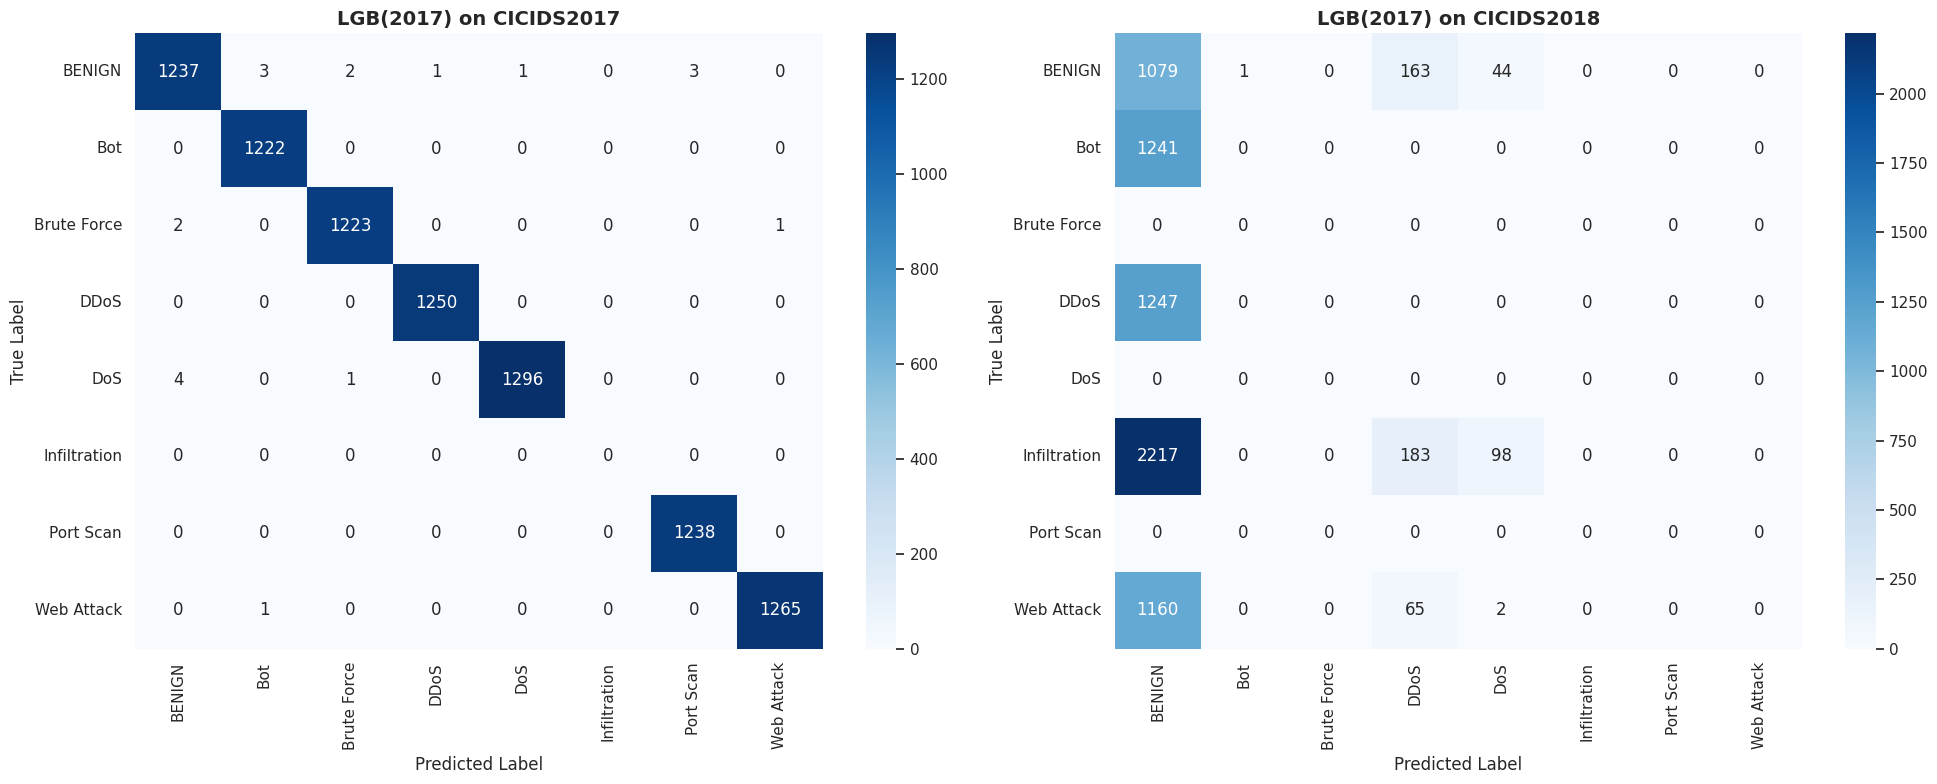


📊 LGB(2018) Ensemble on CICIDS2018
Accuracy: 0.9141
F1-Score (Macro): 0.9188
F1-Score (Weighted): 0.9109
Precision (Macro): 0.9308
Recall (Macro): 0.9129

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.83      0.64      0.72      1287
         Bot       1.00      1.00      1.00      1241
        DDoS       1.00      1.00      1.00      1247
Infiltration       0.83      0.93      0.88      2498
  Web Attack       0.99      1.00      1.00      1227

    accuracy                           0.91      7500
   macro avg       0.93      0.91      0.92      7500
weighted avg       0.91      0.91      0.91      7500


📊 LGB(2018) Ensemble on CICIDS2017
Accuracy: 0.1019
F1-Score (Macro): 0.0377
F1-Score (Weighted): 0.0430
Precision (Macro): 0.0252
Recall (Macro): 0.0894

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.18      0.71      0.29      1247
         Bot       0.00   

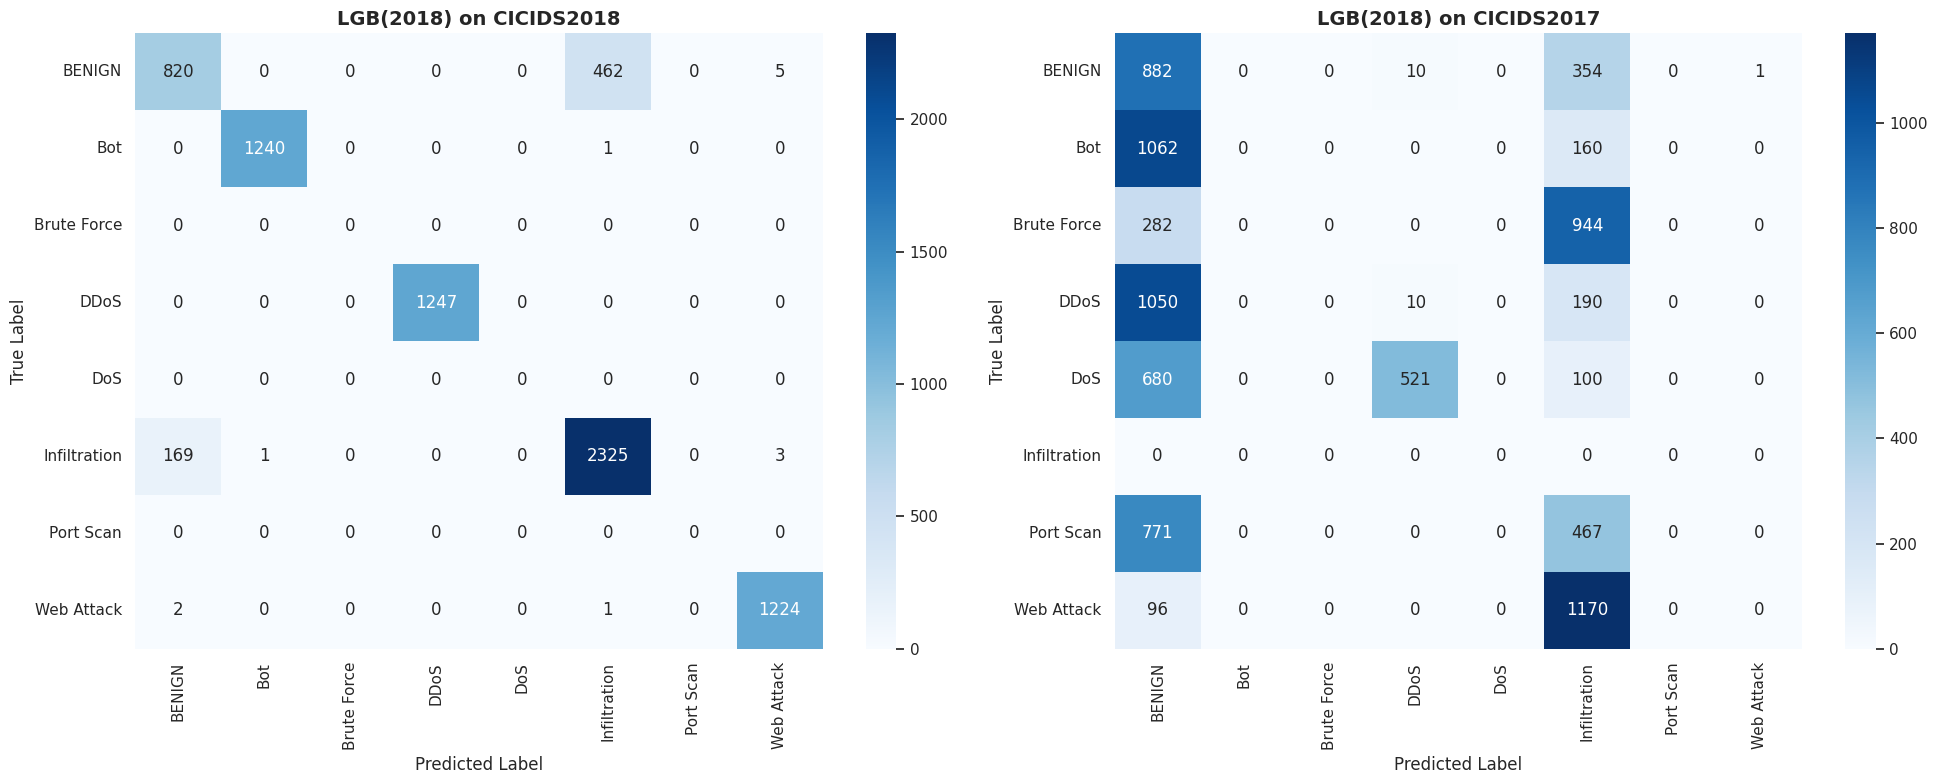

🔬 Running 36 ensemble combinations...
This includes: Same-model ensembles + All cross-model combinations

[1/36] Testing: RF(2017) + RF(2018)

🔬 Running RF(2017) + RF(2018) ensemble experiment...

📊 RF(2017) + RF(2018) Ensemble on CICIDS2017
Accuracy: 0.9744
F1-Score (Macro): 0.8548
F1-Score (Weighted): 0.9768
Precision (Macro): 0.8571
Recall (Macro): 0.8527

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.92      0.96      0.94      1247
         Bot       0.99      0.98      0.99      1222
 Brute Force       1.00      0.97      0.98      1226
        DDoS       0.99      0.99      0.99      1250
         DoS       0.99      0.96      0.97      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.99      0.98      0.98      1238
  Web Attack       0.98      0.98      0.98      1266

    accuracy                           0.97      8750
   macro avg       0.86      0.85      0.85      8750
weighted a

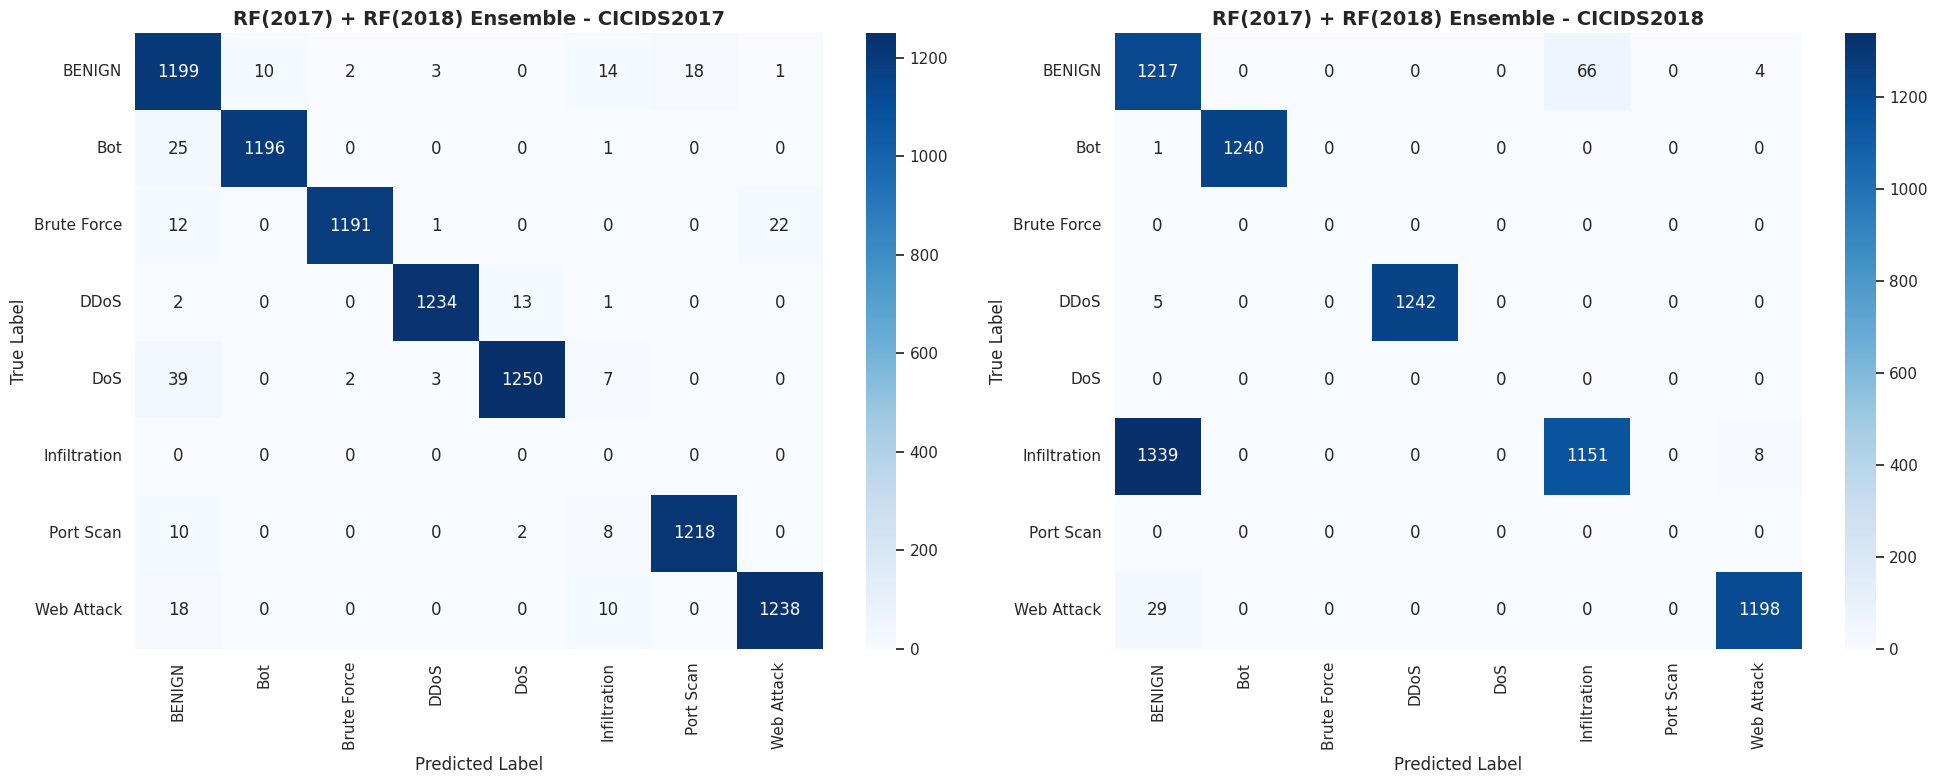


[2/36] Testing: RF(2017) + DT(2018)

🔬 Running RF(2017) + DT(2018) ensemble experiment...

📊 RF(2017) + DT(2018) Ensemble on CICIDS2017
Accuracy: 0.7327
F1-Score (Macro): 0.6690
F1-Score (Weighted): 0.7628
Precision (Macro): 0.7790
Recall (Macro): 0.6431

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.38      0.88      0.53      1247
         Bot       0.91      0.63      0.75      1222
 Brute Force       1.00      0.76      0.86      1226
        DDoS       1.00      0.75      0.85      1250
         DoS       0.99      0.31      0.48      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.98      0.93      0.96      1238
  Web Attack       0.97      0.88      0.92      1266

    accuracy                           0.73      8750
   macro avg       0.78      0.64      0.67      8750
weighted avg       0.89      0.73      0.76      8750


📊 RF(2017) + DT(2018) Ensemble on CICIDS2018
Accuracy: 0.80

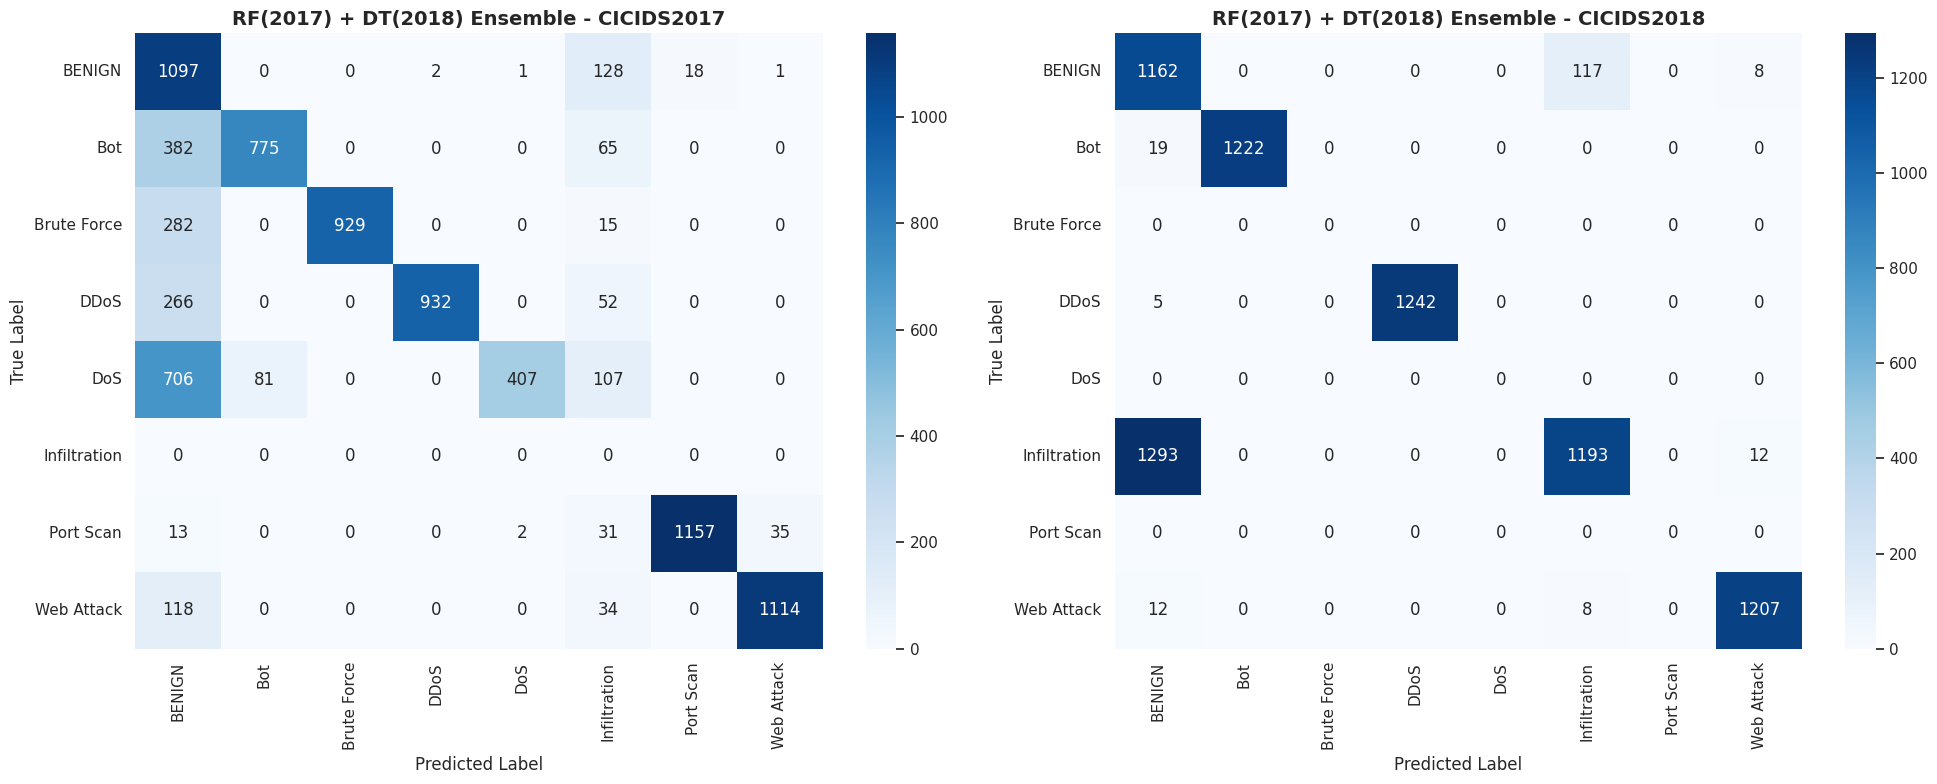


[3/36] Testing: RF(2017) + KNN(2018)

🔬 Running RF(2017) + KNN(2018) ensemble experiment...

📊 RF(2017) + KNN(2018) Ensemble on CICIDS2017
Accuracy: 0.8605
F1-Score (Macro): 0.7921
F1-Score (Weighted): 0.9045
Precision (Macro): 0.8406
Recall (Macro): 0.7540

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.85      0.85      0.85      1247
         Bot       0.99      0.92      0.95      1222
 Brute Force       1.00      0.97      0.98      1226
        DDoS       0.98      0.73      0.83      1250
         DoS       0.99      0.73      0.84      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.99      0.93      0.96      1238
  Web Attack       0.92      0.91      0.92      1266

    accuracy                           0.86      8750
   macro avg       0.84      0.75      0.79      8750
weighted avg       0.96      0.86      0.90      8750


📊 RF(2017) + KNN(2018) Ensemble on CICIDS2018
Accuracy: 

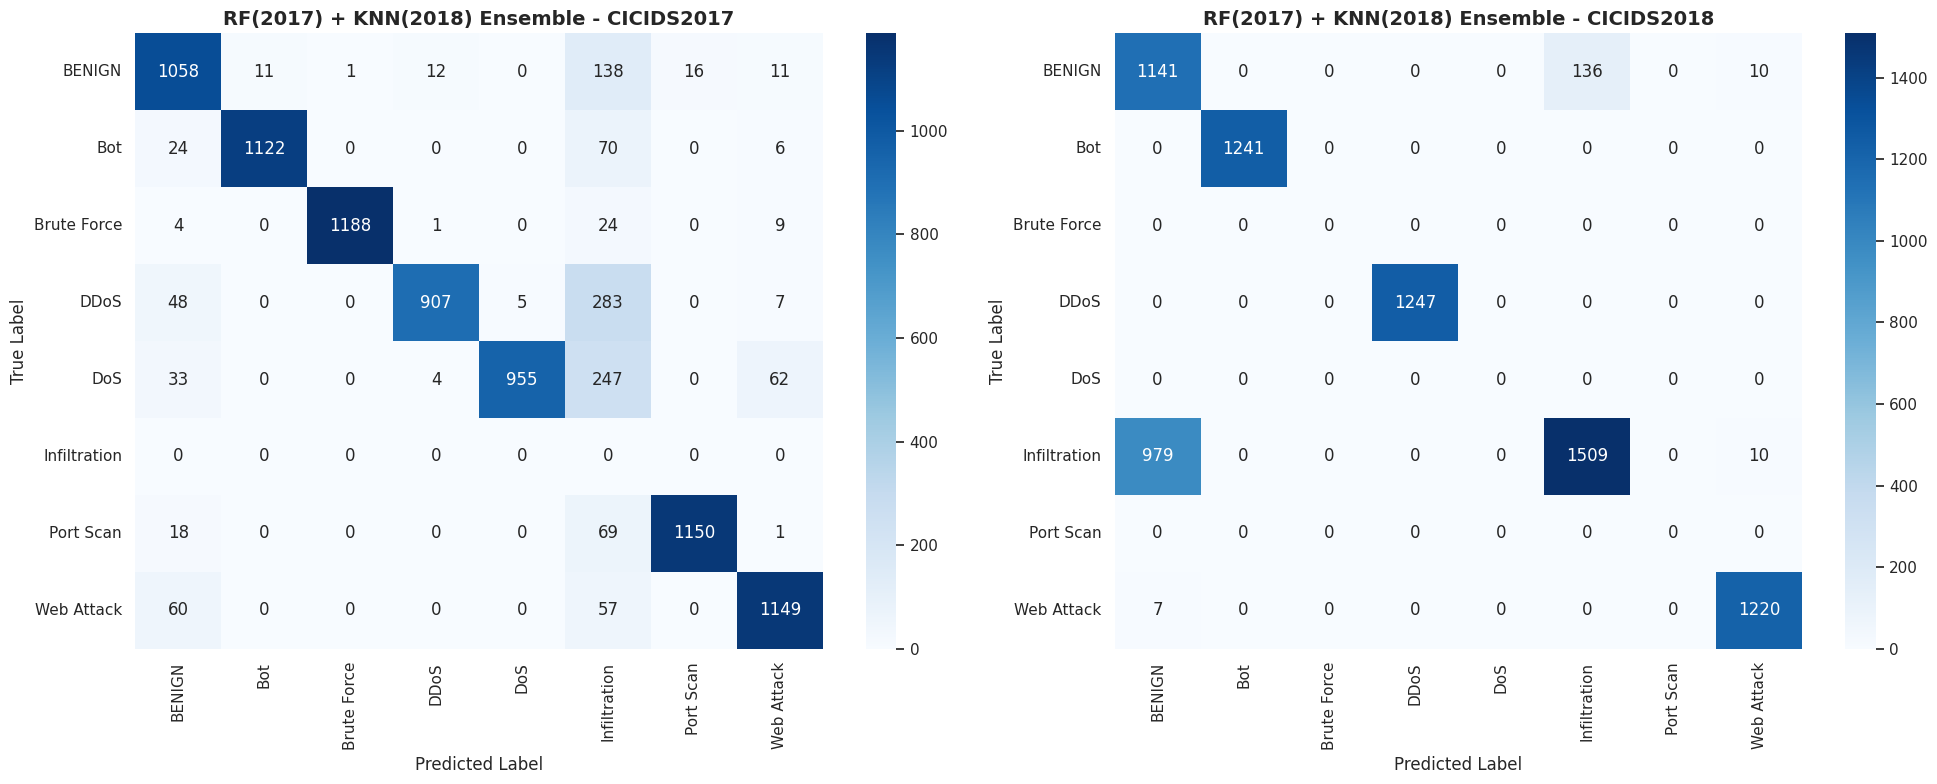


[4/36] Testing: RF(2017) + NB(2018)

🔬 Running RF(2017) + NB(2018) ensemble experiment...

📊 RF(2017) + NB(2018) Ensemble on CICIDS2017
Accuracy: 0.4238
F1-Score (Macro): 0.3531
F1-Score (Weighted): 0.4066
Precision (Macro): 0.7272
Recall (Macro): 0.3682

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.22      0.93      0.35      1247
         Bot       0.98      0.20      0.33      1222
 Brute Force       1.00      0.20      0.33      1226
        DDoS       1.00      0.18      0.30      1250
         DoS       1.00      0.51      0.68      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       1.00      0.06      0.11      1238
  Web Attack       0.63      0.88      0.73      1266

    accuracy                           0.42      8750
   macro avg       0.73      0.37      0.35      8750
weighted avg       0.83      0.42      0.41      8750


📊 RF(2017) + NB(2018) Ensemble on CICIDS2018
Accuracy: 0.61

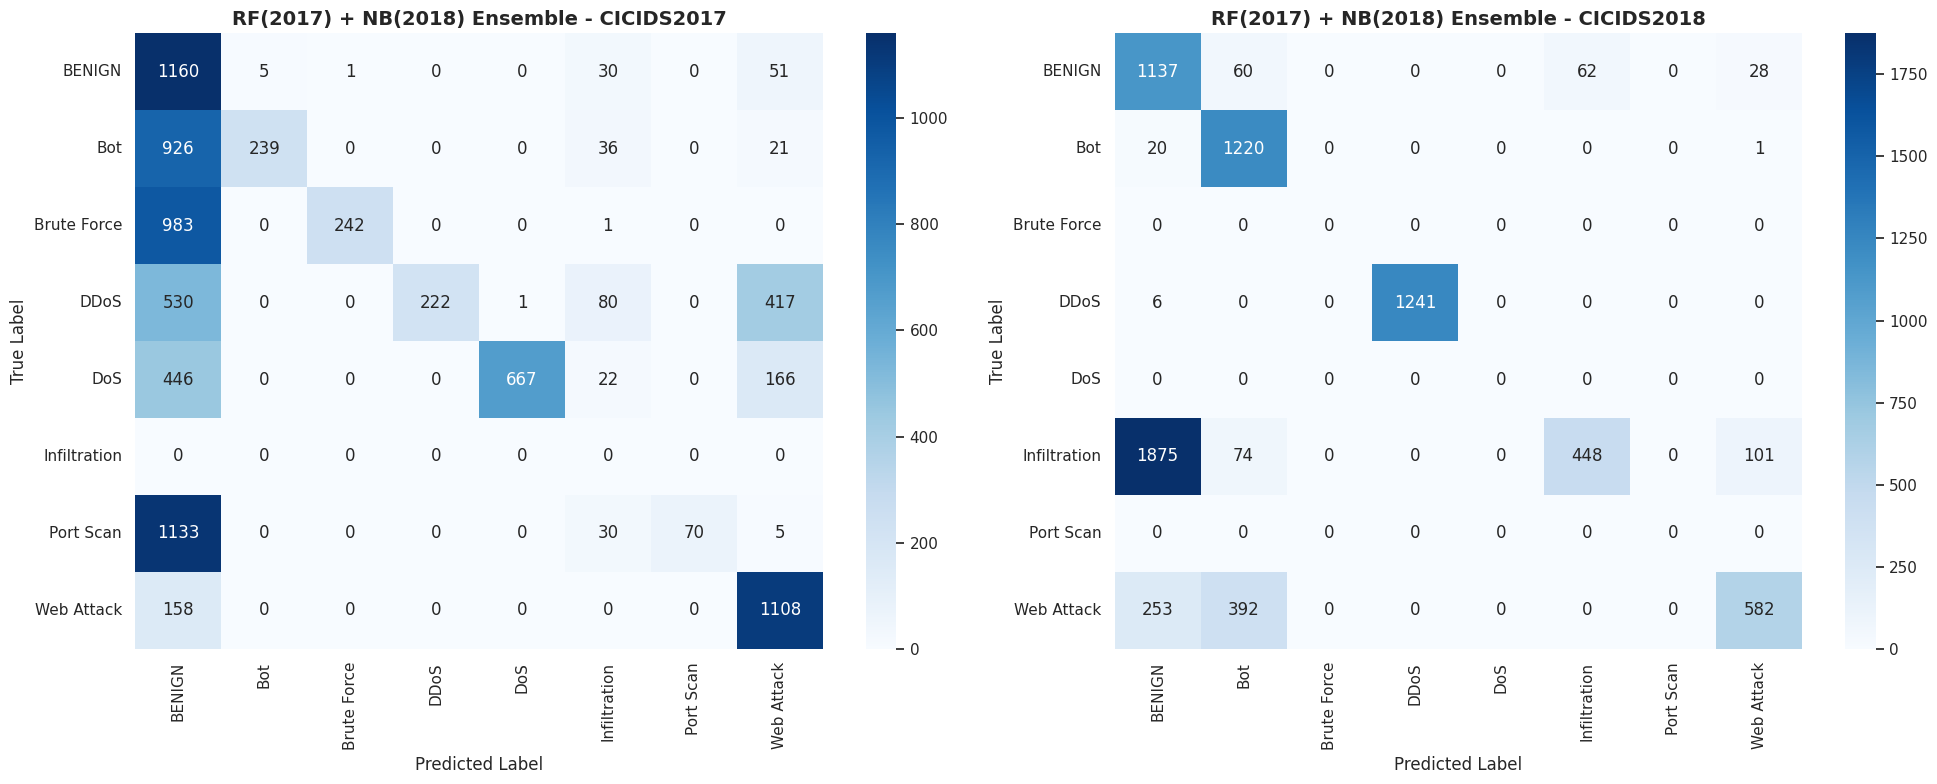


[5/36] Testing: RF(2017) + LR(2018)

🔬 Running RF(2017) + LR(2018) ensemble experiment...

📊 RF(2017) + LR(2018) Ensemble on CICIDS2017
Accuracy: 0.8813
F1-Score (Macro): 0.7829
F1-Score (Weighted): 0.8943
Precision (Macro): 0.8029
Recall (Macro): 0.7718

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.73      0.85      0.78      1247
         Bot       0.88      0.94      0.91      1222
 Brute Force       1.00      0.97      0.98      1226
        DDoS       0.97      0.81      0.88      1250
         DoS       1.00      0.77      0.87      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.99      0.86      0.92      1238
  Web Attack       0.86      0.99      0.92      1266

    accuracy                           0.88      8750
   macro avg       0.80      0.77      0.78      8750
weighted avg       0.92      0.88      0.89      8750


📊 RF(2017) + LR(2018) Ensemble on CICIDS2018
Accuracy: 0.65

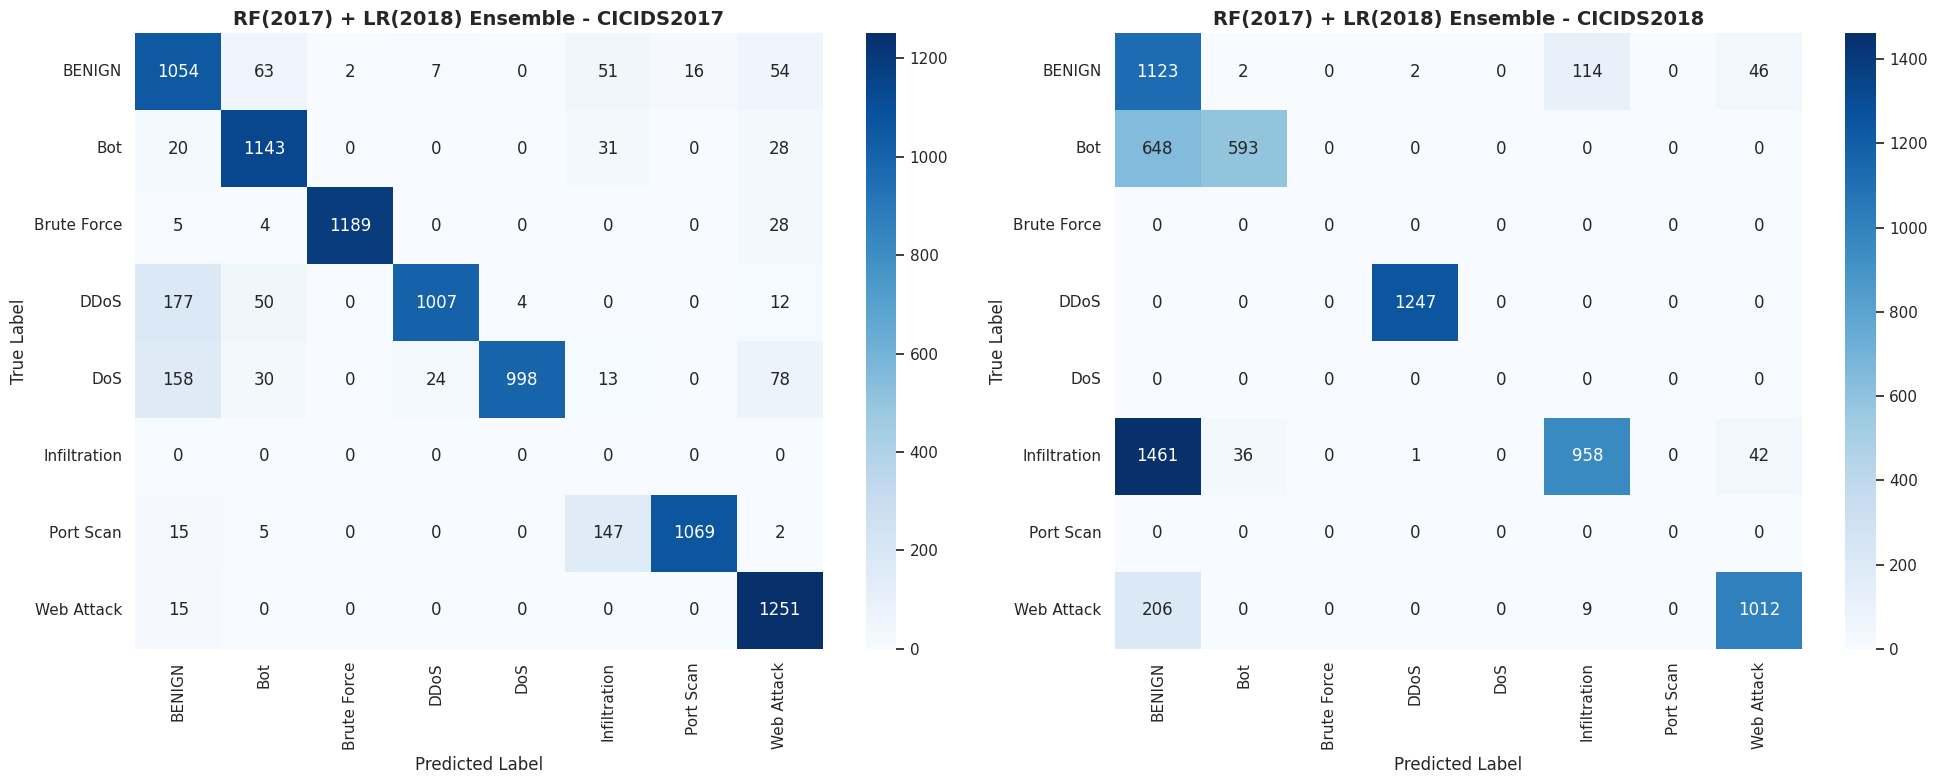


[6/36] Testing: RF(2017) + LGB(2018)

🔬 Running RF(2017) + LGB(2018) ensemble experiment...

📊 RF(2017) + LGB(2018) Ensemble on CICIDS2017
Accuracy: 0.9632
F1-Score (Macro): 0.8443
F1-Score (Weighted): 0.9647
Precision (Macro): 0.8470
Recall (Macro): 0.8431

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.84      0.97      0.90      1247
         Bot       0.99      0.98      0.99      1222
 Brute Force       1.00      0.97      0.98      1226
        DDoS       0.98      0.97      0.97      1250
         DoS       0.99      0.91      0.95      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.99      0.98      0.98      1238
  Web Attack       0.98      0.98      0.98      1266

    accuracy                           0.96      8750
   macro avg       0.85      0.84      0.84      8750
weighted avg       0.97      0.96      0.96      8750


📊 RF(2017) + LGB(2018) Ensemble on CICIDS2018
Accuracy: 

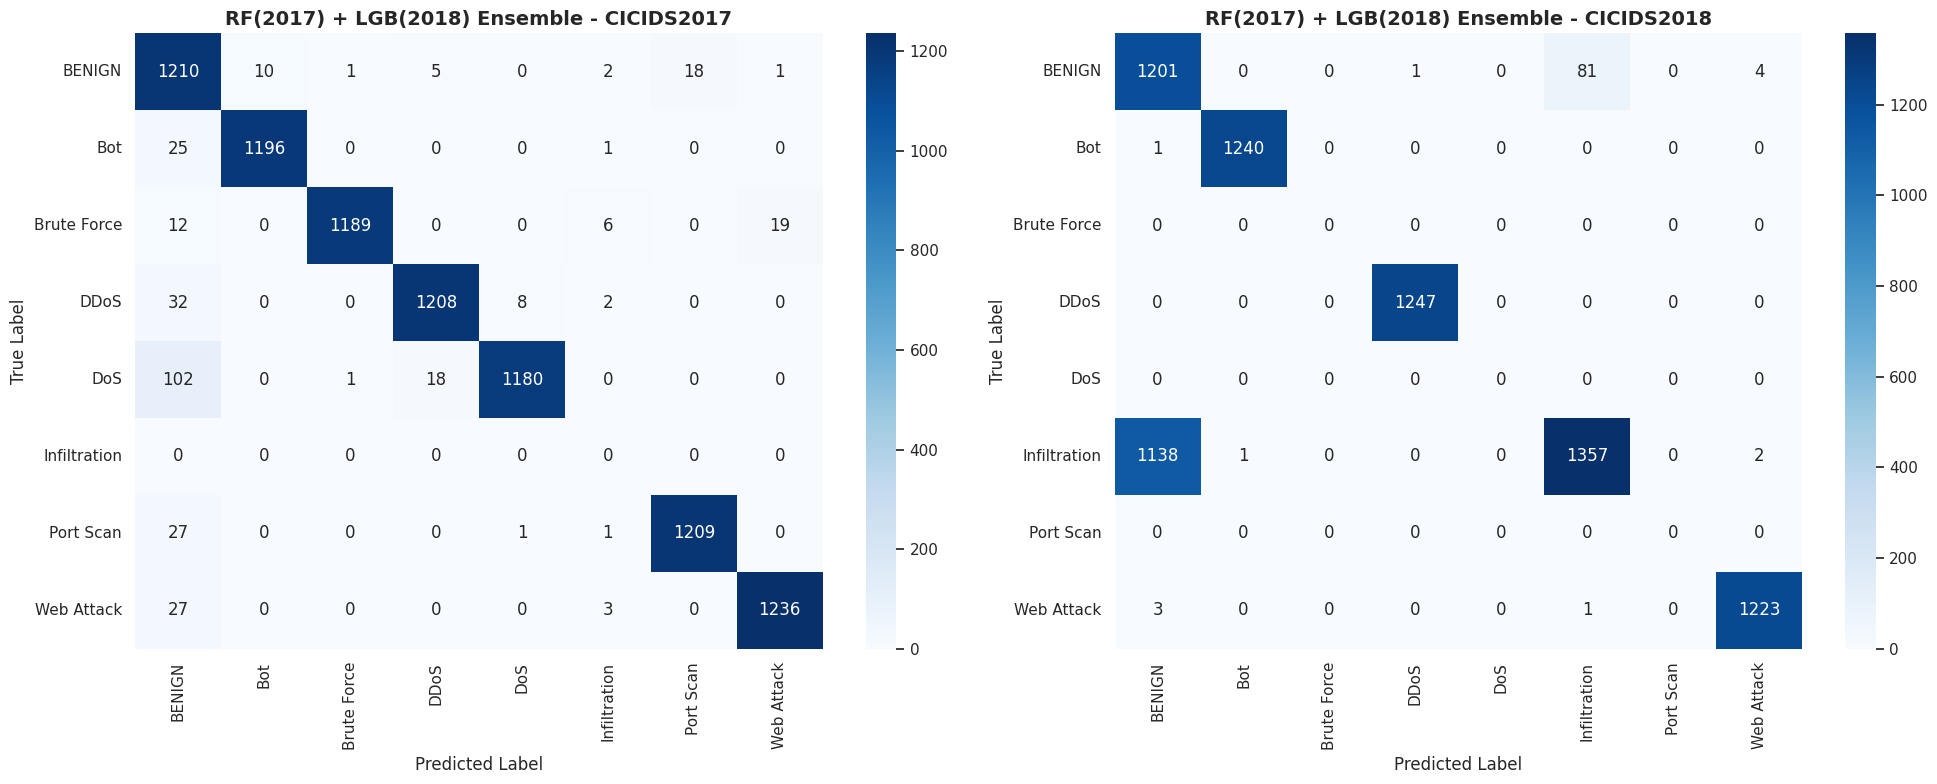


[7/36] Testing: DT(2017) + RF(2018)

🔬 Running DT(2017) + RF(2018) ensemble experiment...

📊 DT(2017) + RF(2018) Ensemble on CICIDS2017
Accuracy: 0.9747
F1-Score (Macro): 0.8532
F1-Score (Weighted): 0.9751
Precision (Macro): 0.8537
Recall (Macro): 0.8529

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.90      0.96      0.93      1247
         Bot       0.98      0.98      0.98      1222
 Brute Force       0.99      0.98      0.98      1226
        DDoS       0.99      0.99      0.99      1250
         DoS       0.99      0.97      0.98      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.99      0.96      0.97      1238
  Web Attack       0.99      0.98      0.99      1266

    accuracy                           0.97      8750
   macro avg       0.85      0.85      0.85      8750
weighted avg       0.98      0.97      0.98      8750


📊 DT(2017) + RF(2018) Ensemble on CICIDS2018
Accuracy: 0.54

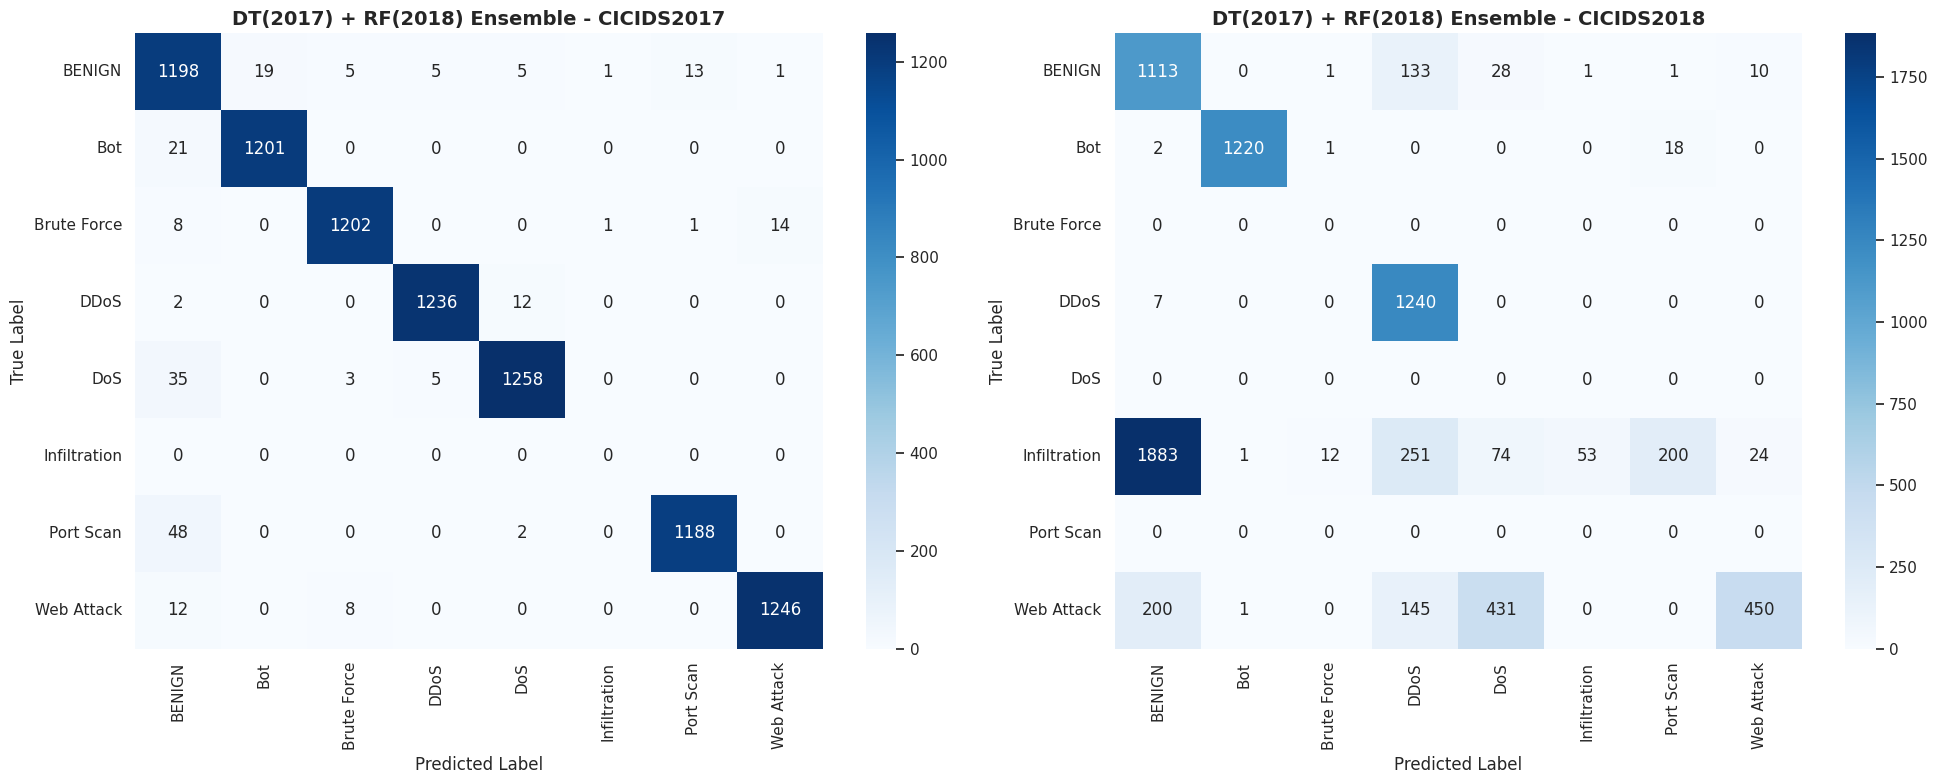


[8/36] Testing: DT(2017) + DT(2018)

🔬 Running DT(2017) + DT(2018) ensemble experiment...

📊 DT(2017) + DT(2018) Ensemble on CICIDS2017
Accuracy: 0.7599
F1-Score (Macro): 0.6858
F1-Score (Weighted): 0.7822
Precision (Macro): 0.7829
Recall (Macro): 0.6667

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.40      0.93      0.55      1247
         Bot       0.91      0.64      0.75      1222
 Brute Force       1.00      0.77      0.87      1226
        DDoS       0.99      0.77      0.87      1250
         DoS       0.98      0.35      0.52      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.99      0.98      0.98      1238
  Web Attack       1.00      0.90      0.95      1266

    accuracy                           0.76      8750
   macro avg       0.78      0.67      0.69      8750
weighted avg       0.90      0.76      0.78      8750


📊 DT(2017) + DT(2018) Ensemble on CICIDS2018
Accuracy: 0.55

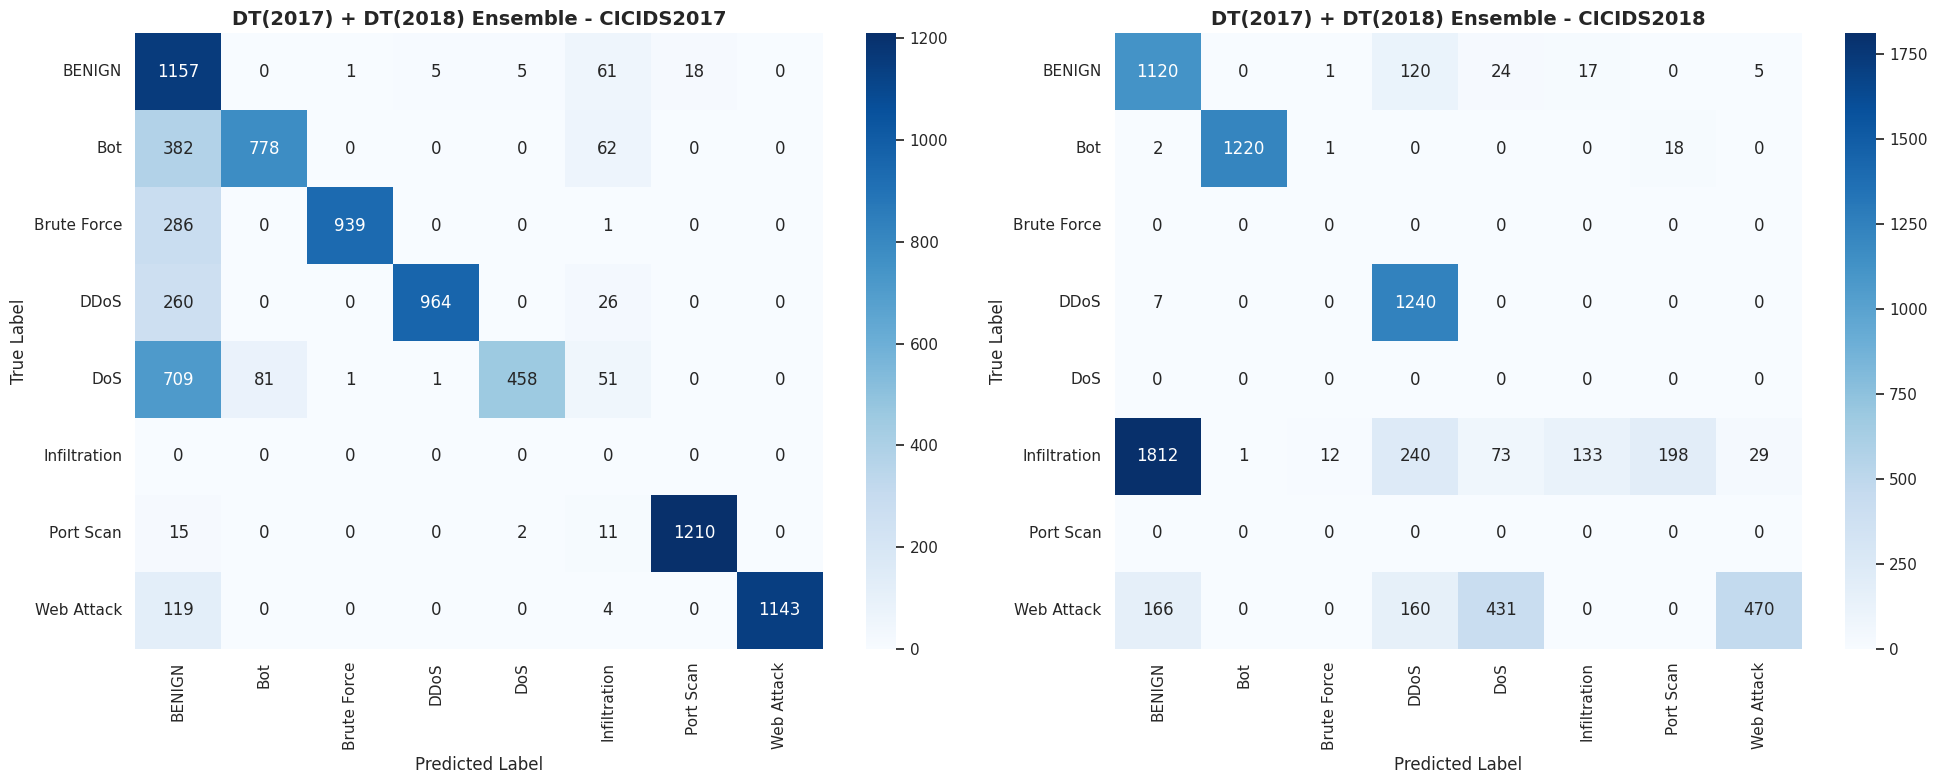


[9/36] Testing: DT(2017) + KNN(2018)

🔬 Running DT(2017) + KNN(2018) ensemble experiment...

📊 DT(2017) + KNN(2018) Ensemble on CICIDS2017
Accuracy: 0.8791
F1-Score (Macro): 0.8021
F1-Score (Weighted): 0.9162
Precision (Macro): 0.8415
Recall (Macro): 0.7700

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.84      0.89      0.86      1247
         Bot       0.98      0.92      0.95      1222
 Brute Force       1.00      0.97      0.98      1226
        DDoS       0.98      0.76      0.86      1250
         DoS       0.99      0.79      0.88      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       1.00      0.91      0.95      1238
  Web Attack       0.95      0.92      0.93      1266

    accuracy                           0.88      8750
   macro avg       0.84      0.77      0.80      8750
weighted avg       0.96      0.88      0.92      8750


📊 DT(2017) + KNN(2018) Ensemble on CICIDS2018
Accuracy: 

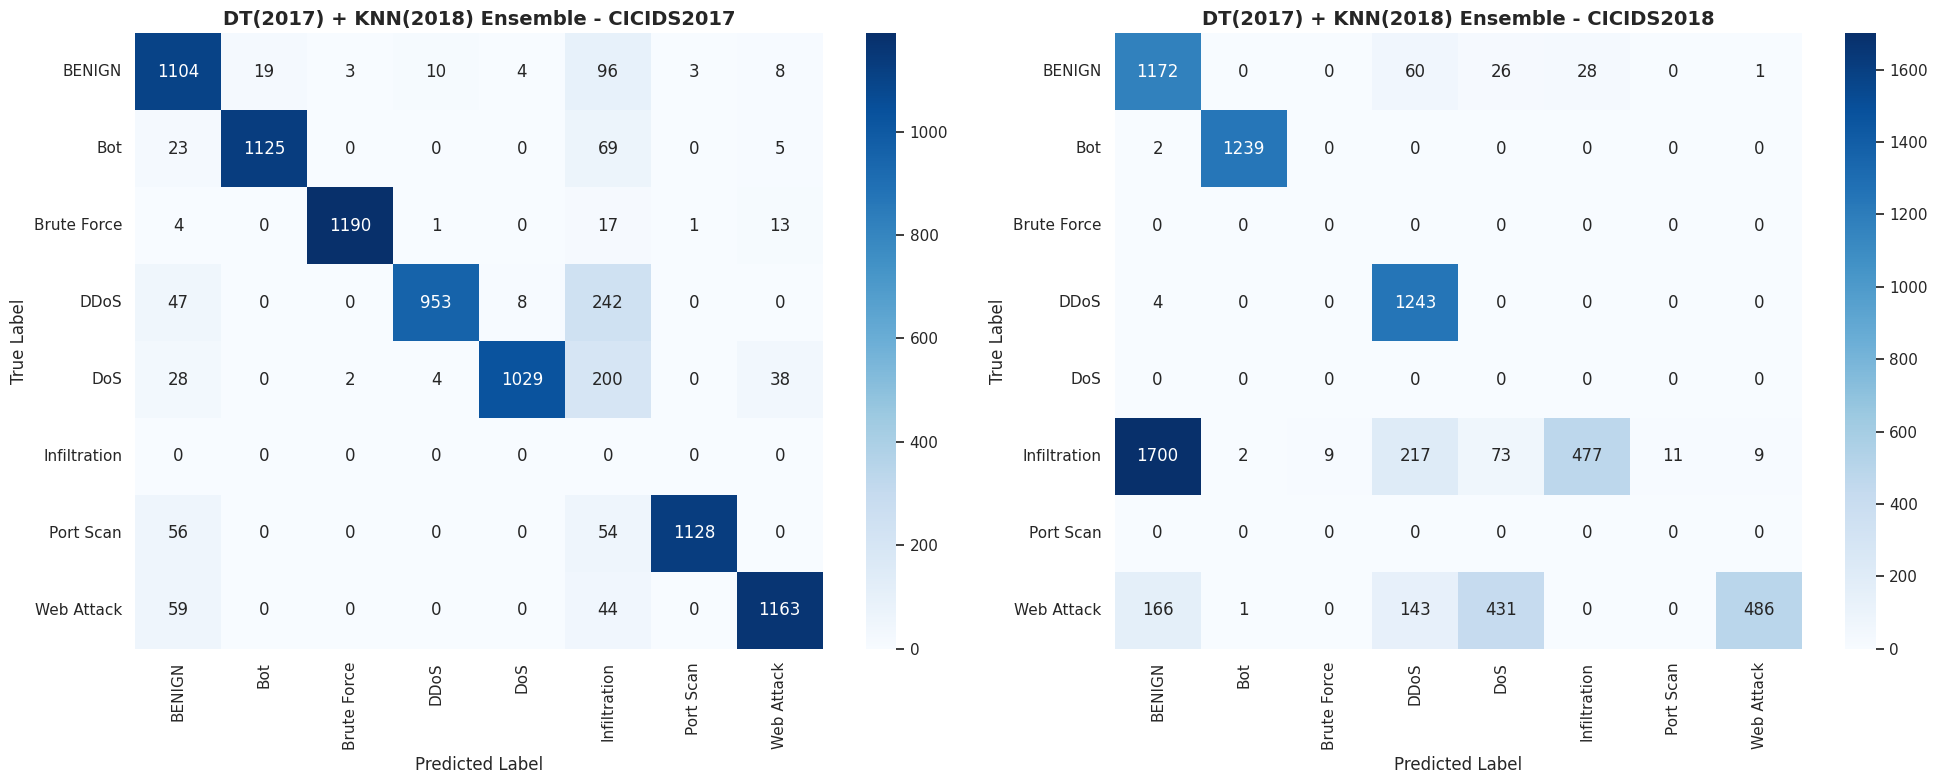


[10/36] Testing: DT(2017) + NB(2018)

🔬 Running DT(2017) + NB(2018) ensemble experiment...

📊 DT(2017) + NB(2018) Ensemble on CICIDS2017
Accuracy: 0.5641
F1-Score (Macro): 0.4962
F1-Score (Weighted): 0.5696
Precision (Macro): 0.7409
Recall (Macro): 0.4912

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.27      0.93      0.42      1247
         Bot       0.98      0.23      0.38      1222
 Brute Force       0.98      0.20      0.34      1226
        DDoS       1.00      0.25      0.40      1250
         DoS       0.99      0.63      0.77      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       1.00      0.75      0.86      1238
  Web Attack       0.71      0.92      0.81      1266

    accuracy                           0.56      8750
   macro avg       0.74      0.49      0.50      8750
weighted avg       0.85      0.56      0.57      8750


📊 DT(2017) + NB(2018) Ensemble on CICIDS2018
Accuracy: 0.4

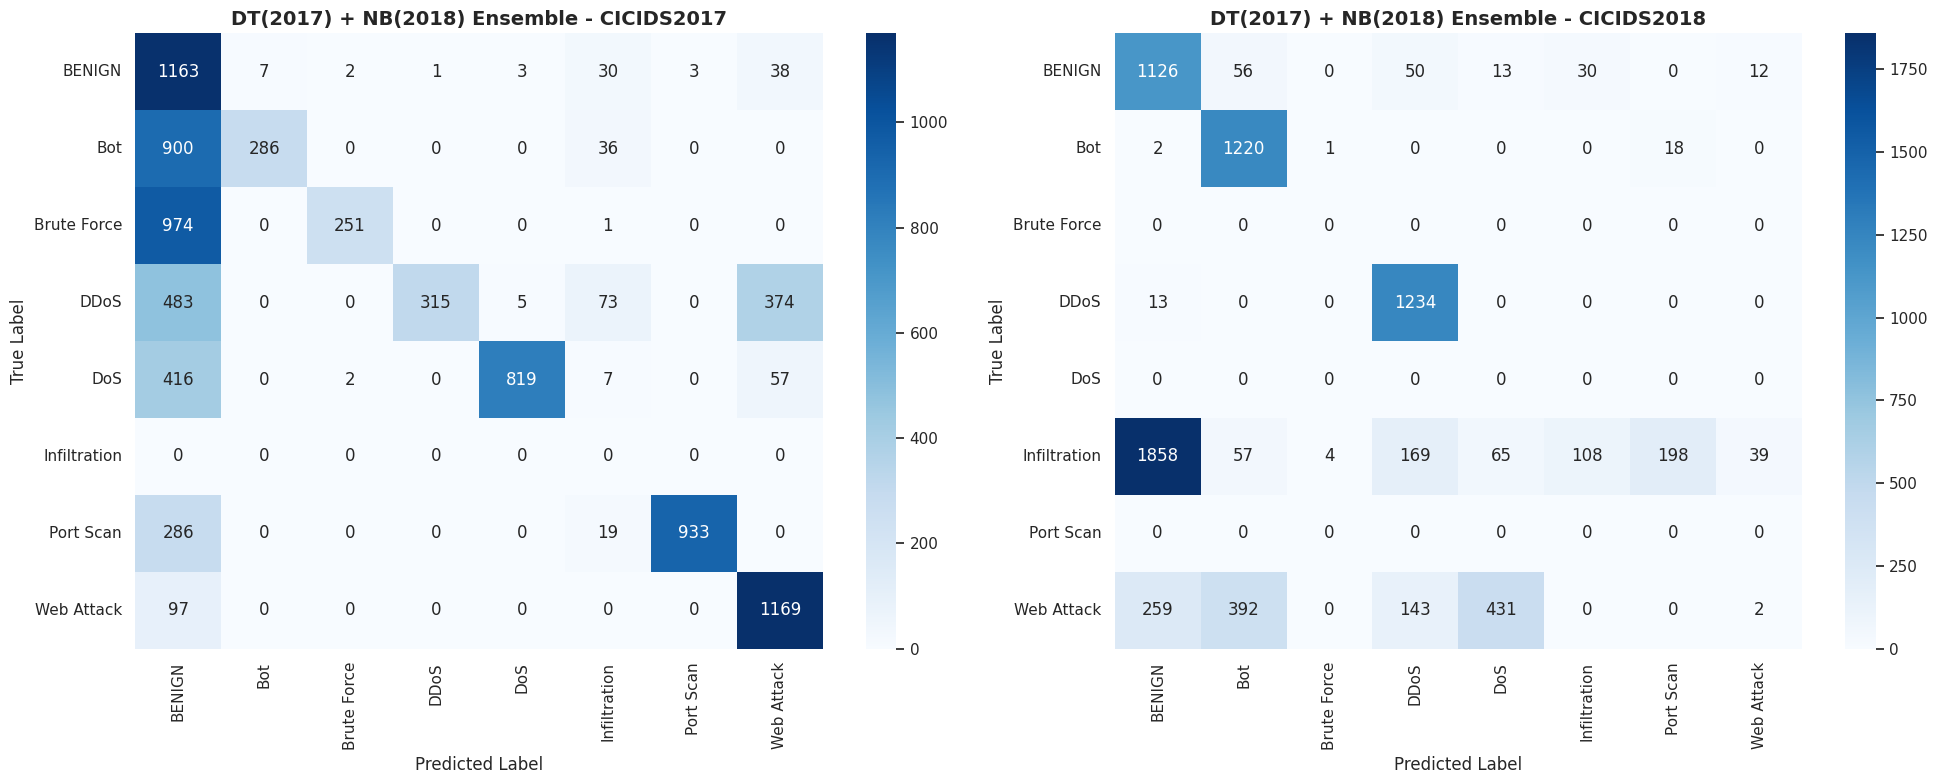


[11/36] Testing: DT(2017) + LR(2018)

🔬 Running DT(2017) + LR(2018) ensemble experiment...

📊 DT(2017) + LR(2018) Ensemble on CICIDS2017
Accuracy: 0.9310
F1-Score (Macro): 0.8218
F1-Score (Weighted): 0.9390
Precision (Macro): 0.8309
Recall (Macro): 0.8149

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.86      0.86      0.86      1247
         Bot       0.94      0.95      0.94      1222
 Brute Force       1.00      0.97      0.98      1226
        DDoS       0.99      0.93      0.96      1250
         DoS       0.99      0.88      0.93      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       1.00      0.94      0.97      1238
  Web Attack       0.88      0.99      0.93      1266

    accuracy                           0.93      8750
   macro avg       0.83      0.81      0.82      8750
weighted avg       0.95      0.93      0.94      8750


📊 DT(2017) + LR(2018) Ensemble on CICIDS2018
Accuracy: 0.3

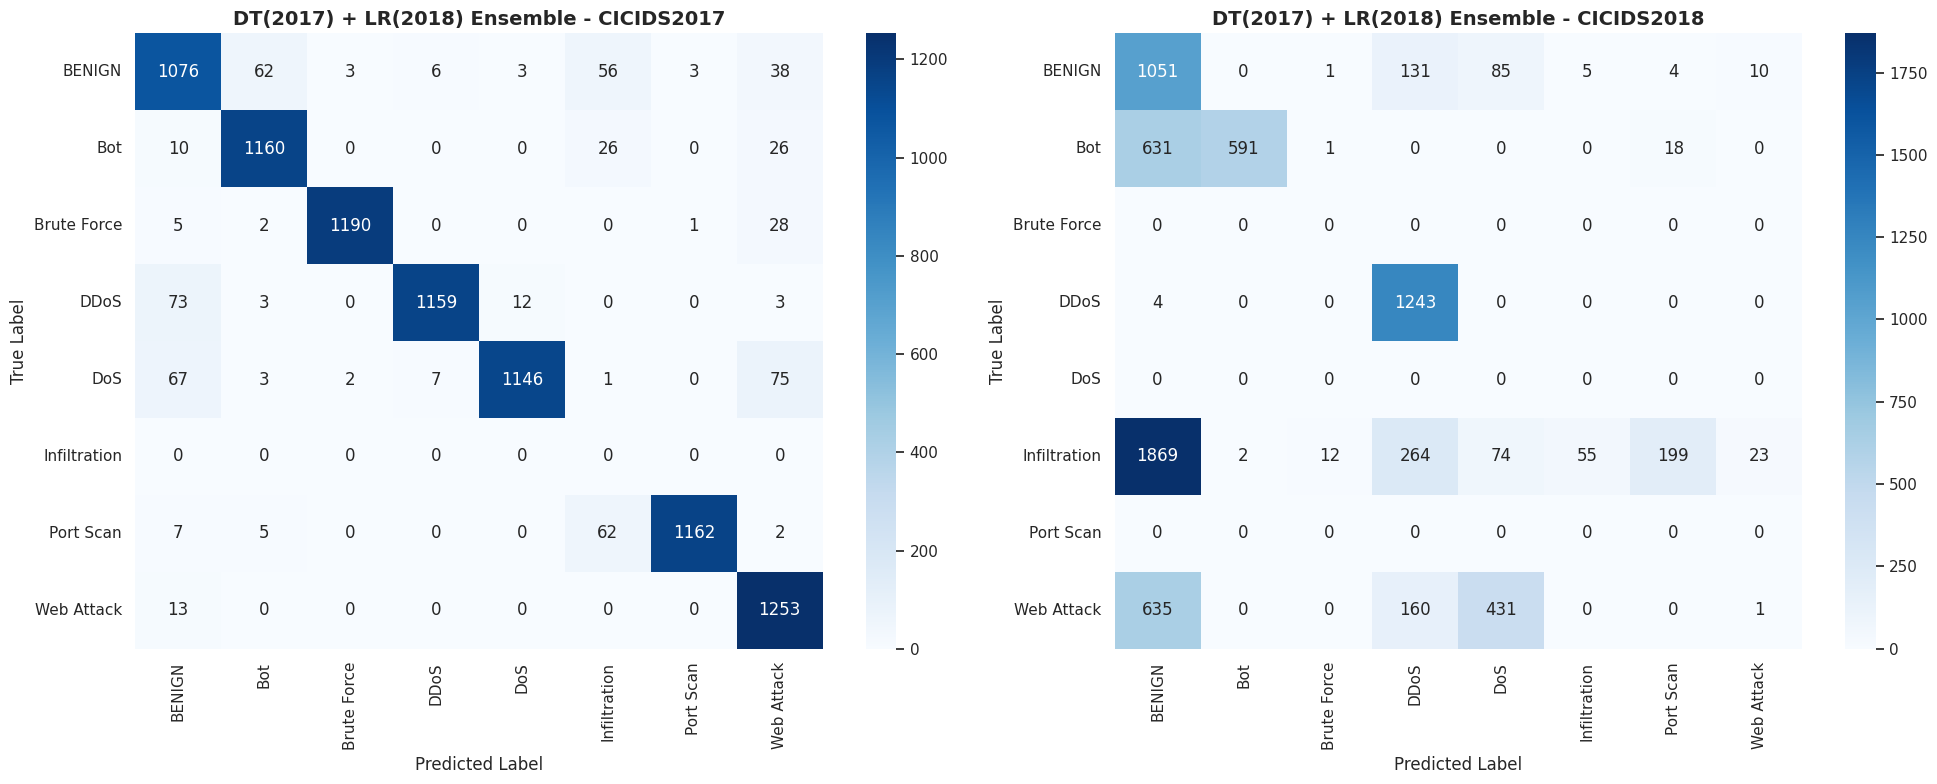


[12/36] Testing: DT(2017) + LGB(2018)

🔬 Running DT(2017) + LGB(2018) ensemble experiment...

📊 DT(2017) + LGB(2018) Ensemble on CICIDS2017
Accuracy: 0.9721
F1-Score (Macro): 0.8520
F1-Score (Weighted): 0.9737
Precision (Macro): 0.8540
Recall (Macro): 0.8506

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.89      0.97      0.93      1247
         Bot       0.98      0.98      0.98      1222
 Brute Force       0.99      0.97      0.98      1226
        DDoS       0.99      0.99      0.99      1250
         DoS       0.99      0.96      0.97      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.99      0.95      0.97      1238
  Web Attack       0.99      0.98      0.98      1266

    accuracy                           0.97      8750
   macro avg       0.85      0.85      0.85      8750
weighted avg       0.98      0.97      0.97      8750


📊 DT(2017) + LGB(2018) Ensemble on CICIDS2018
Accuracy:

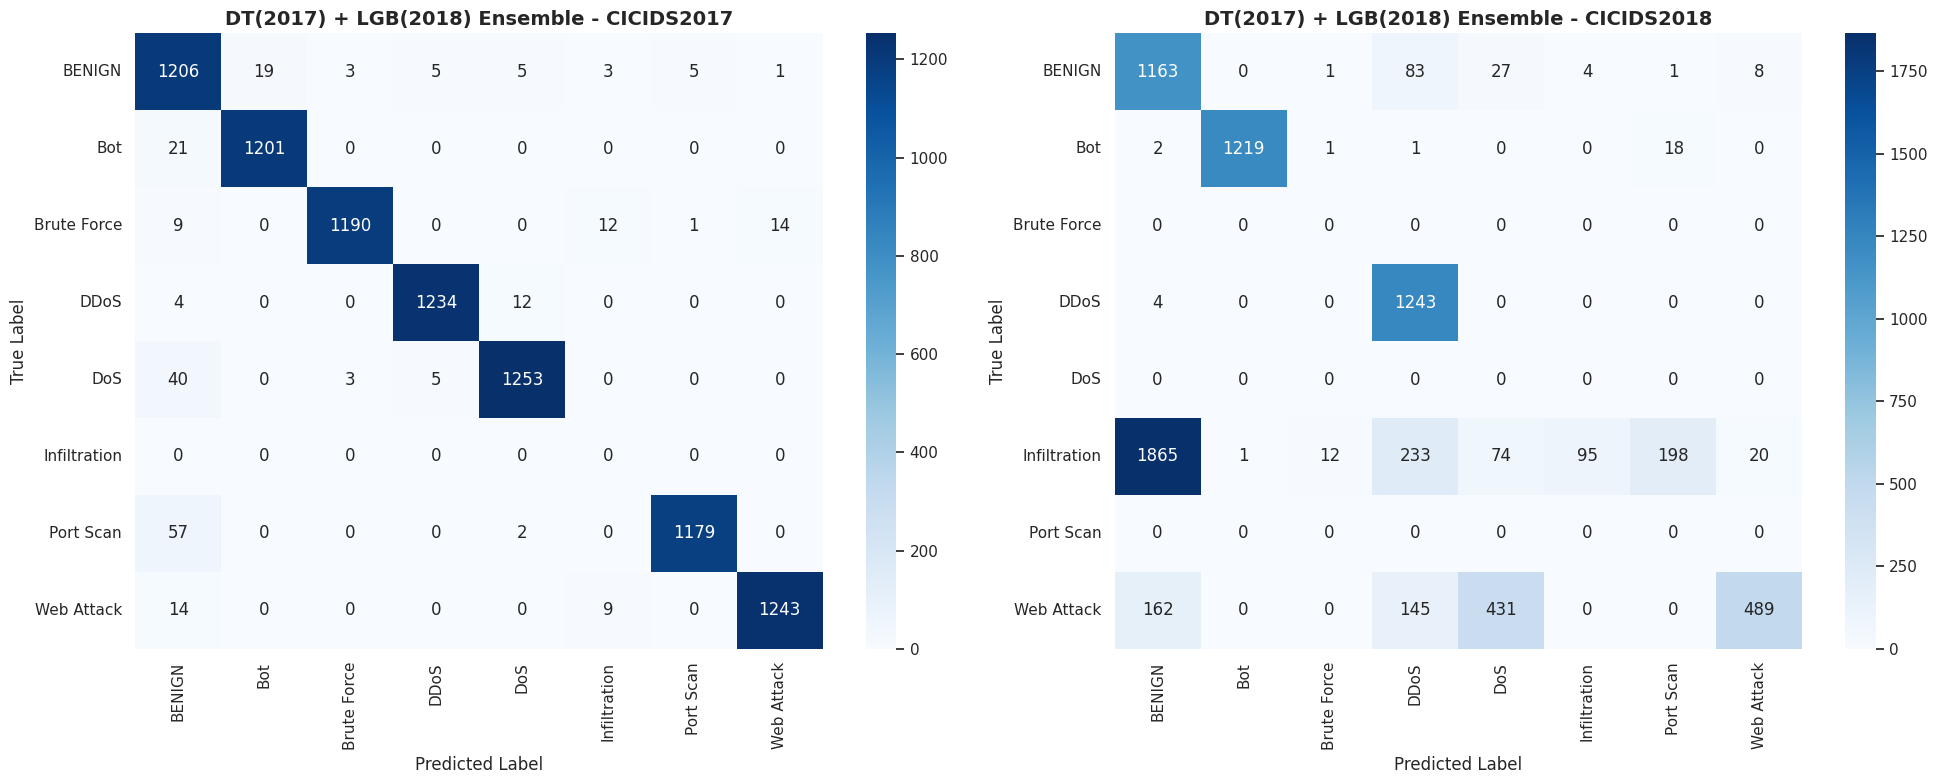


[13/36] Testing: KNN(2017) + RF(2018)

🔬 Running KNN(2017) + RF(2018) ensemble experiment...

📊 KNN(2017) + RF(2018) Ensemble on CICIDS2017
Accuracy: 0.9805
F1-Score (Macro): 0.8588
F1-Score (Weighted): 0.9815
Precision (Macro): 0.8598
Recall (Macro): 0.8579

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.96      0.95      0.95      1247
         Bot       0.98      1.00      0.99      1222
 Brute Force       1.00      0.98      0.99      1226
        DDoS       1.00      0.99      0.99      1250
         DoS       0.98      0.98      0.98      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.99      0.98      0.98      1238
  Web Attack       0.98      1.00      0.99      1266

    accuracy                           0.98      8750
   macro avg       0.86      0.86      0.86      8750
weighted avg       0.98      0.98      0.98      8750


📊 KNN(2017) + RF(2018) Ensemble on CICIDS2018
Accuracy:

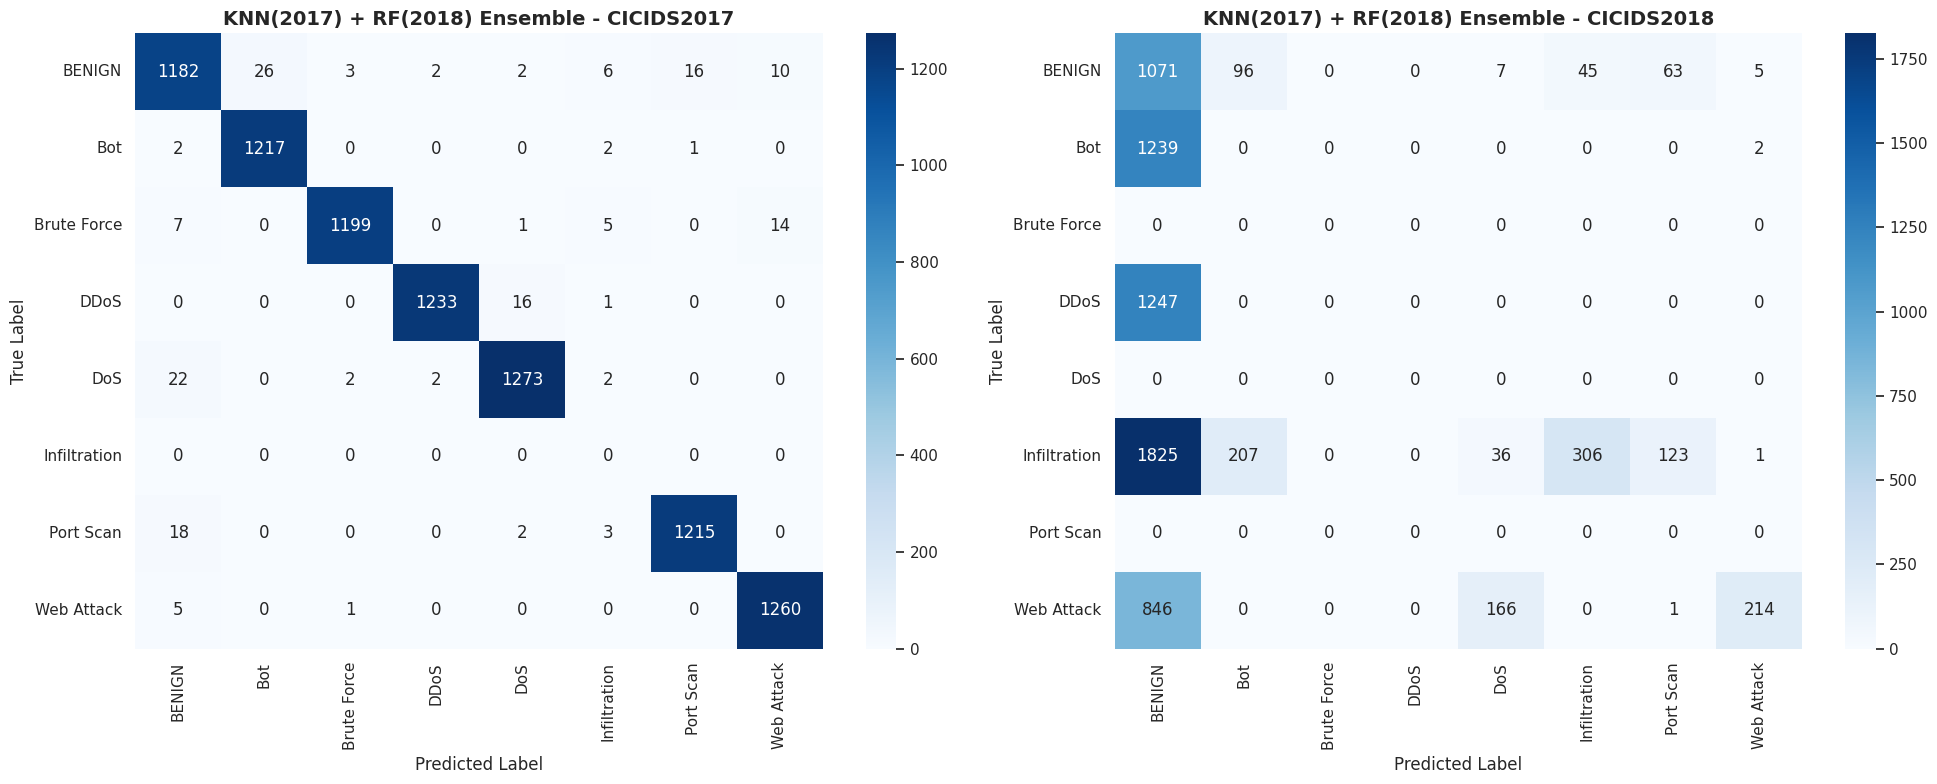


[14/36] Testing: KNN(2017) + DT(2018)

🔬 Running KNN(2017) + DT(2018) ensemble experiment...

📊 KNN(2017) + DT(2018) Ensemble on CICIDS2017
Accuracy: 0.7761
F1-Score (Macro): 0.6978
F1-Score (Weighted): 0.7961
Precision (Macro): 0.7850
Recall (Macro): 0.6808

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.40      0.94      0.56      1247
         Bot       0.91      0.68      0.78      1222
 Brute Force       1.00      0.76      0.87      1226
        DDoS       1.00      0.79      0.88      1250
         DoS       0.99      0.39      0.56      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.98      0.97      0.98      1238
  Web Attack       1.00      0.91      0.95      1266

    accuracy                           0.78      8750
   macro avg       0.79      0.68      0.70      8750
weighted avg       0.90      0.78      0.80      8750


📊 KNN(2017) + DT(2018) Ensemble on CICIDS2018
Accuracy:

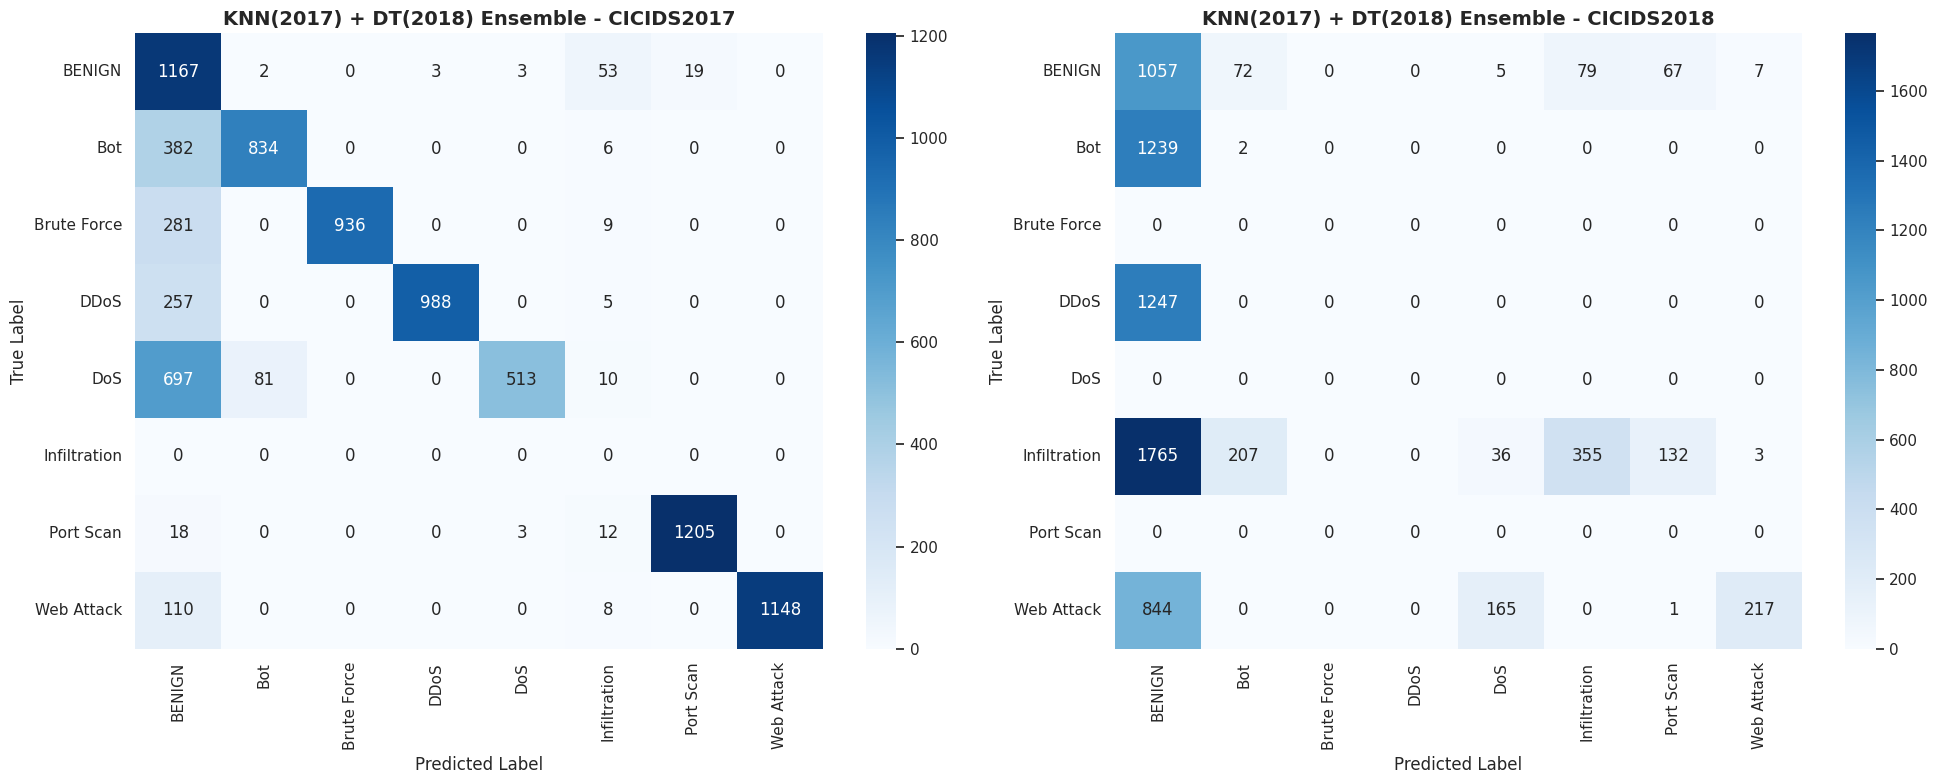


[15/36] Testing: KNN(2017) + KNN(2018)

🔬 Running KNN(2017) + KNN(2018) ensemble experiment...

📊 KNN(2017) + KNN(2018) Ensemble on CICIDS2017
Accuracy: 0.9378
F1-Score (Macro): 0.8320
F1-Score (Weighted): 0.9508
Precision (Macro): 0.8456
Recall (Macro): 0.8207

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.82      0.93      0.87      1247
         Bot       0.98      0.97      0.98      1222
 Brute Force       1.00      0.97      0.98      1226
        DDoS       0.99      0.94      0.97      1250
         DoS       0.99      0.96      0.97      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       1.00      0.88      0.93      1238
  Web Attack       0.98      0.91      0.94      1266

    accuracy                           0.94      8750
   macro avg       0.85      0.82      0.83      8750
weighted avg       0.97      0.94      0.95      8750


📊 KNN(2017) + KNN(2018) Ensemble on CICIDS2018
Accur

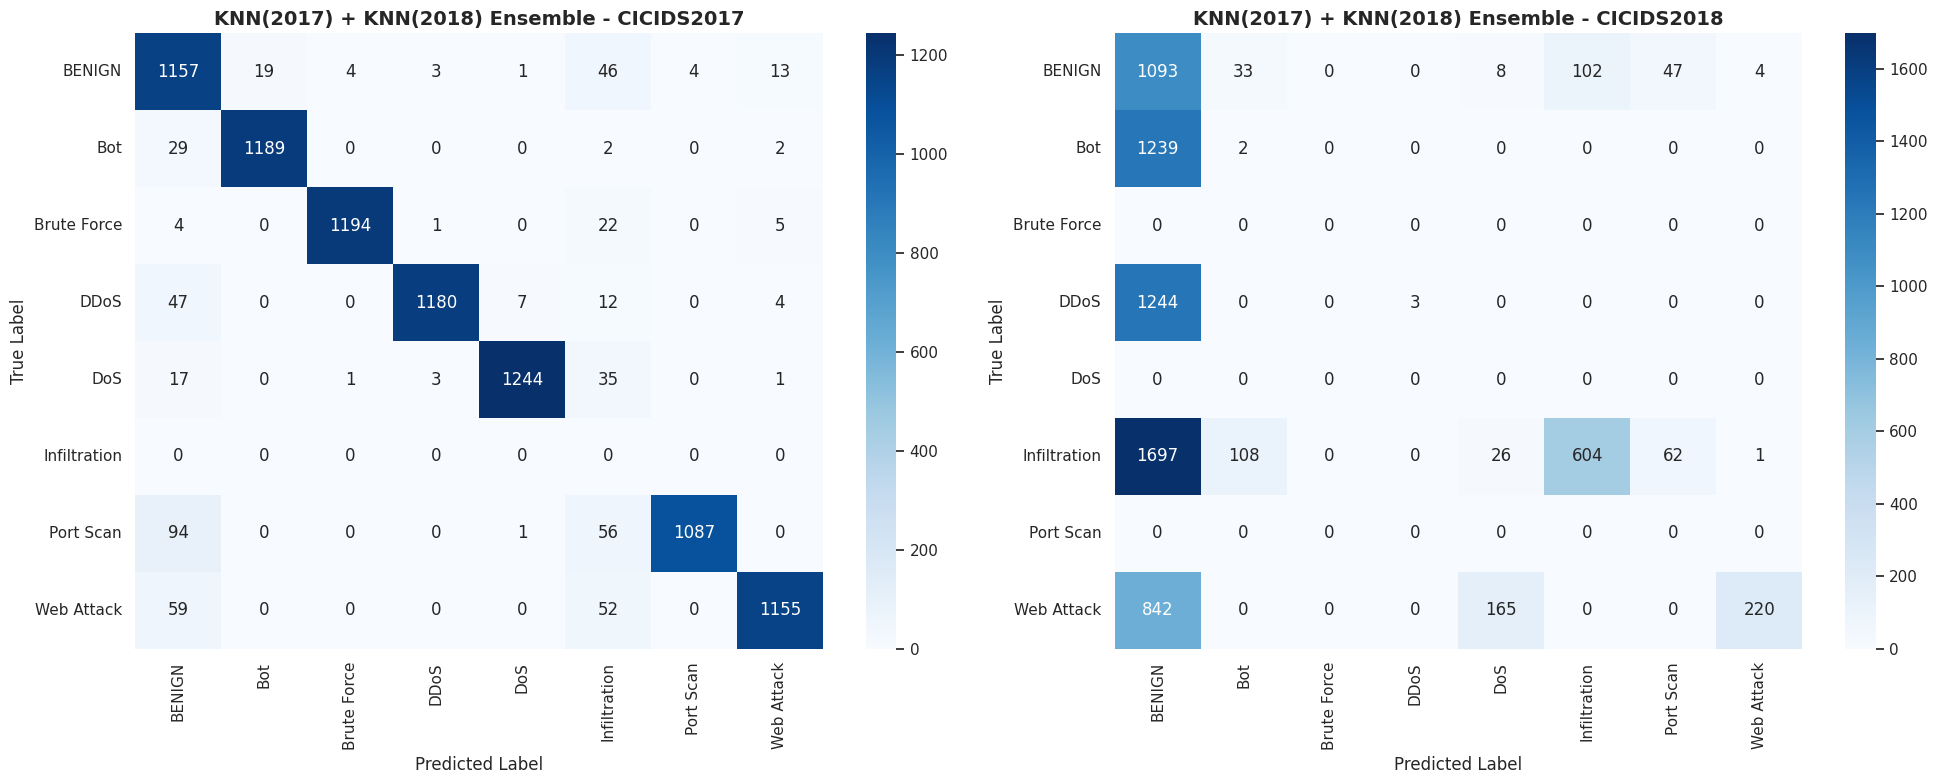


[16/36] Testing: KNN(2017) + NB(2018)

🔬 Running KNN(2017) + NB(2018) ensemble experiment...

📊 KNN(2017) + NB(2018) Ensemble on CICIDS2017
Accuracy: 0.9571
F1-Score (Macro): 0.8405
F1-Score (Weighted): 0.9605
Precision (Macro): 0.8460
Recall (Macro): 0.8375

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.81      0.97      0.88      1247
         Bot       1.00      0.97      0.98      1222
 Brute Force       1.00      0.97      0.98      1226
        DDoS       1.00      0.98      0.99      1250
         DoS       1.00      0.95      0.97      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       1.00      0.90      0.95      1238
  Web Attack       0.97      0.96      0.96      1266

    accuracy                           0.96      8750
   macro avg       0.85      0.84      0.84      8750
weighted avg       0.97      0.96      0.96      8750


📊 KNN(2017) + NB(2018) Ensemble on CICIDS2018
Accuracy:

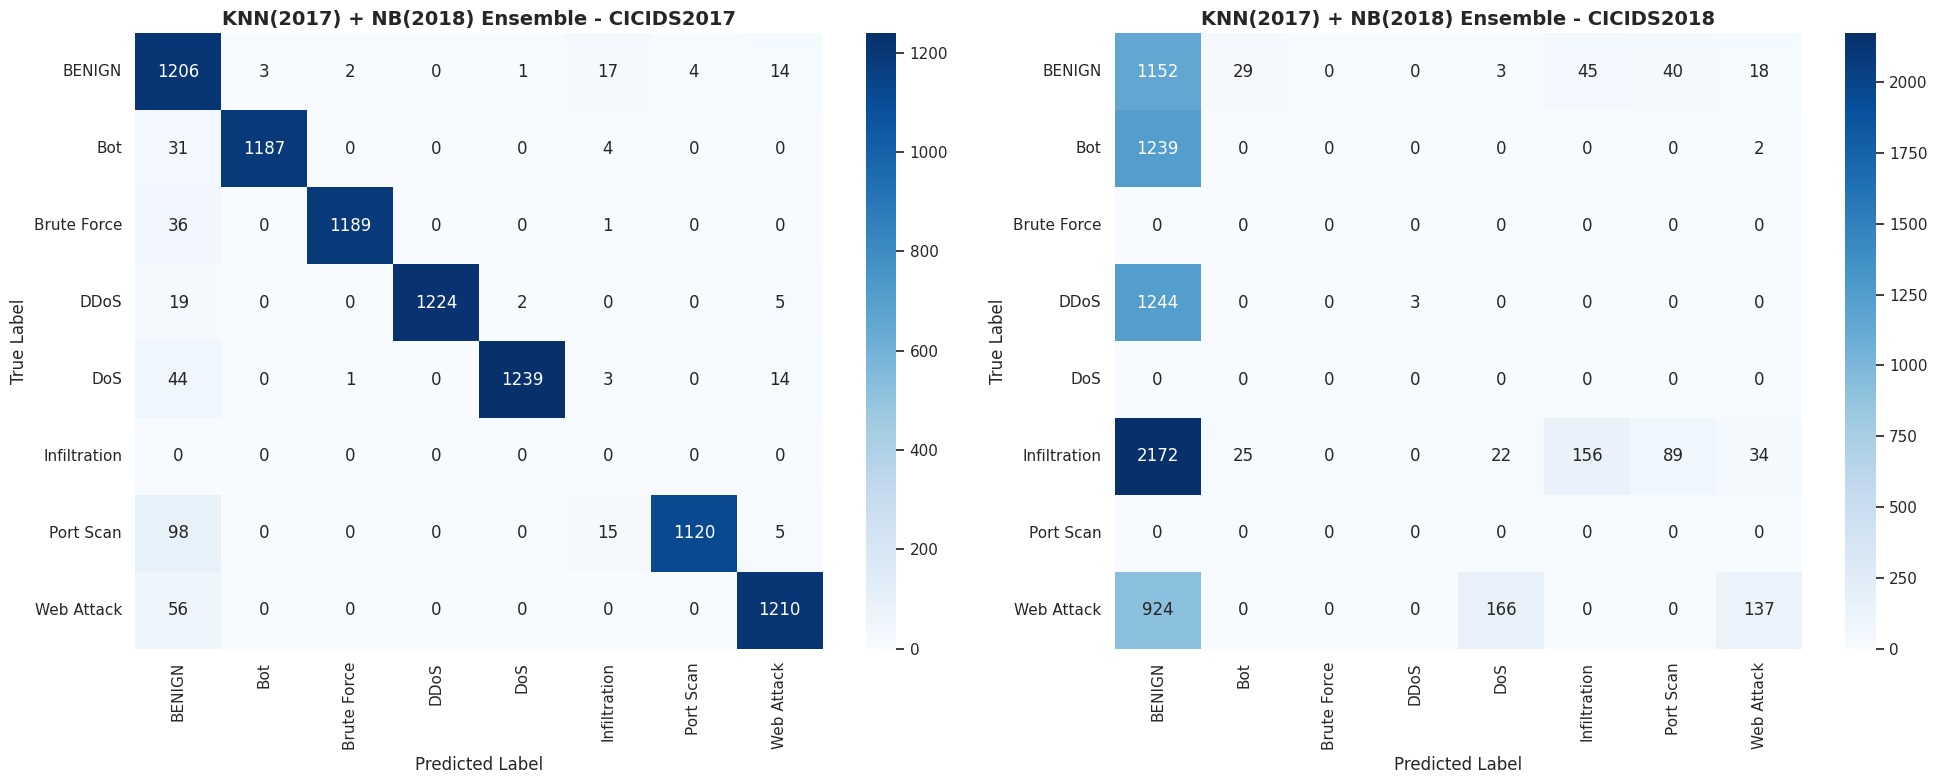


[17/36] Testing: KNN(2017) + LR(2018)

🔬 Running KNN(2017) + LR(2018) ensemble experiment...

📊 KNN(2017) + LR(2018) Ensemble on CICIDS2017
Accuracy: 0.9616
F1-Score (Macro): 0.8476
F1-Score (Weighted): 0.9687
Precision (Macro): 0.8546
Recall (Macro): 0.8414

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.95      0.91      0.93      1247
         Bot       0.97      0.99      0.98      1222
 Brute Force       1.00      0.97      0.98      1226
        DDoS       0.99      0.98      0.99      1250
         DoS       1.00      0.96      0.98      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.99      0.93      0.96      1238
  Web Attack       0.93      0.99      0.96      1266

    accuracy                           0.96      8750
   macro avg       0.85      0.84      0.85      8750
weighted avg       0.98      0.96      0.97      8750


📊 KNN(2017) + LR(2018) Ensemble on CICIDS2018
Accuracy:

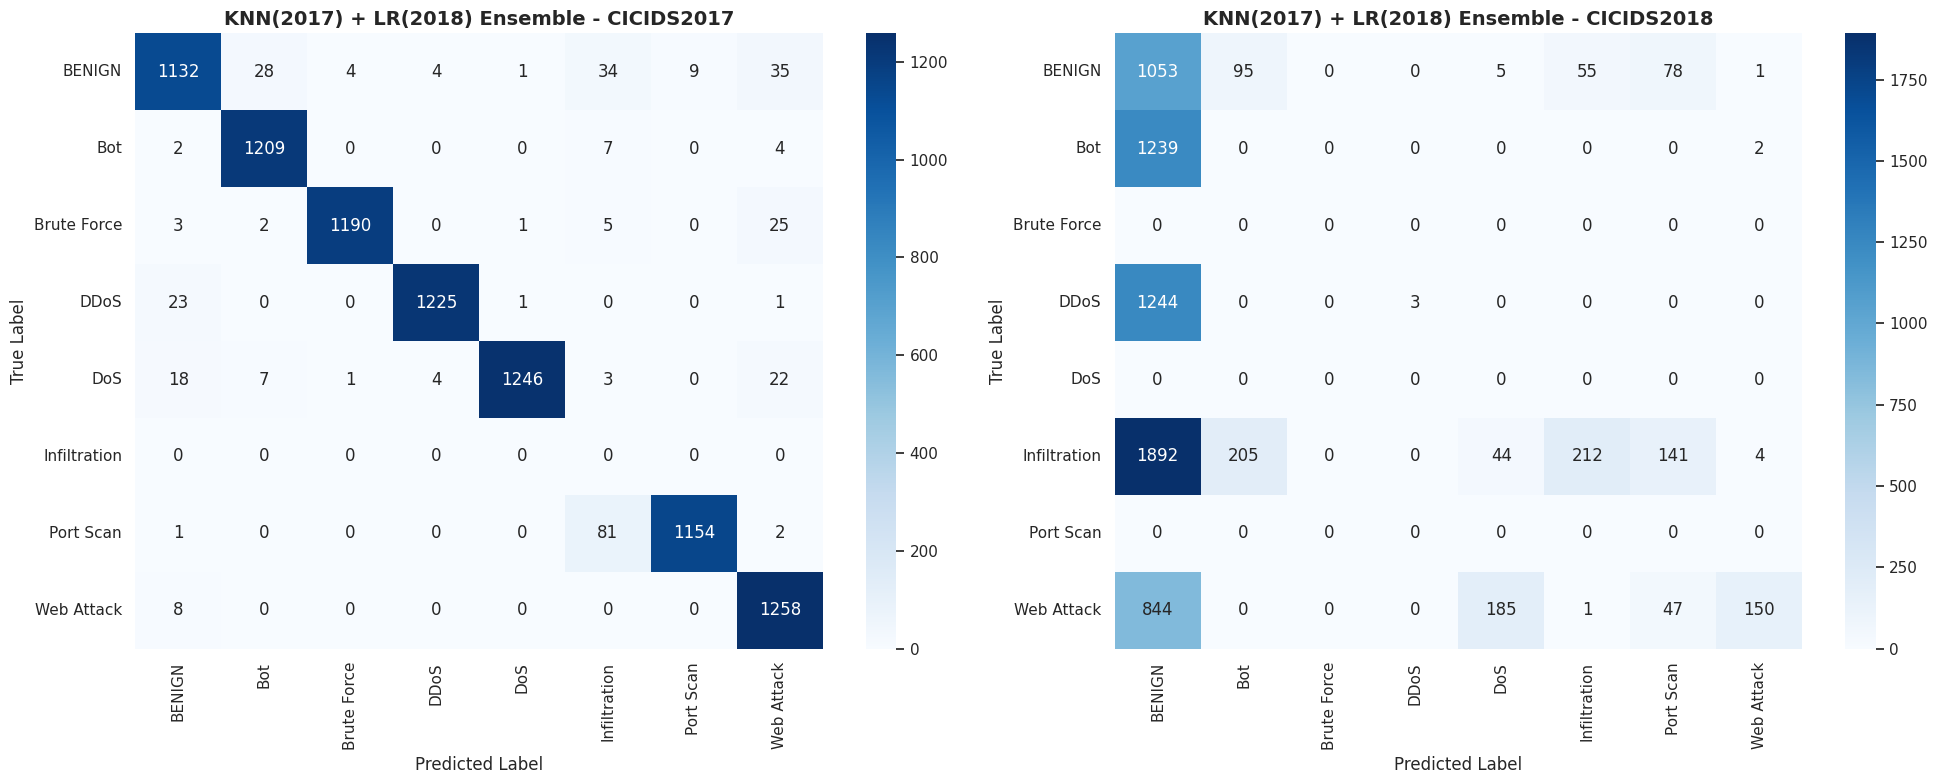


[18/36] Testing: KNN(2017) + LGB(2018)

🔬 Running KNN(2017) + LGB(2018) ensemble experiment...

📊 KNN(2017) + LGB(2018) Ensemble on CICIDS2017
Accuracy: 0.9728
F1-Score (Macro): 0.8520
F1-Score (Weighted): 0.9737
Precision (Macro): 0.8536
Recall (Macro): 0.8512

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.89      0.97      0.93      1247
         Bot       0.99      0.98      0.99      1222
 Brute Force       1.00      0.98      0.99      1226
        DDoS       0.99      0.99      0.99      1250
         DoS       0.99      0.97      0.98      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.99      0.93      0.96      1238
  Web Attack       0.98      0.99      0.99      1266

    accuracy                           0.97      8750
   macro avg       0.85      0.85      0.85      8750
weighted avg       0.98      0.97      0.97      8750


📊 KNN(2017) + LGB(2018) Ensemble on CICIDS2018
Accur

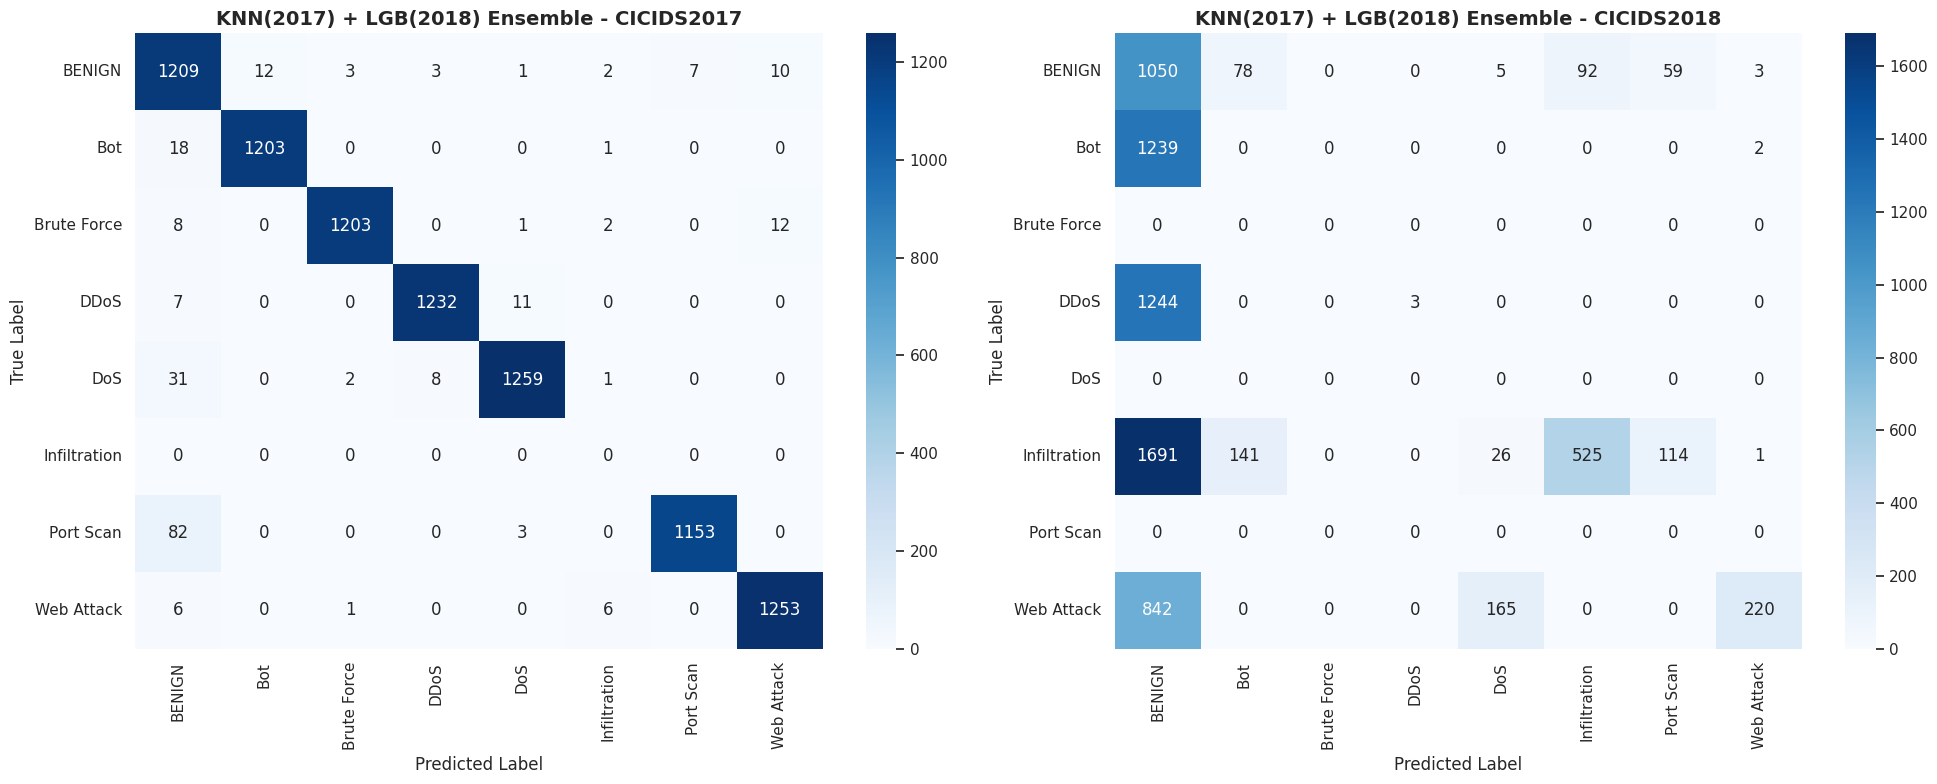


[19/36] Testing: NB(2017) + RF(2018)

🔬 Running NB(2017) + RF(2018) ensemble experiment...

📊 NB(2017) + RF(2018) Ensemble on CICIDS2017
Accuracy: 0.8000
F1-Score (Macro): 0.6926
F1-Score (Weighted): 0.7928
Precision (Macro): 0.7073
Recall (Macro): 0.6993

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.88      0.71      0.79      1247
         Bot       0.58      0.36      0.45      1222
 Brute Force       0.92      0.97      0.94      1226
        DDoS       0.83      0.93      0.88      1250
         DoS       0.89      0.80      0.84      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.61      0.97      0.75      1238
  Web Attack       0.96      0.85      0.90      1266

    accuracy                           0.80      8750
   macro avg       0.71      0.70      0.69      8750
weighted avg       0.81      0.80      0.79      8750


📊 NB(2017) + RF(2018) Ensemble on CICIDS2018
Accuracy: 0.4

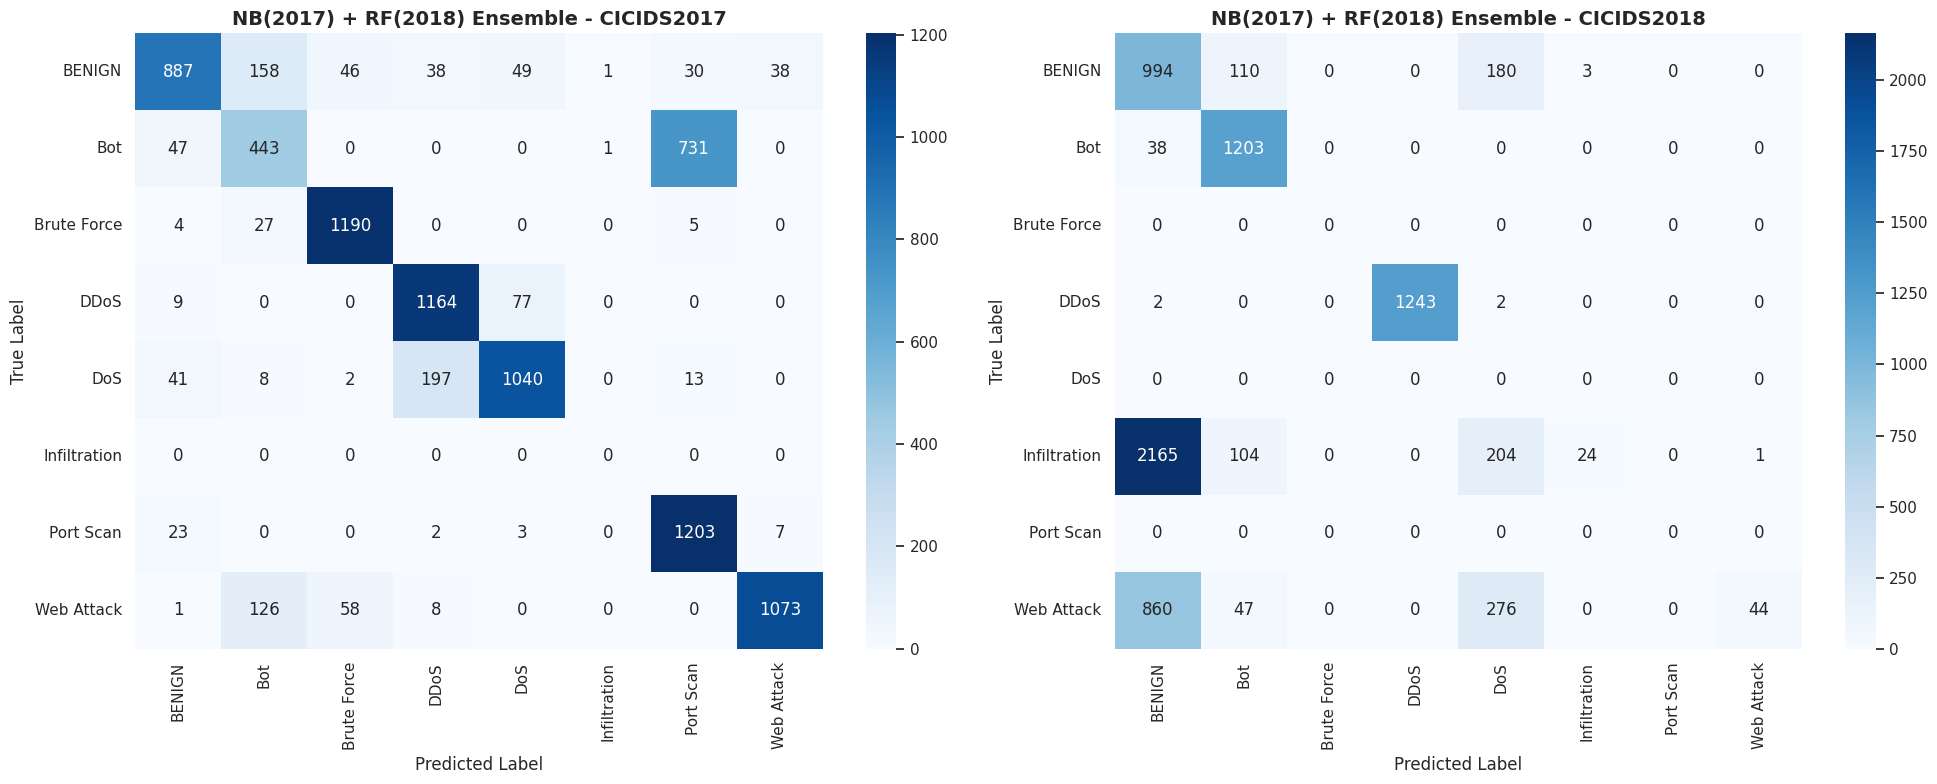


[20/36] Testing: NB(2017) + DT(2018)

🔬 Running NB(2017) + DT(2018) ensemble experiment...

📊 NB(2017) + DT(2018) Ensemble on CICIDS2017
Accuracy: 0.5834
F1-Score (Macro): 0.4984
F1-Score (Weighted): 0.5700
Precision (Macro): 0.6015
Recall (Macro): 0.5107

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.36      0.79      0.49      1247
         Bot       0.29      0.06      0.10      1222
 Brute Force       0.94      0.49      0.64      1226
        DDoS       0.83      0.75      0.79      1250
         DoS       0.87      0.22      0.35      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.60      0.93      0.73      1238
  Web Attack       0.93      0.85      0.89      1266

    accuracy                           0.58      8750
   macro avg       0.60      0.51      0.50      8750
weighted avg       0.69      0.58      0.57      8750


📊 NB(2017) + DT(2018) Ensemble on CICIDS2018
Accuracy: 0.4

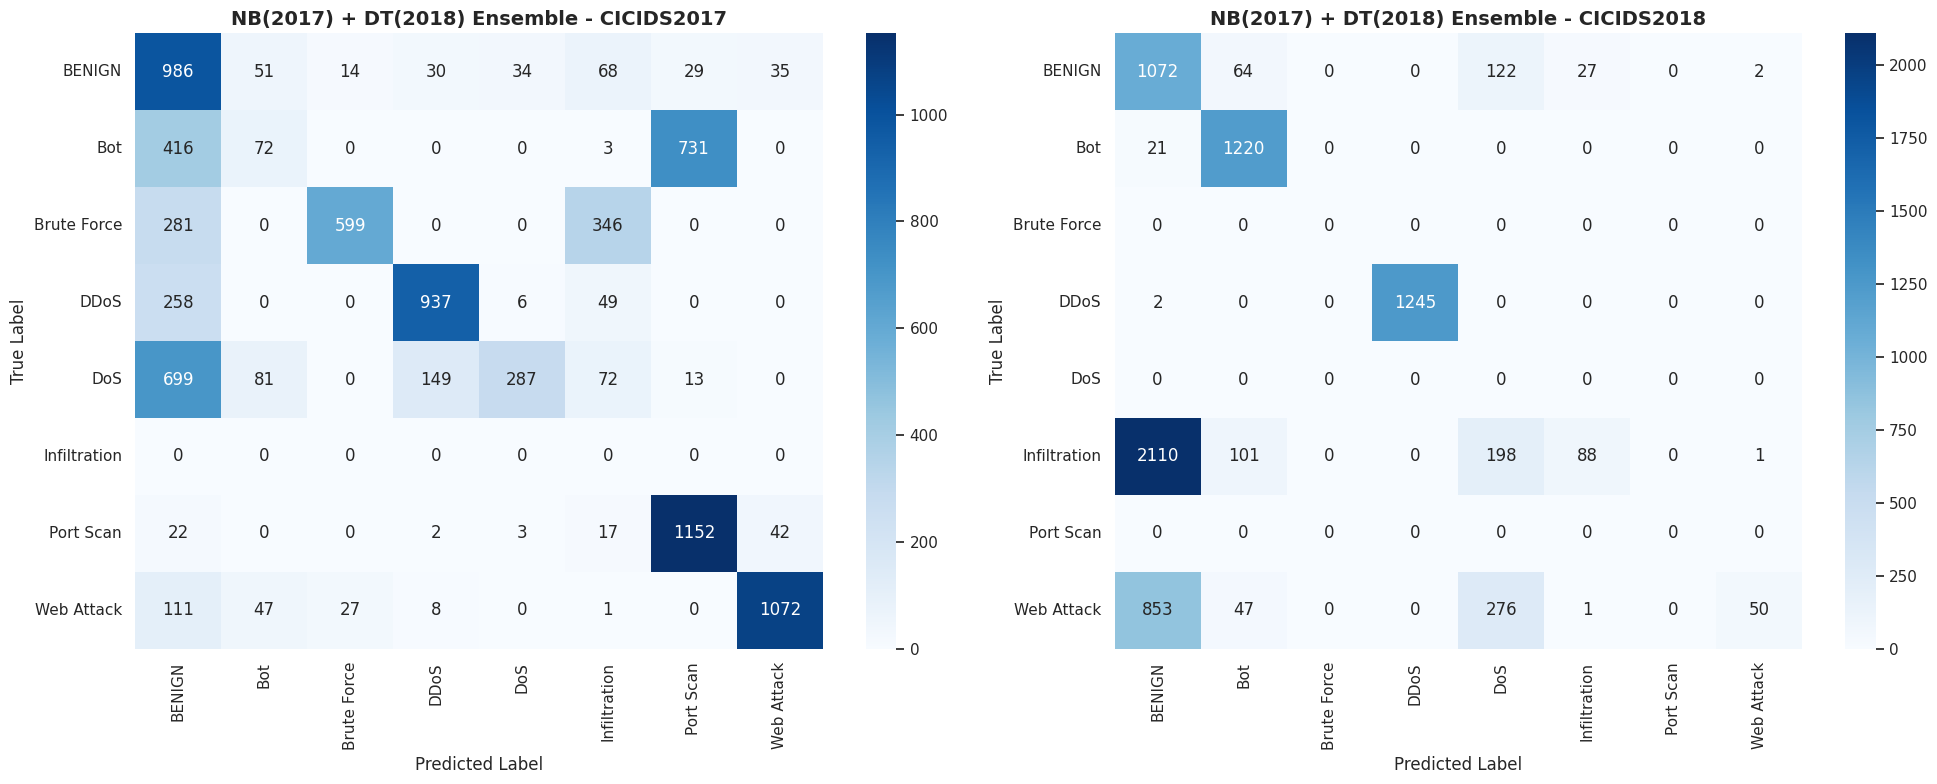


[21/36] Testing: NB(2017) + KNN(2018)

🔬 Running NB(2017) + KNN(2018) ensemble experiment...

📊 NB(2017) + KNN(2018) Ensemble on CICIDS2017
Accuracy: 0.7297
F1-Score (Macro): 0.6577
F1-Score (Weighted): 0.7525
Precision (Macro): 0.7107
Recall (Macro): 0.6382

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.79      0.71      0.75      1247
         Bot       0.64      0.29      0.40      1222
 Brute Force       0.97      0.97      0.97      1226
        DDoS       0.87      0.70      0.78      1250
         DoS       0.91      0.67      0.77      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.60      0.93      0.73      1238
  Web Attack       0.91      0.85      0.88      1266

    accuracy                           0.73      8750
   macro avg       0.71      0.64      0.66      8750
weighted avg       0.81      0.73      0.75      8750


📊 NB(2017) + KNN(2018) Ensemble on CICIDS2018
Accuracy:

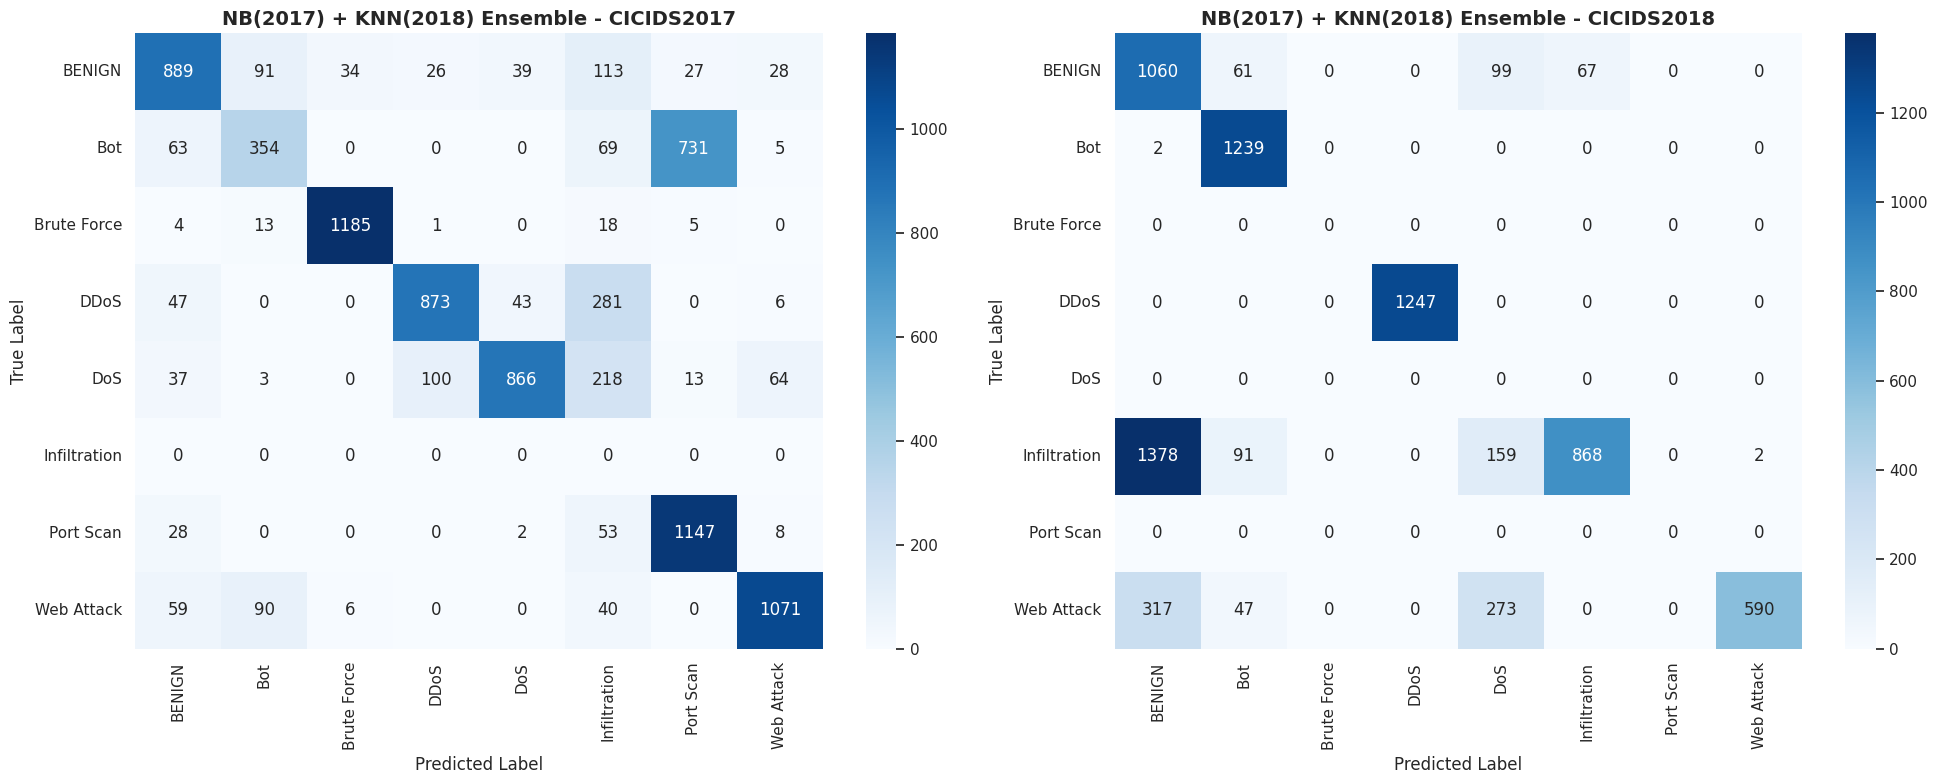


[22/36] Testing: NB(2017) + NB(2018)

🔬 Running NB(2017) + NB(2018) ensemble experiment...

📊 NB(2017) + NB(2018) Ensemble on CICIDS2017
Accuracy: 0.5922
F1-Score (Macro): 0.5205
F1-Score (Weighted): 0.5967
Precision (Macro): 0.6127
Recall (Macro): 0.5167

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.35      0.80      0.49      1247
         Bot       0.63      0.35      0.45      1222
 Brute Force       0.88      0.51      0.65      1226
        DDoS       0.88      0.30      0.45      1250
         DoS       0.93      0.67      0.78      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.52      0.66      0.58      1238
  Web Attack       0.71      0.85      0.77      1266

    accuracy                           0.59      8750
   macro avg       0.61      0.52      0.52      8750
weighted avg       0.70      0.59      0.60      8750


📊 NB(2017) + NB(2018) Ensemble on CICIDS2018
Accuracy: 0.4

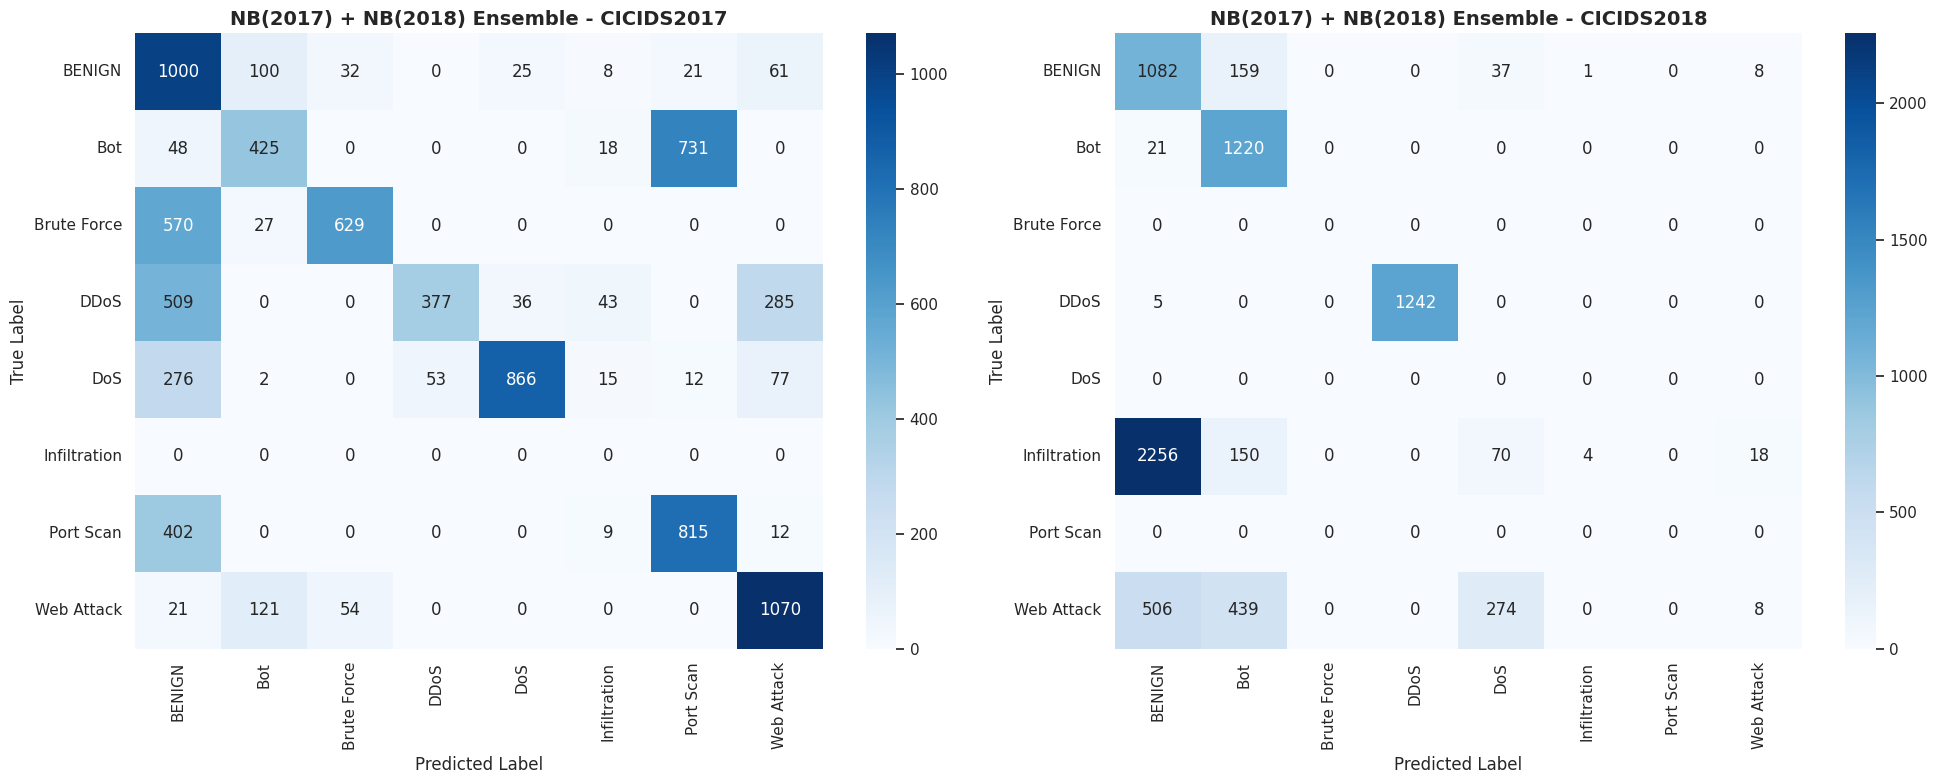


[23/36] Testing: NB(2017) + LR(2018)

🔬 Running NB(2017) + LR(2018) ensemble experiment...

📊 NB(2017) + LR(2018) Ensemble on CICIDS2017
Accuracy: 0.7727
F1-Score (Macro): 0.6712
F1-Score (Weighted): 0.7682
Precision (Macro): 0.6853
Recall (Macro): 0.6756

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.82      0.69      0.75      1247
         Bot       0.52      0.36      0.43      1222
 Brute Force       0.92      0.97      0.94      1226
        DDoS       0.89      0.82      0.86      1250
         DoS       0.92      0.75      0.83      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.61      0.96      0.74      1238
  Web Attack       0.80      0.85      0.82      1266

    accuracy                           0.77      8750
   macro avg       0.69      0.68      0.67      8750
weighted avg       0.78      0.77      0.77      8750


📊 NB(2017) + LR(2018) Ensemble on CICIDS2018
Accuracy: 0.1

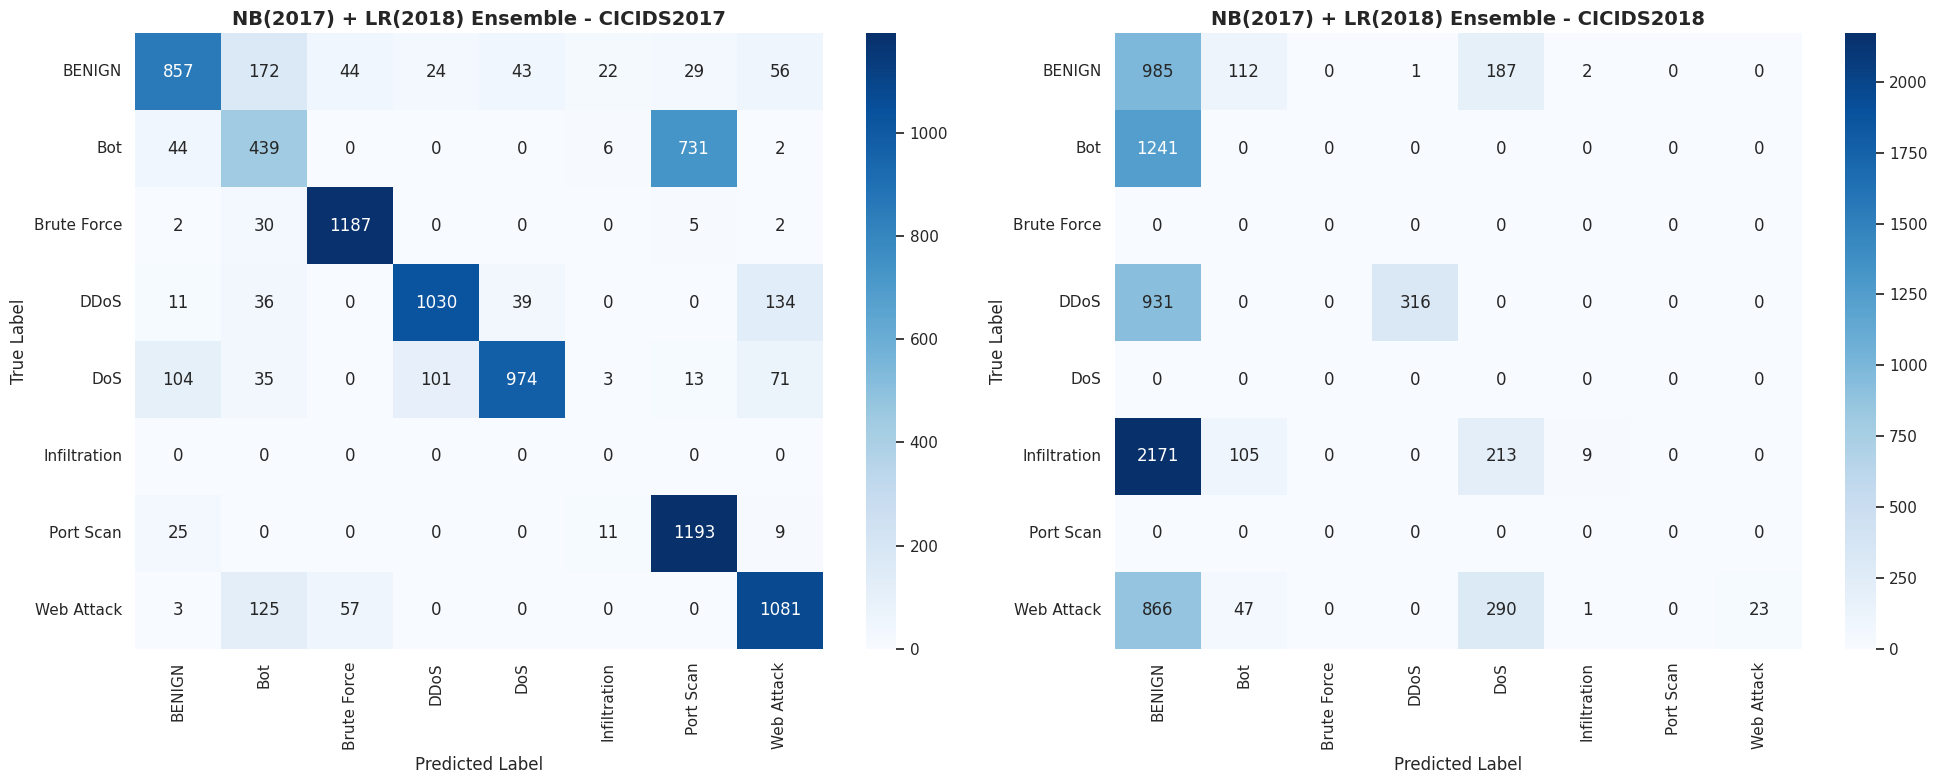


[24/36] Testing: NB(2017) + LGB(2018)

🔬 Running NB(2017) + LGB(2018) ensemble experiment...

📊 NB(2017) + LGB(2018) Ensemble on CICIDS2017
Accuracy: 0.7990
F1-Score (Macro): 0.6922
F1-Score (Weighted): 0.7923
Precision (Macro): 0.7073
Recall (Macro): 0.6984

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.87      0.72      0.79      1247
         Bot       0.59      0.36      0.45      1222
 Brute Force       0.92      0.97      0.94      1226
        DDoS       0.83      0.93      0.87      1250
         DoS       0.89      0.79      0.84      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.61      0.97      0.75      1238
  Web Attack       0.96      0.85      0.90      1266

    accuracy                           0.80      8750
   macro avg       0.71      0.70      0.69      8750
weighted avg       0.81      0.80      0.79      8750


📊 NB(2017) + LGB(2018) Ensemble on CICIDS2018
Accuracy:

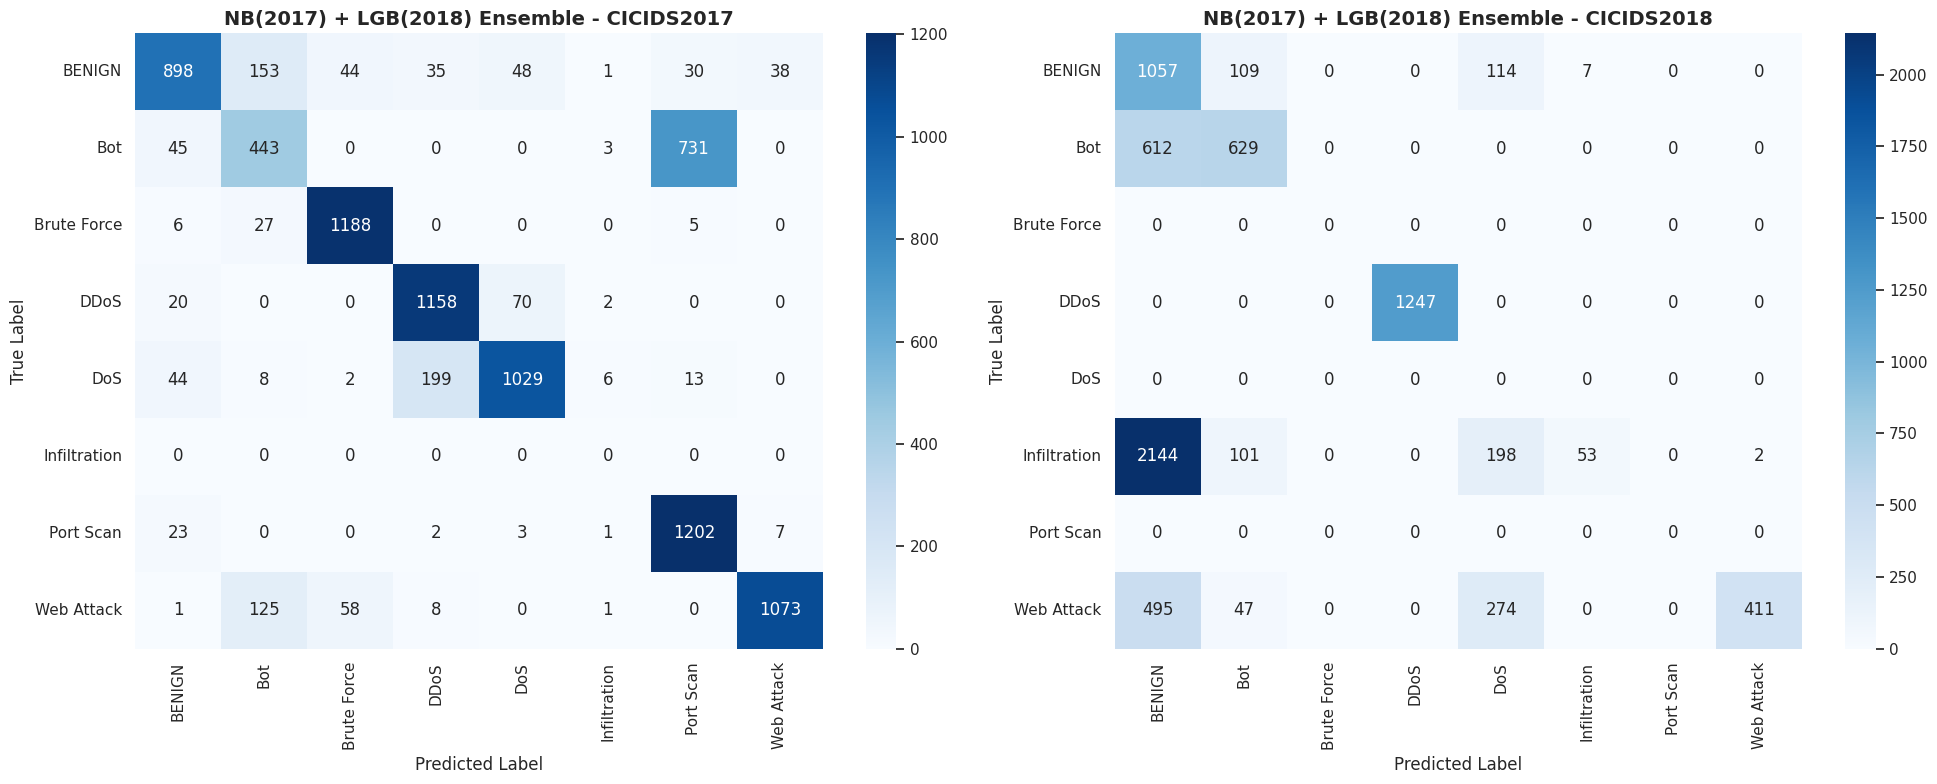


[25/36] Testing: LR(2017) + RF(2018)

🔬 Running LR(2017) + RF(2018) ensemble experiment...

📊 LR(2017) + RF(2018) Ensemble on CICIDS2017
Accuracy: 0.8941
F1-Score (Macro): 0.8034
F1-Score (Weighted): 0.9186
Precision (Macro): 0.8292
Recall (Macro): 0.7819

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.84      0.83      0.83      1247
         Bot       0.89      0.68      0.77      1222
 Brute Force       0.99      0.97      0.98      1226
        DDoS       0.99      0.98      0.99      1250
         DoS       0.99      0.91      0.95      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.98      0.98      0.98      1238
  Web Attack       0.95      0.91      0.93      1266

    accuracy                           0.89      8750
   macro avg       0.83      0.78      0.80      8750
weighted avg       0.95      0.89      0.92      8750


📊 LR(2017) + RF(2018) Ensemble on CICIDS2018
Accuracy: 0.5

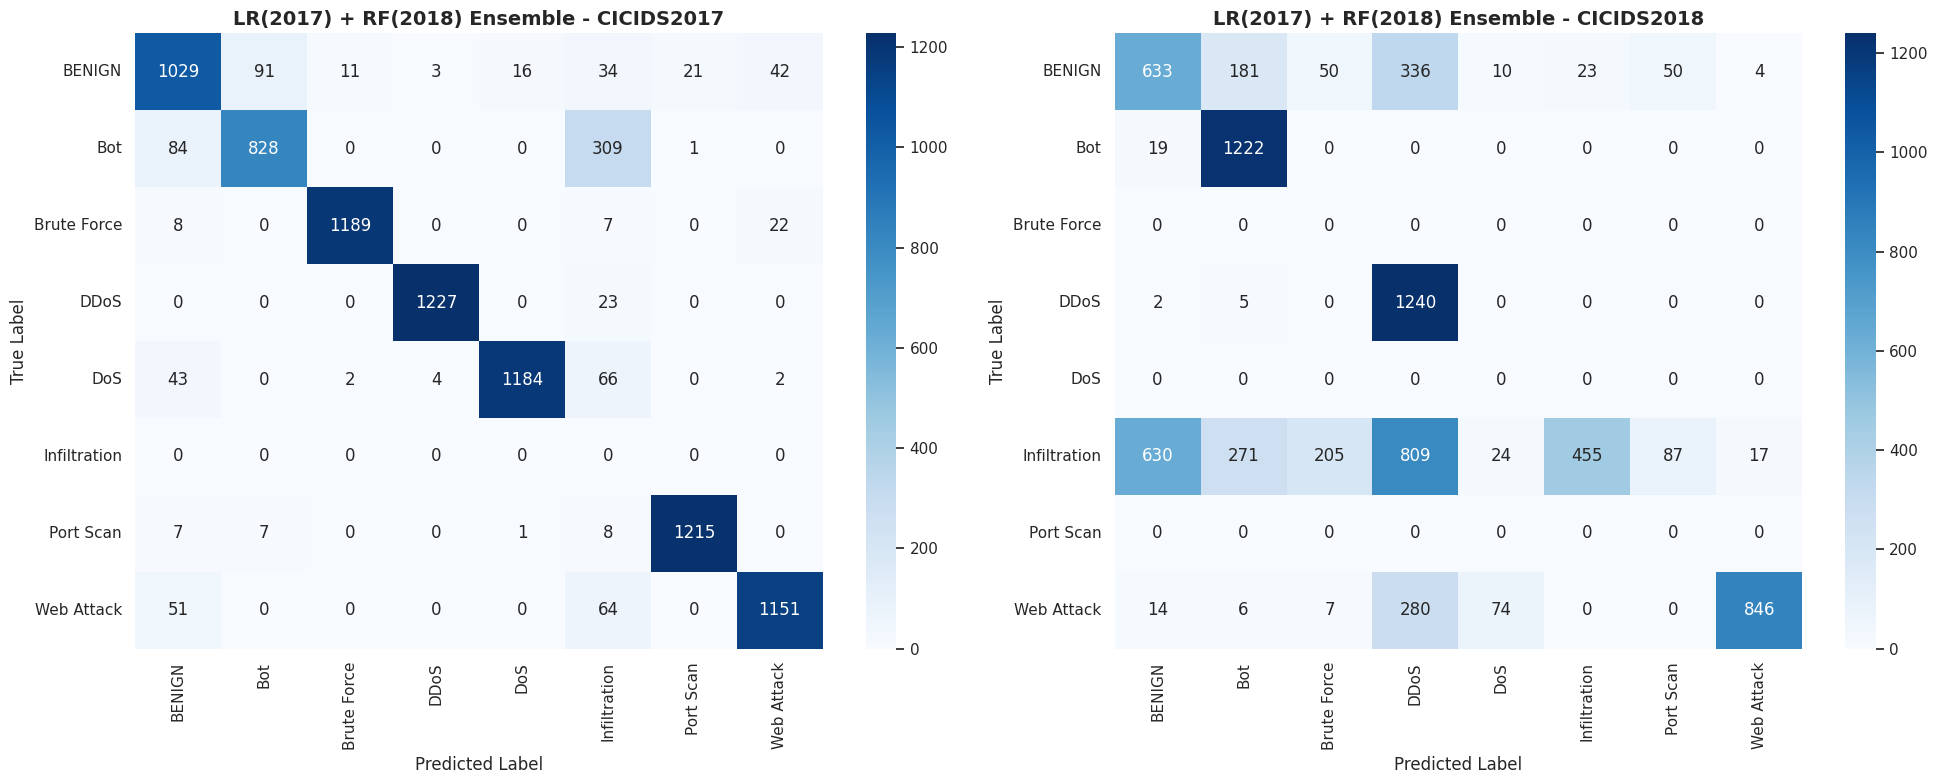


[26/36] Testing: LR(2017) + DT(2018)

🔬 Running LR(2017) + DT(2018) ensemble experiment...

📊 LR(2017) + DT(2018) Ensemble on CICIDS2017
Accuracy: 0.3945
F1-Score (Macro): 0.3784
F1-Score (Weighted): 0.4322
Precision (Macro): 0.5697
Recall (Macro): 0.3458

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.37      0.81      0.51      1247
         Bot       0.83      0.36      0.51      1222
 Brute Force       0.00      0.00      0.00      1226
        DDoS       0.99      0.76      0.86      1250
         DoS       0.97      0.25      0.40      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.97      0.55      0.70      1238
  Web Attack       0.43      0.03      0.06      1266

    accuracy                           0.39      8750
   macro avg       0.57      0.35      0.38      8750
weighted avg       0.65      0.39      0.43      8750


📊 LR(2017) + DT(2018) Ensemble on CICIDS2018
Accuracy: 0.6

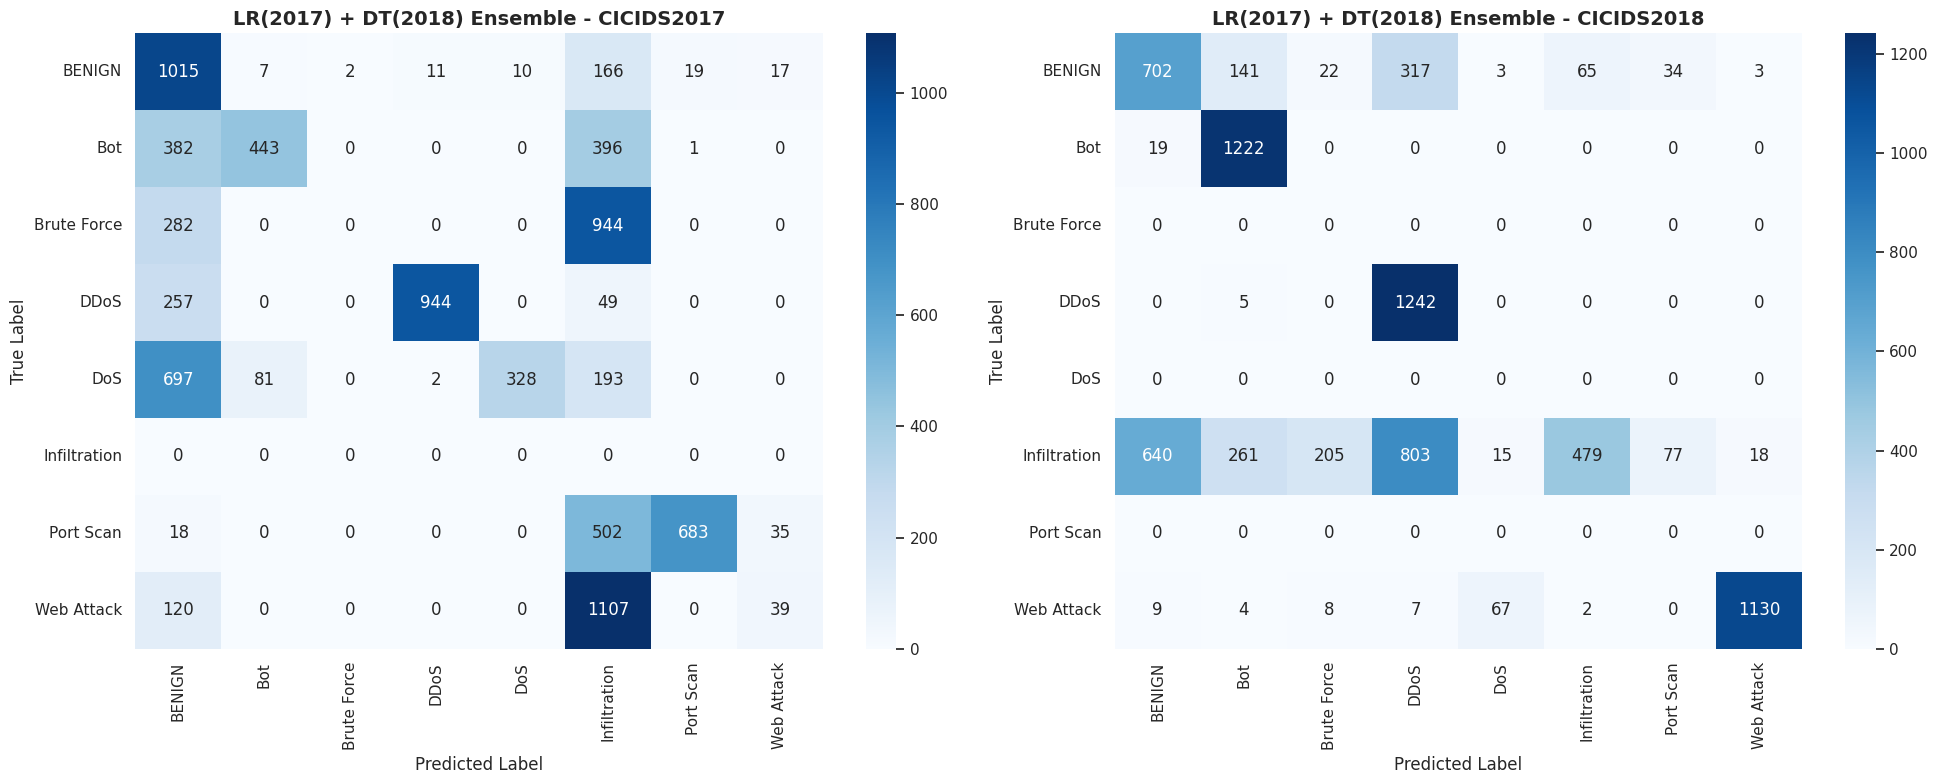


[27/36] Testing: LR(2017) + KNN(2018)

🔬 Running LR(2017) + KNN(2018) ensemble experiment...

📊 LR(2017) + KNN(2018) Ensemble on CICIDS2017
Accuracy: 0.7381
F1-Score (Macro): 0.6946
F1-Score (Weighted): 0.7940
Precision (Macro): 0.7839
Recall (Macro): 0.6457

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.50      0.77      0.60      1247
         Bot       0.92      0.64      0.75      1222
 Brute Force       0.99      0.93      0.96      1226
        DDoS       0.98      0.61      0.75      1250
         DoS       0.99      0.72      0.84      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.99      0.62      0.76      1238
  Web Attack       0.91      0.88      0.89      1266

    accuracy                           0.74      8750
   macro avg       0.78      0.65      0.69      8750
weighted avg       0.90      0.74      0.79      8750


📊 LR(2017) + KNN(2018) Ensemble on CICIDS2018
Accuracy:

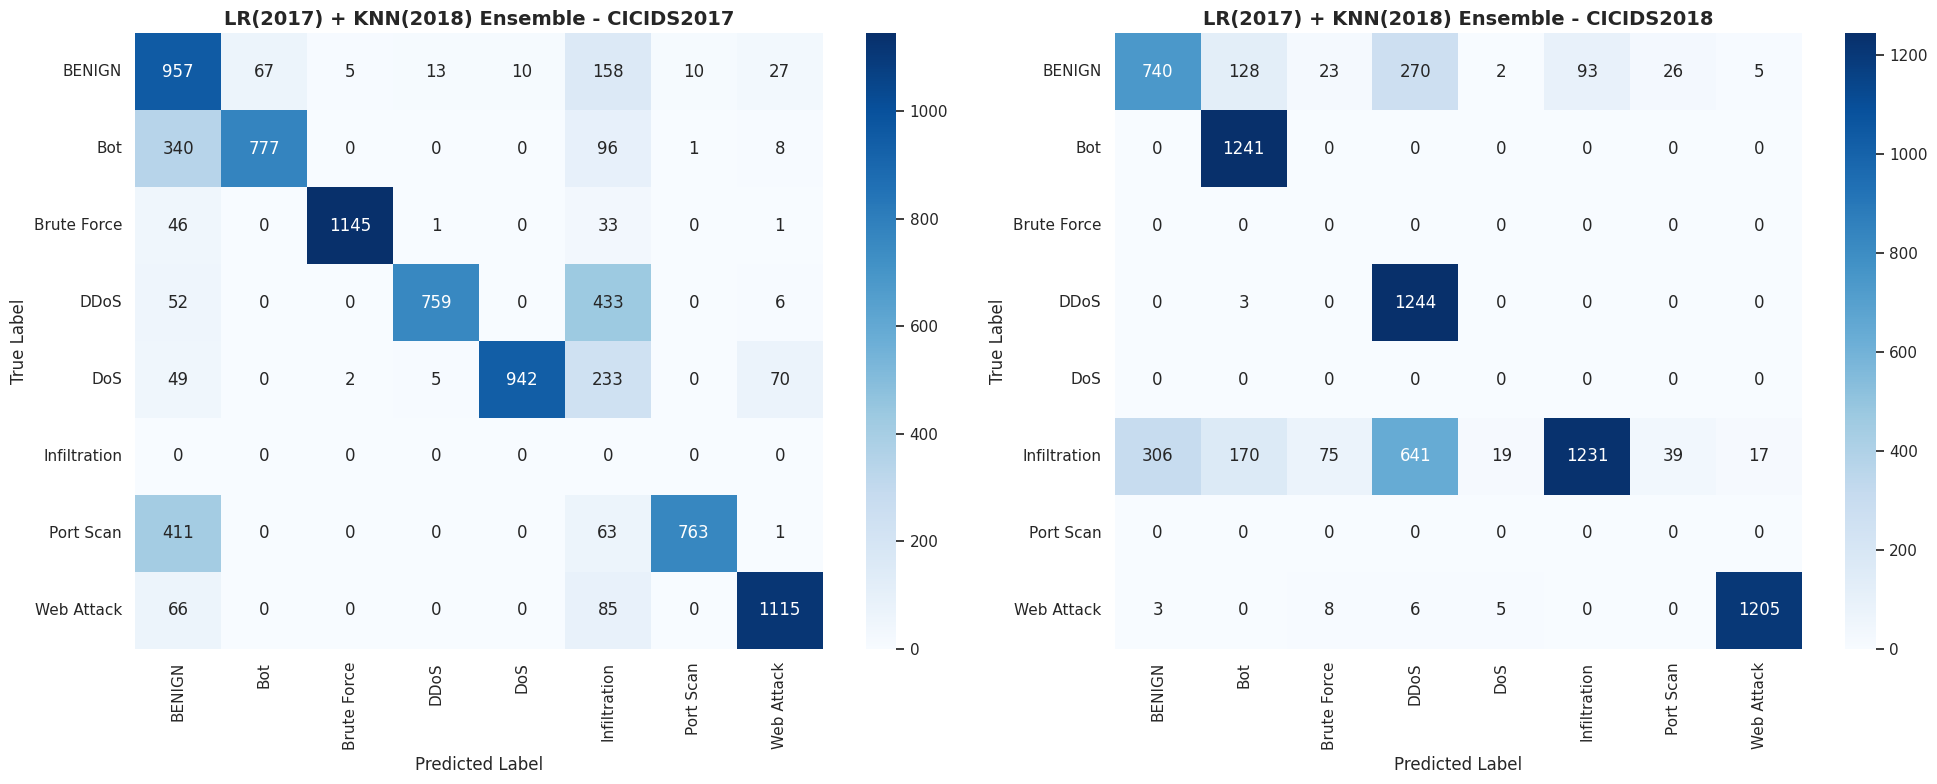


[28/36] Testing: LR(2017) + NB(2018)

🔬 Running LR(2017) + NB(2018) ensemble experiment...

📊 LR(2017) + NB(2018) Ensemble on CICIDS2017
Accuracy: 0.2551
F1-Score (Macro): 0.1893
F1-Score (Weighted): 0.2201
Precision (Macro): 0.5691
Recall (Macro): 0.2209

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.17      0.92      0.28      1247
         Bot       1.00      0.00      0.01      1222
 Brute Force       0.33      0.00      0.00      1226
        DDoS       1.00      0.21      0.34      1250
         DoS       0.99      0.52      0.68      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       1.00      0.09      0.16      1238
  Web Attack       0.06      0.03      0.04      1266

    accuracy                           0.26      8750
   macro avg       0.57      0.22      0.19      8750
weighted avg       0.65      0.26      0.22      8750


📊 LR(2017) + NB(2018) Ensemble on CICIDS2018
Accuracy: 0.5

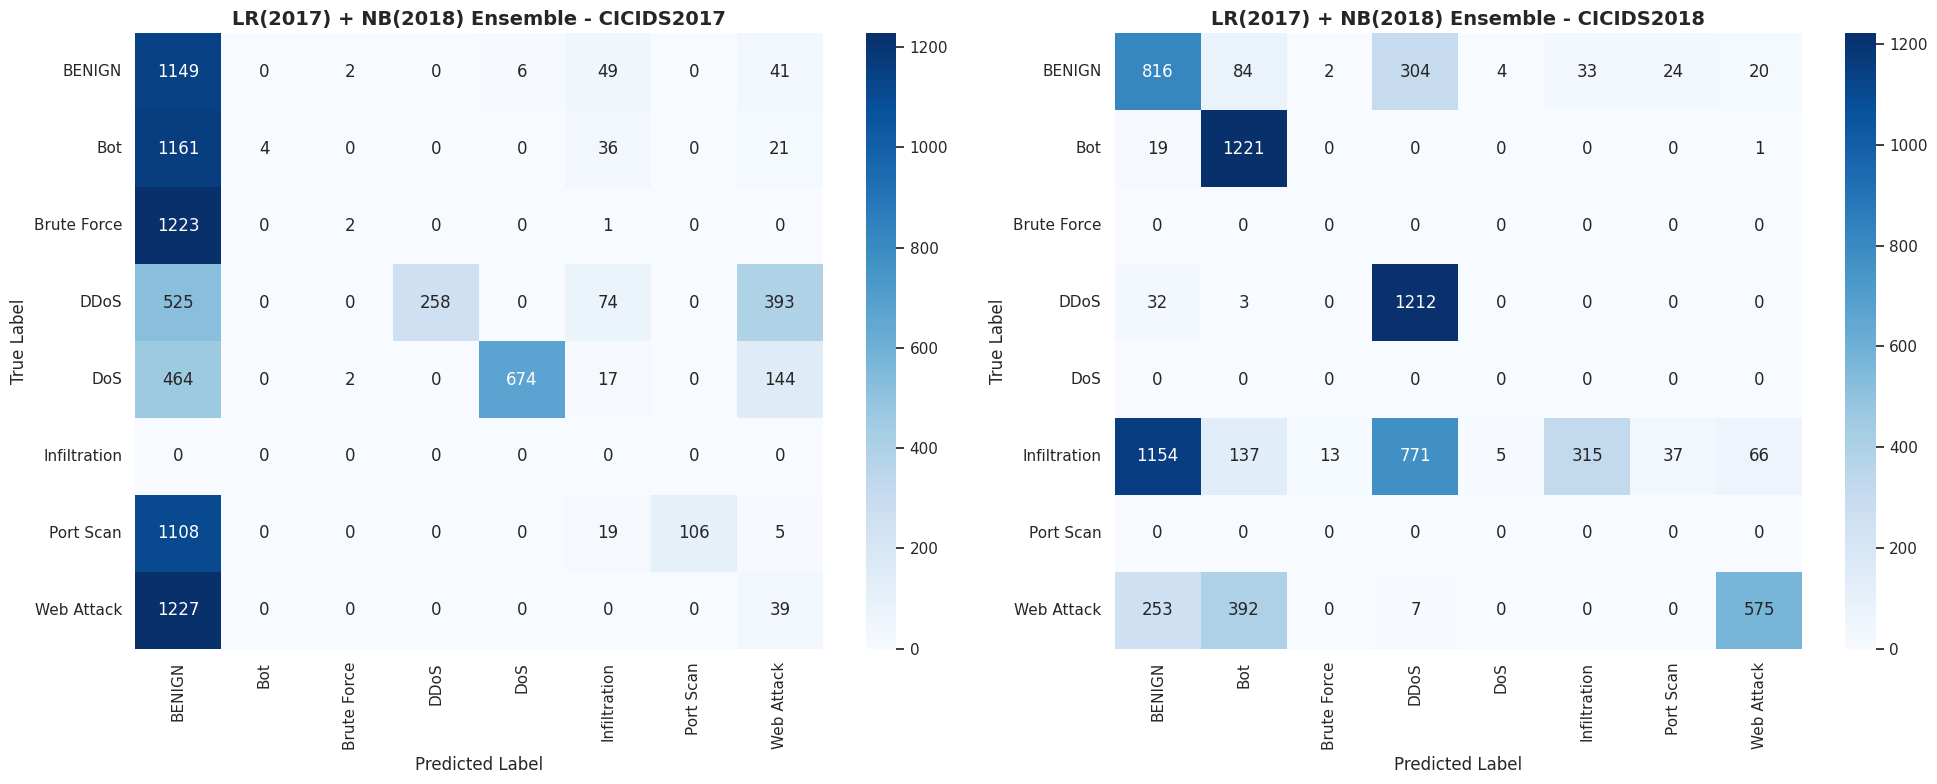


[29/36] Testing: LR(2017) + LR(2018)

🔬 Running LR(2017) + LR(2018) ensemble experiment...

📊 LR(2017) + LR(2018) Ensemble on CICIDS2017
Accuracy: 0.7182
F1-Score (Macro): 0.6718
F1-Score (Weighted): 0.7683
Precision (Macro): 0.7714
Recall (Macro): 0.6275

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.80      0.77      0.78      1247
         Bot       0.82      0.50      0.62      1222
 Brute Force       0.99      0.97      0.98      1226
        DDoS       0.96      0.59      0.73      1250
         DoS       0.99      0.77      0.87      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.99      0.49      0.65      1238
  Web Attack       0.61      0.94      0.74      1266

    accuracy                           0.72      8750
   macro avg       0.77      0.63      0.67      8750
weighted avg       0.88      0.72      0.77      8750


📊 LR(2017) + LR(2018) Ensemble on CICIDS2018
Accuracy: 0.4

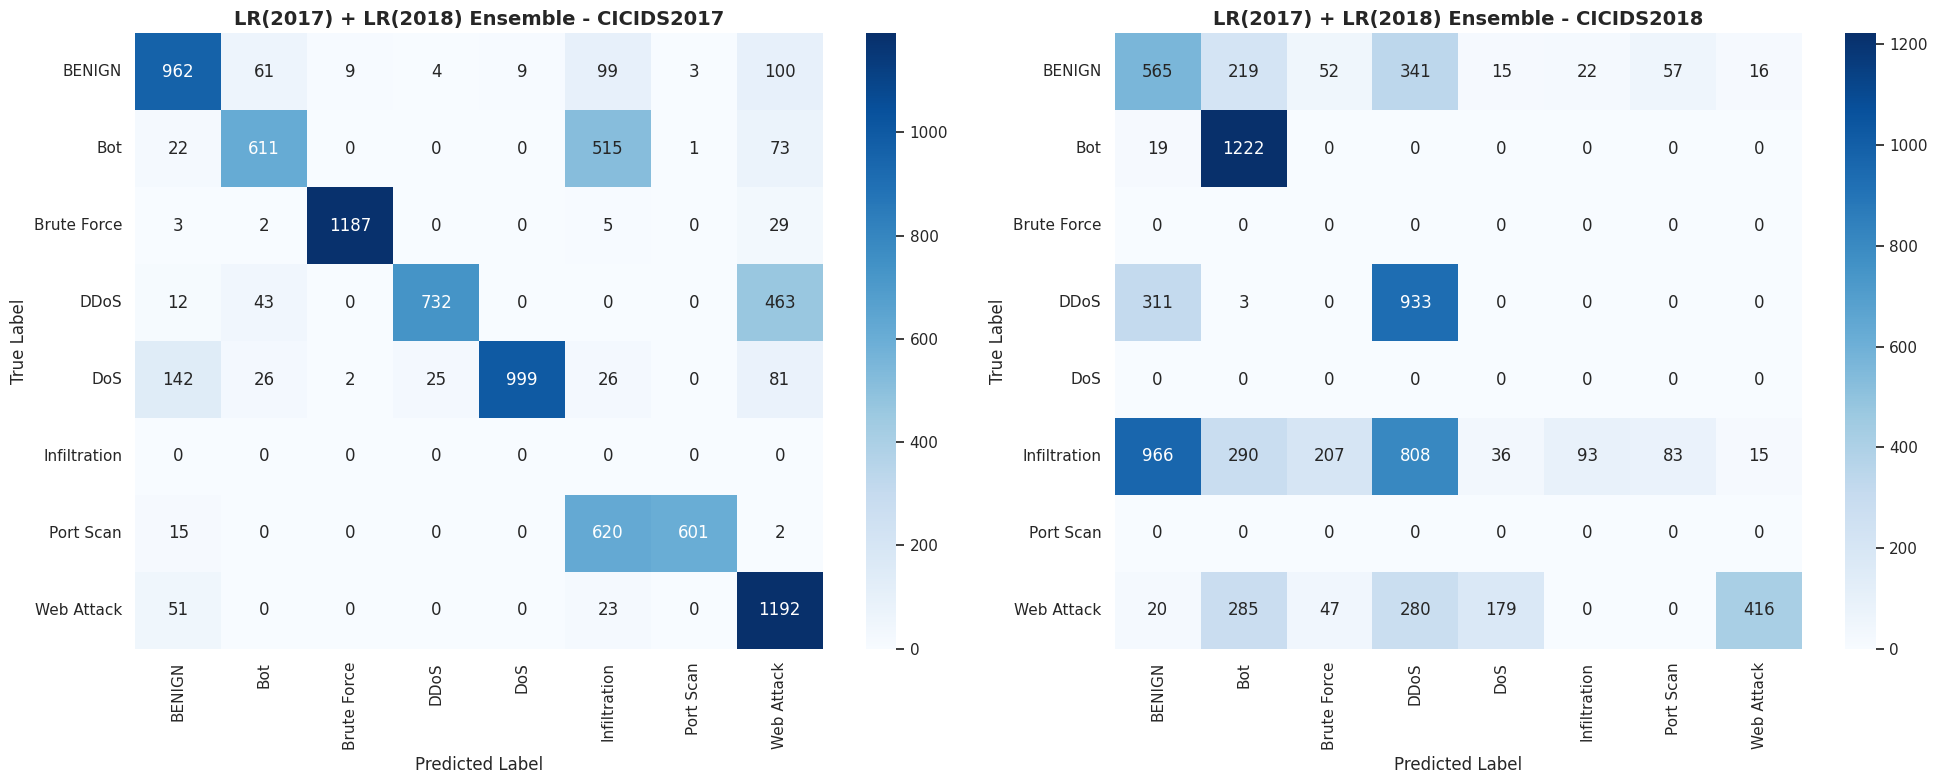


[30/36] Testing: LR(2017) + LGB(2018)

🔬 Running LR(2017) + LGB(2018) ensemble experiment...

📊 LR(2017) + LGB(2018) Ensemble on CICIDS2017
Accuracy: 0.8334
F1-Score (Macro): 0.7421
F1-Score (Weighted): 0.8490
Precision (Macro): 0.7913
Recall (Macro): 0.7284

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.48      0.89      0.62      1247
         Bot       0.94      0.54      0.69      1222
 Brute Force       0.99      0.97      0.98      1226
        DDoS       0.98      0.97      0.98      1250
         DoS       0.99      0.86      0.92      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       0.98      0.72      0.83      1238
  Web Attack       0.97      0.88      0.92      1266

    accuracy                           0.83      8750
   macro avg       0.79      0.73      0.74      8750
weighted avg       0.90      0.83      0.85      8750


📊 LR(2017) + LGB(2018) Ensemble on CICIDS2018
Accuracy:

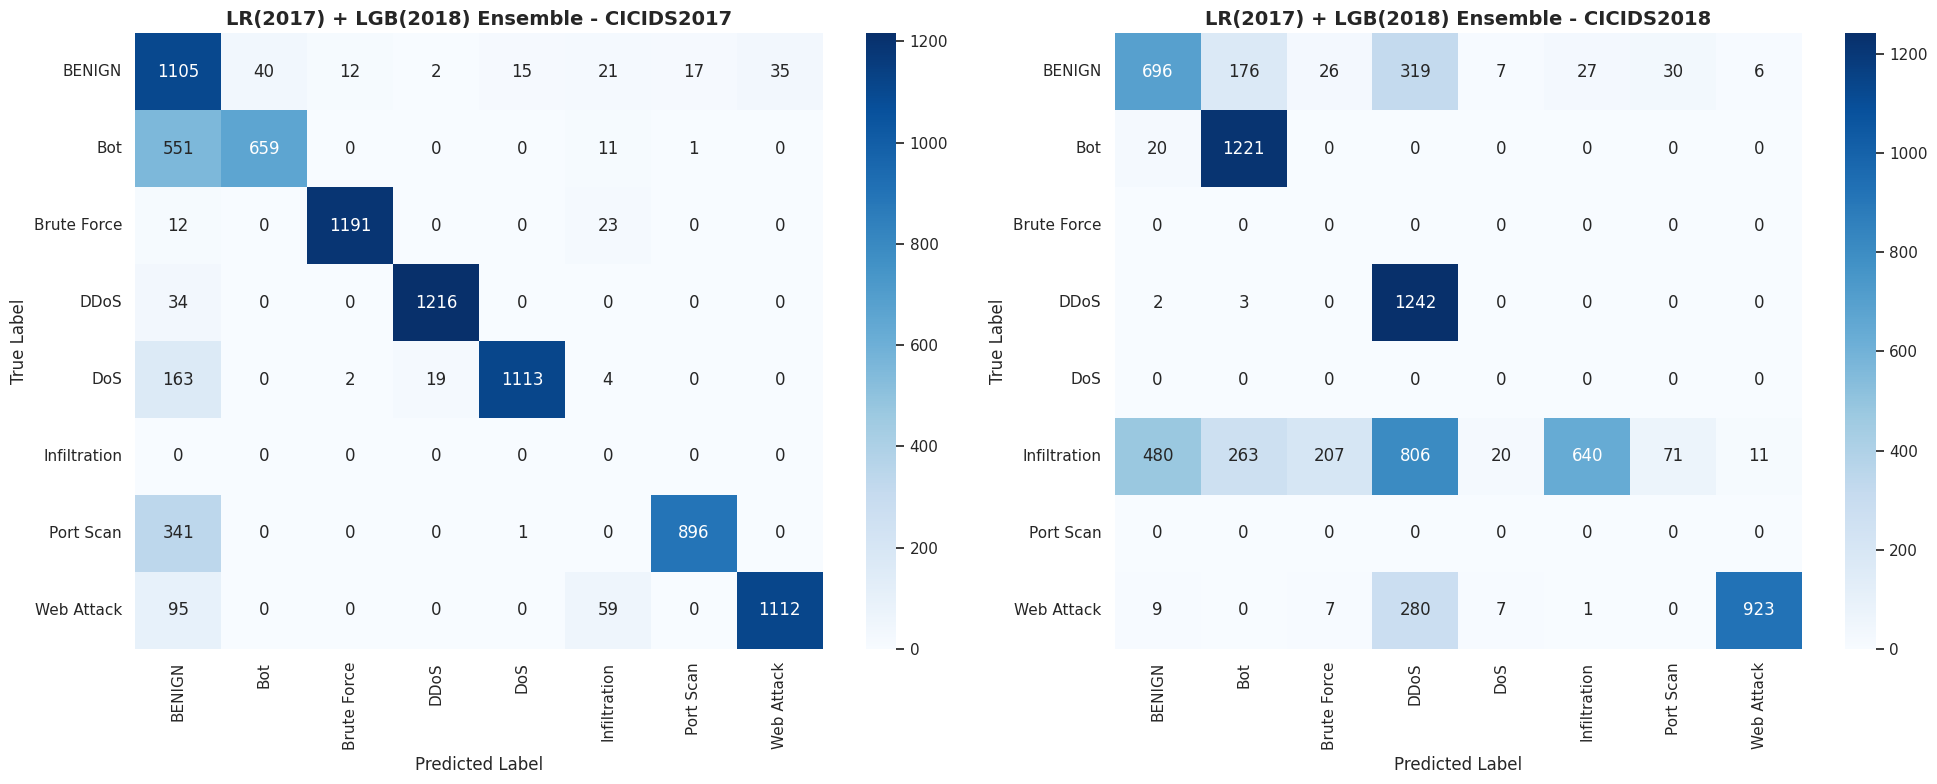


[31/36] Testing: LGB(2017) + RF(2018)

🔬 Running LGB(2017) + RF(2018) ensemble experiment...

📊 LGB(2017) + RF(2018) Ensemble on CICIDS2017
Accuracy: 0.9977
F1-Score (Macro): 0.8730
F1-Score (Weighted): 0.9978
Precision (Macro): 0.8731
Recall (Macro): 0.8730

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.99      0.99      0.99      1247
         Bot       1.00      1.00      1.00      1222
 Brute Force       1.00      1.00      1.00      1226
        DDoS       1.00      1.00      1.00      1250
         DoS       1.00      1.00      1.00      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       1.00      1.00      1.00      1238
  Web Attack       1.00      1.00      1.00      1266

    accuracy                           1.00      8750
   macro avg       0.87      0.87      0.87      8750
weighted avg       1.00      1.00      1.00      8750


📊 LGB(2017) + RF(2018) Ensemble on CICIDS2018
Accuracy:

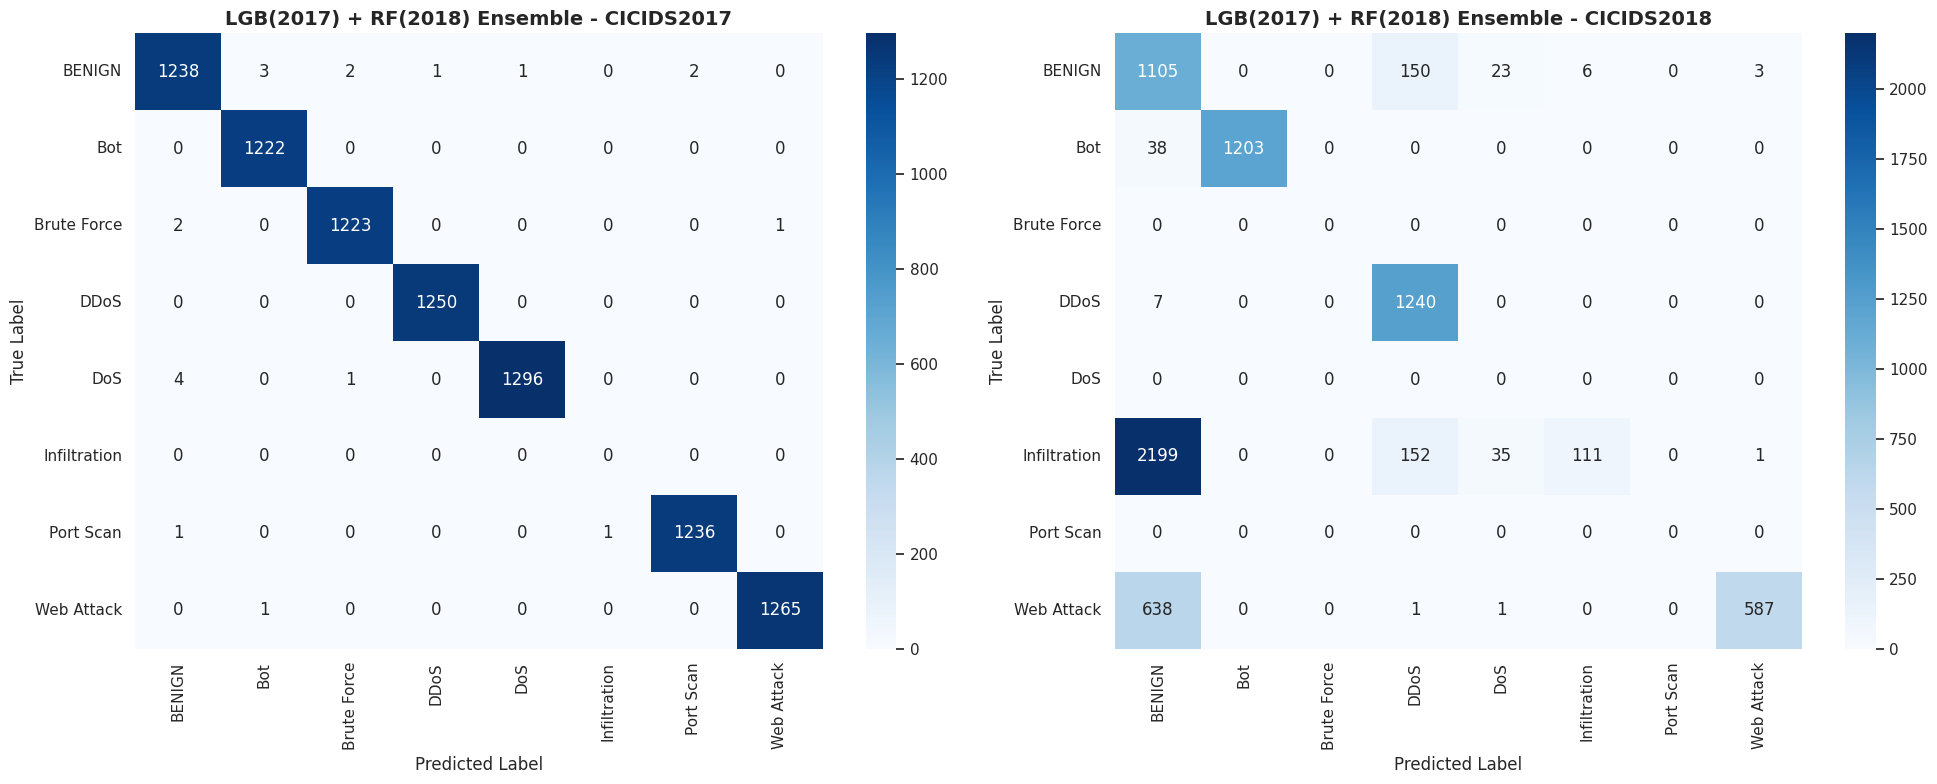


[32/36] Testing: LGB(2017) + DT(2018)

🔬 Running LGB(2017) + DT(2018) ensemble experiment...

📊 LGB(2017) + DT(2018) Ensemble on CICIDS2017
Accuracy: 0.7685
F1-Score (Macro): 0.6911
F1-Score (Weighted): 0.7882
Precision (Macro): 0.7855
Recall (Macro): 0.6743

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.41      0.96      0.57      1247
         Bot       0.91      0.69      0.78      1222
 Brute Force       1.00      0.77      0.87      1226
        DDoS       1.00      0.76      0.86      1250
         DoS       1.00      0.36      0.53      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       1.00      0.96      0.98      1238
  Web Attack       0.97      0.91      0.94      1266

    accuracy                           0.77      8750
   macro avg       0.79      0.67      0.69      8750
weighted avg       0.90      0.77      0.79      8750


📊 LGB(2017) + DT(2018) Ensemble on CICIDS2018
Accuracy:

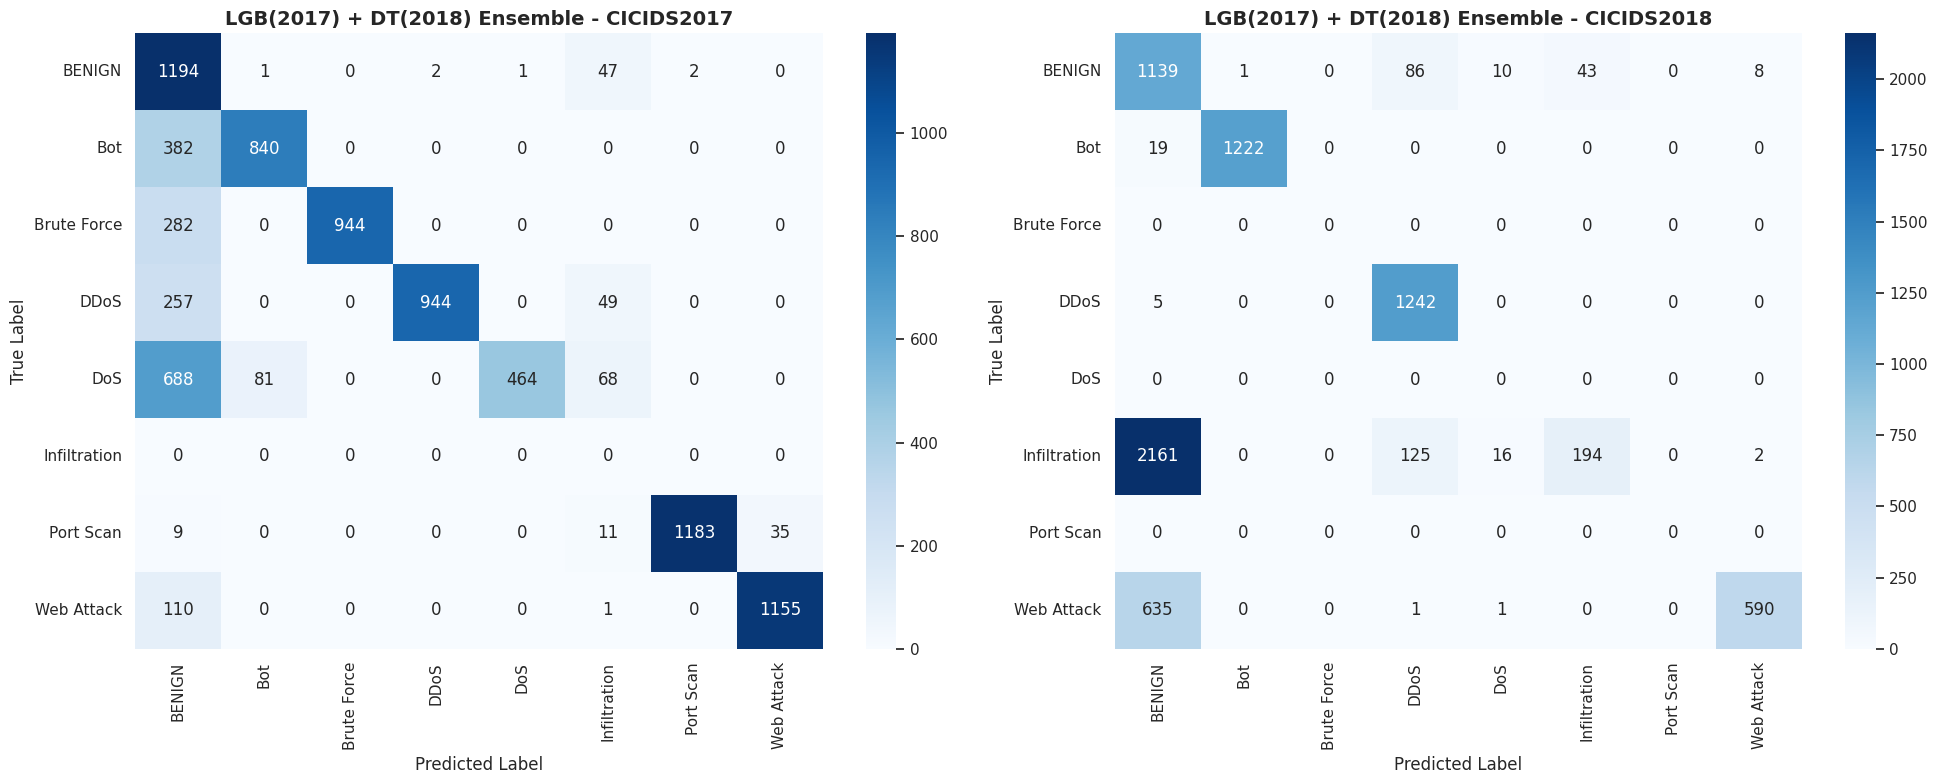


[33/36] Testing: LGB(2017) + KNN(2018)

🔬 Running LGB(2017) + KNN(2018) ensemble experiment...

📊 LGB(2017) + KNN(2018) Ensemble on CICIDS2017
Accuracy: 0.8838
F1-Score (Macro): 0.8082
F1-Score (Weighted): 0.9230
Precision (Macro): 0.8504
Recall (Macro): 0.7742

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.89      0.89      0.89      1247
         Bot       1.00      0.92      0.96      1222
 Brute Force       1.00      0.98      0.99      1226
        DDoS       0.99      0.74      0.85      1250
         DoS       1.00      0.78      0.88      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       1.00      0.96      0.98      1238
  Web Attack       0.94      0.92      0.93      1266

    accuracy                           0.88      8750
   macro avg       0.85      0.77      0.81      8750
weighted avg       0.97      0.88      0.92      8750


📊 LGB(2017) + KNN(2018) Ensemble on CICIDS2018
Accur

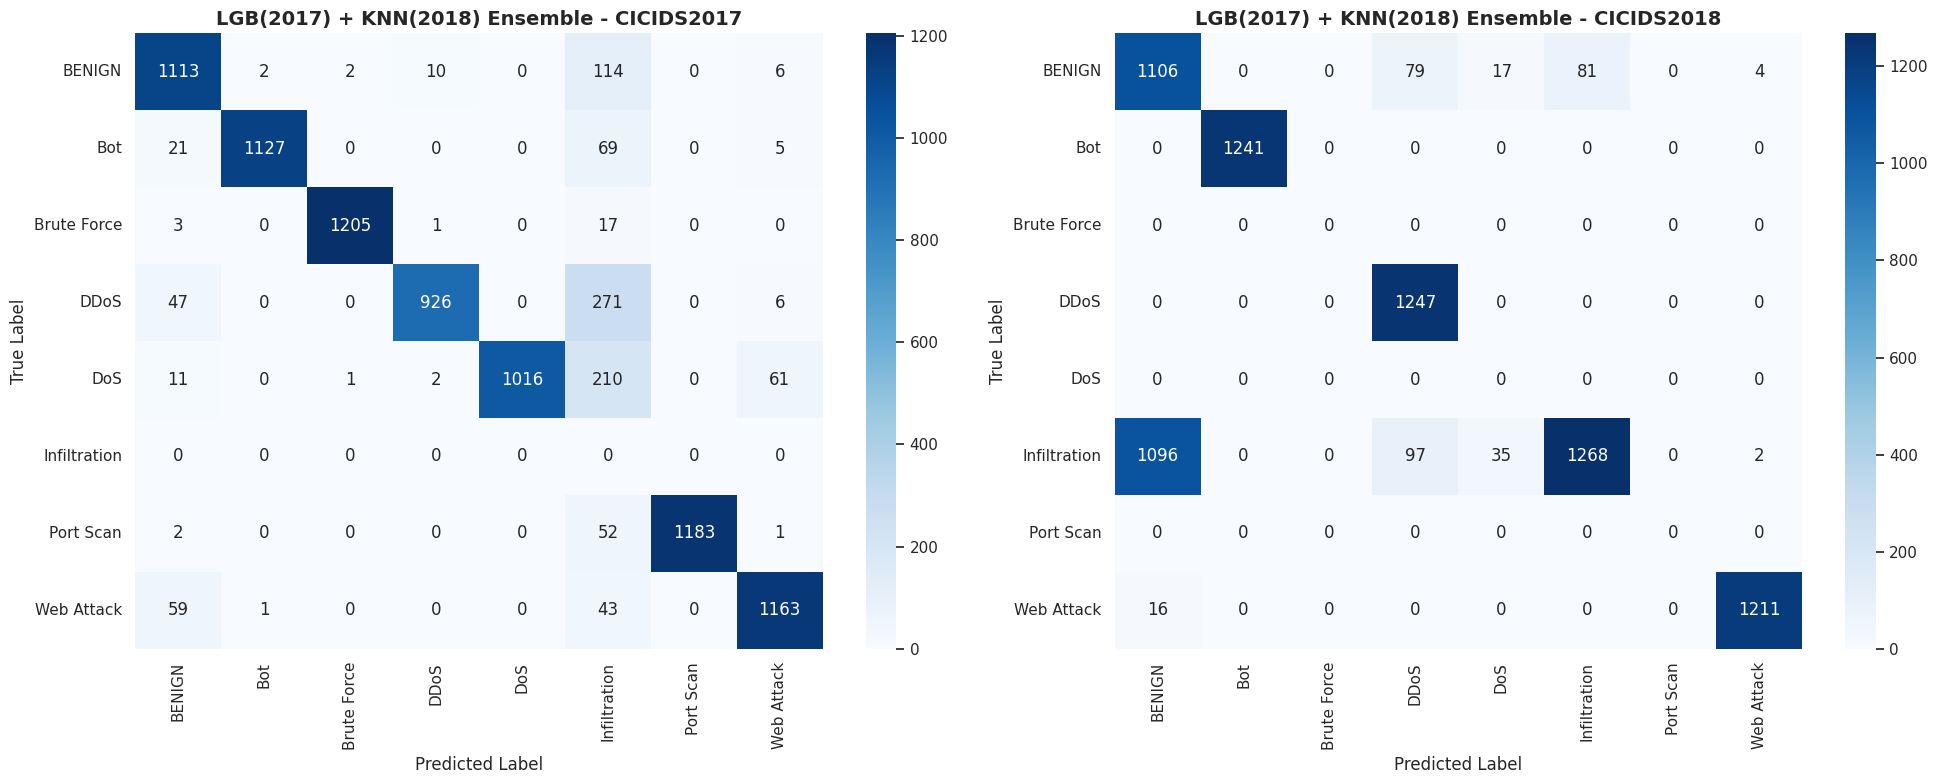


[34/36] Testing: LGB(2017) + NB(2018)

🔬 Running LGB(2017) + NB(2018) ensemble experiment...

📊 LGB(2017) + NB(2018) Ensemble on CICIDS2017
Accuracy: 0.8934
F1-Score (Macro): 0.7893
F1-Score (Weighted): 0.9012
Precision (Macro): 0.8140
Recall (Macro): 0.7825

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.81      0.95      0.87      1247
         Bot       1.00      0.93      0.96      1222
 Brute Force       1.00      0.99      0.99      1226
        DDoS       1.00      0.68      0.81      1250
         DoS       1.00      0.79      0.88      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       1.00      0.95      0.97      1238
  Web Attack       0.71      0.98      0.82      1266

    accuracy                           0.89      8750
   macro avg       0.81      0.78      0.79      8750
weighted avg       0.93      0.89      0.90      8750


📊 LGB(2017) + NB(2018) Ensemble on CICIDS2018
Accuracy:

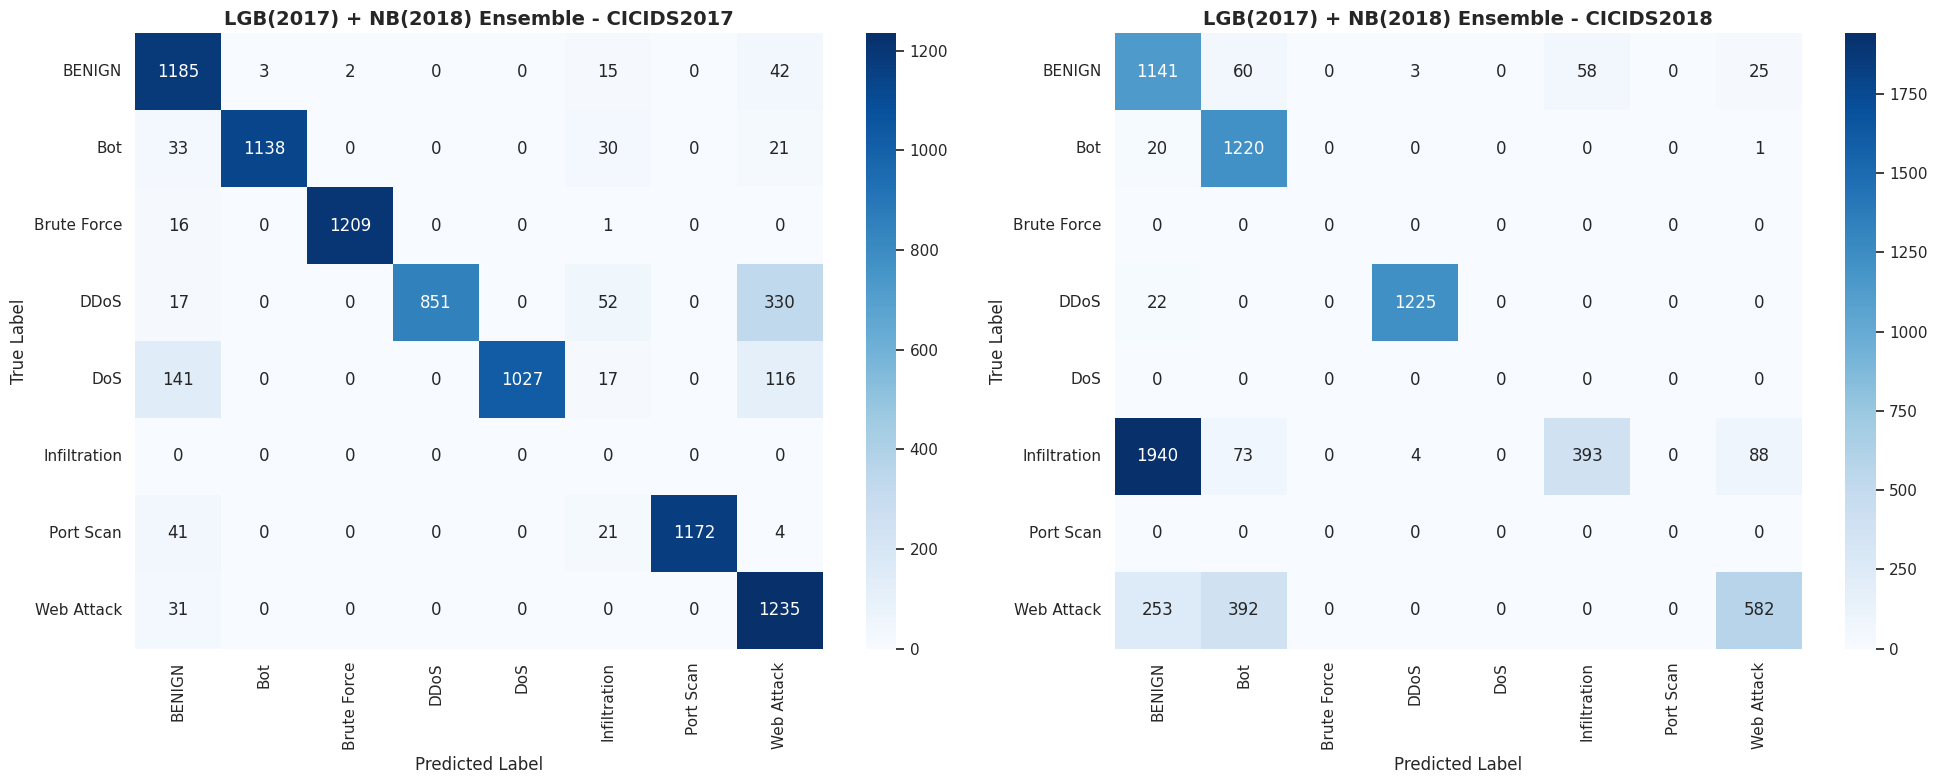


[35/36] Testing: LGB(2017) + LR(2018)

🔬 Running LGB(2017) + LR(2018) ensemble experiment...

📊 LGB(2017) + LR(2018) Ensemble on CICIDS2017
Accuracy: 0.9840
F1-Score (Macro): 0.8616
F1-Score (Weighted): 0.9847
Precision (Macro): 0.8625
Recall (Macro): 0.8612

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.99      0.95      0.97      1247
         Bot       0.95      1.00      0.97      1222
 Brute Force       1.00      1.00      1.00      1226
        DDoS       0.99      0.99      0.99      1250
         DoS       1.00      0.96      0.98      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       1.00      0.99      1.00      1238
  Web Attack       0.97      1.00      0.98      1266

    accuracy                           0.98      8750
   macro avg       0.86      0.86      0.86      8750
weighted avg       0.99      0.98      0.98      8750


📊 LGB(2017) + LR(2018) Ensemble on CICIDS2018
Accuracy:

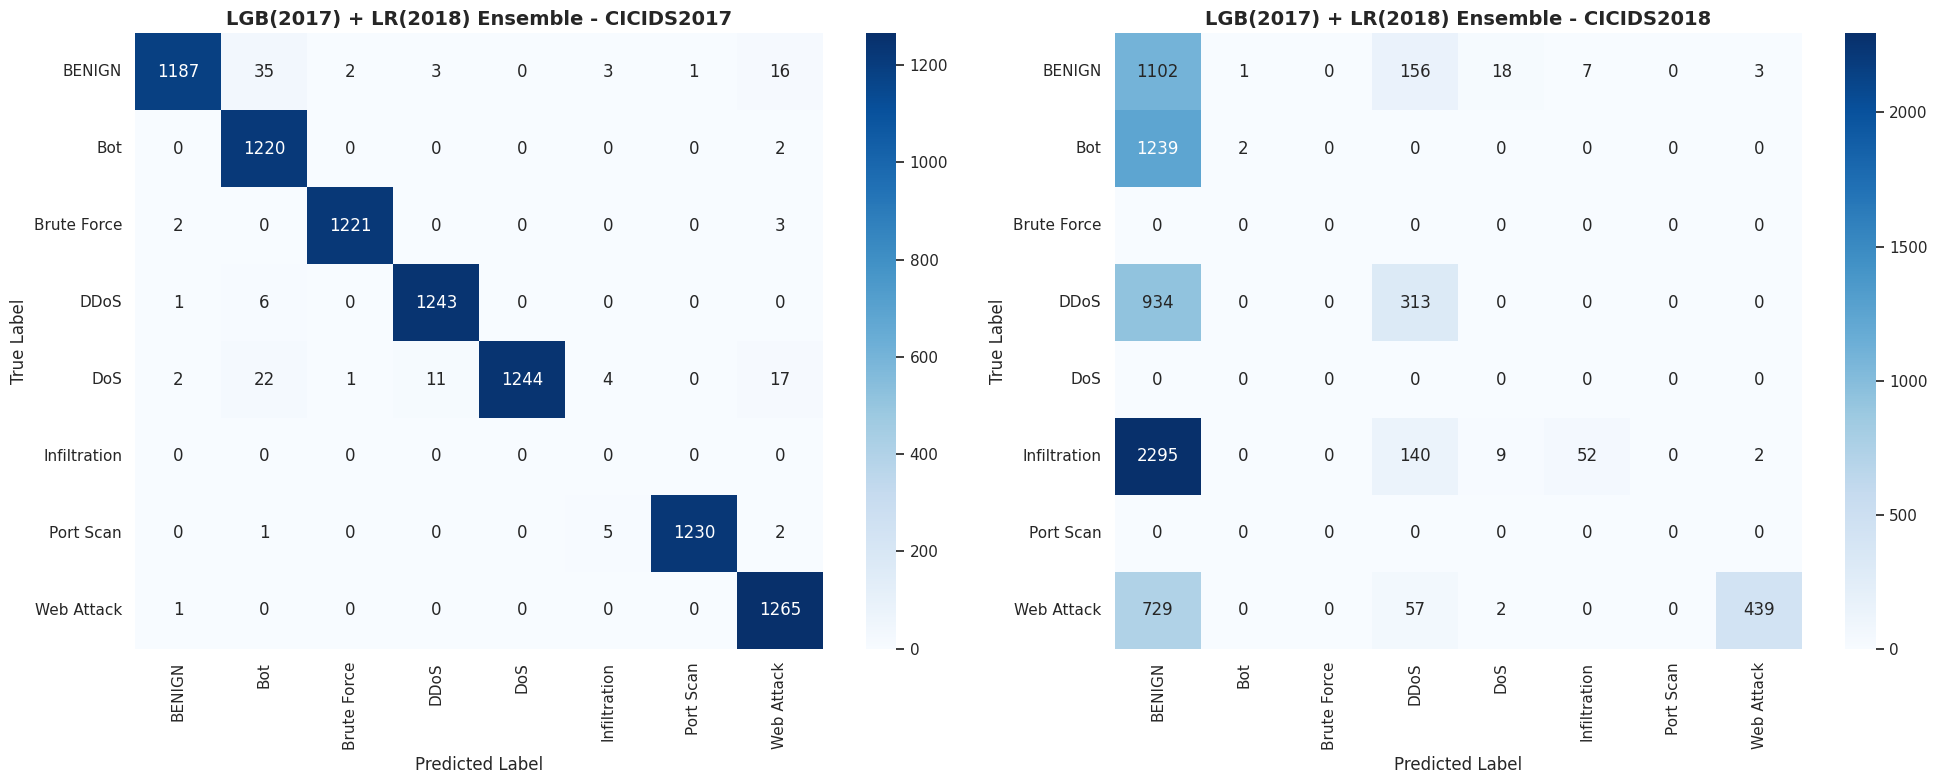


[36/36] Testing: LGB(2017) + LGB(2018)

🔬 Running LGB(2017) + LGB(2018) ensemble experiment...

📊 LGB(2017) + LGB(2018) Ensemble on CICIDS2017
Accuracy: 0.9976
F1-Score (Macro): 0.8730
F1-Score (Weighted): 0.9977
Precision (Macro): 0.8731
Recall (Macro): 0.8729

Detailed Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.99      0.99      0.99      1247
         Bot       1.00      1.00      1.00      1222
 Brute Force       1.00      1.00      1.00      1226
        DDoS       1.00      1.00      1.00      1250
         DoS       1.00      1.00      1.00      1301
Infiltration       0.00      0.00      0.00         0
   Port Scan       1.00      1.00      1.00      1238
  Web Attack       1.00      1.00      1.00      1266

    accuracy                           1.00      8750
   macro avg       0.87      0.87      0.87      8750
weighted avg       1.00      1.00      1.00      8750


📊 LGB(2017) + LGB(2018) Ensemble on CICIDS2018
Accur

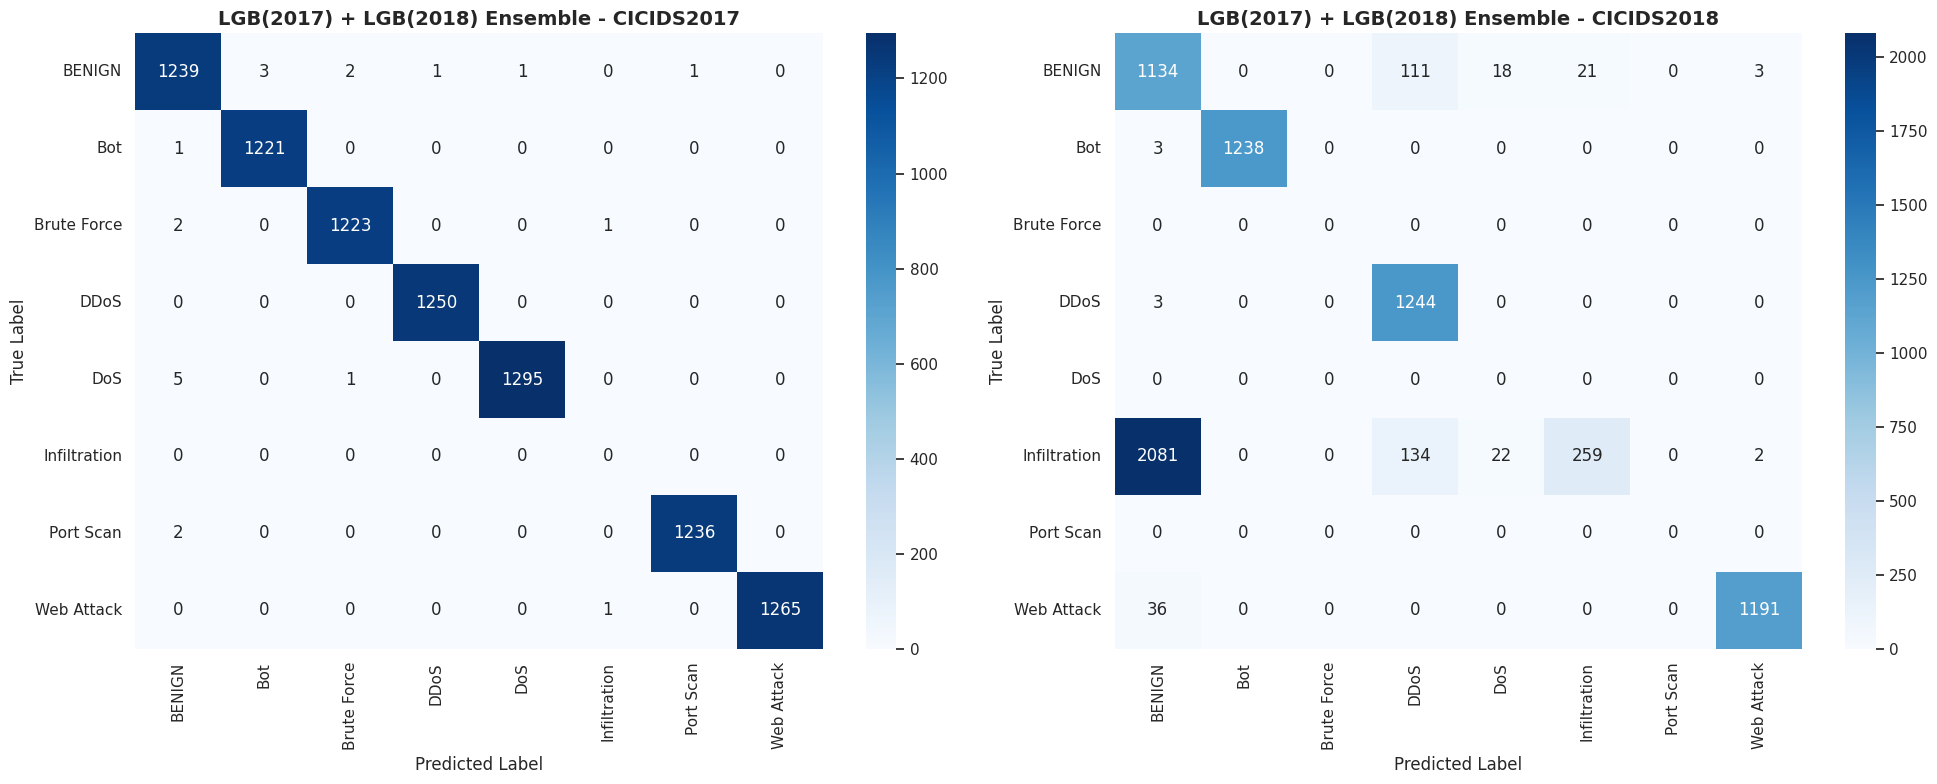


🚀 Running adaptive experiments on top 5 model combinations...

🏆 Top 5 combinations for adaptive testing:
1. RF(2017) + LGB(2018): 0.8995
2. RF(2017) + RF(2018): 0.8904
3. RF(2017) + KNN(2018): 0.8541
4. LGB(2017) + KNN(2018): 0.8468
5. LGB(2017) + LGB(2018): 0.8365

🧠 Running ADAPTIVE RF(2017) + LGB(2018) ensemble experiment...

📊 Testing on CICIDS2017:

🏁 COMPARING ADAPTIVE WEIGHTING METHODS
✅ average              - Acc: 0.9632, F1: 0.8443, Conf: 0.5296
✅ confidence_adaptive_max_prob - Acc: 0.9661, F1: 0.8467, Conf: 0.6156
✅ confidence_adaptive_entropy - Acc: 0.9622, F1: 0.8442, Conf: 0.5997
✅ confidence_adaptive_margin - Acc: 0.9697, F1: 0.8497, Conf: 0.7583
🧠 Training meta-learner for adaptive weighting...
Meta-learner CV Score: -0.2853 (+/- 1.2711)
✅ meta_learner_max_prob - Acc: 0.9827, F1: 0.8605, Conf: 0.8740
✅ meta_learner_entropy - Acc: 0.9827, F1: 0.8605, Conf: 0.8740
✅ meta_learner_margin  - Acc: 0.9827, F1: 0.8605, Conf: 0.8740
✅ hybrid_max_prob      - Acc: 0.9827, F1: 0.8

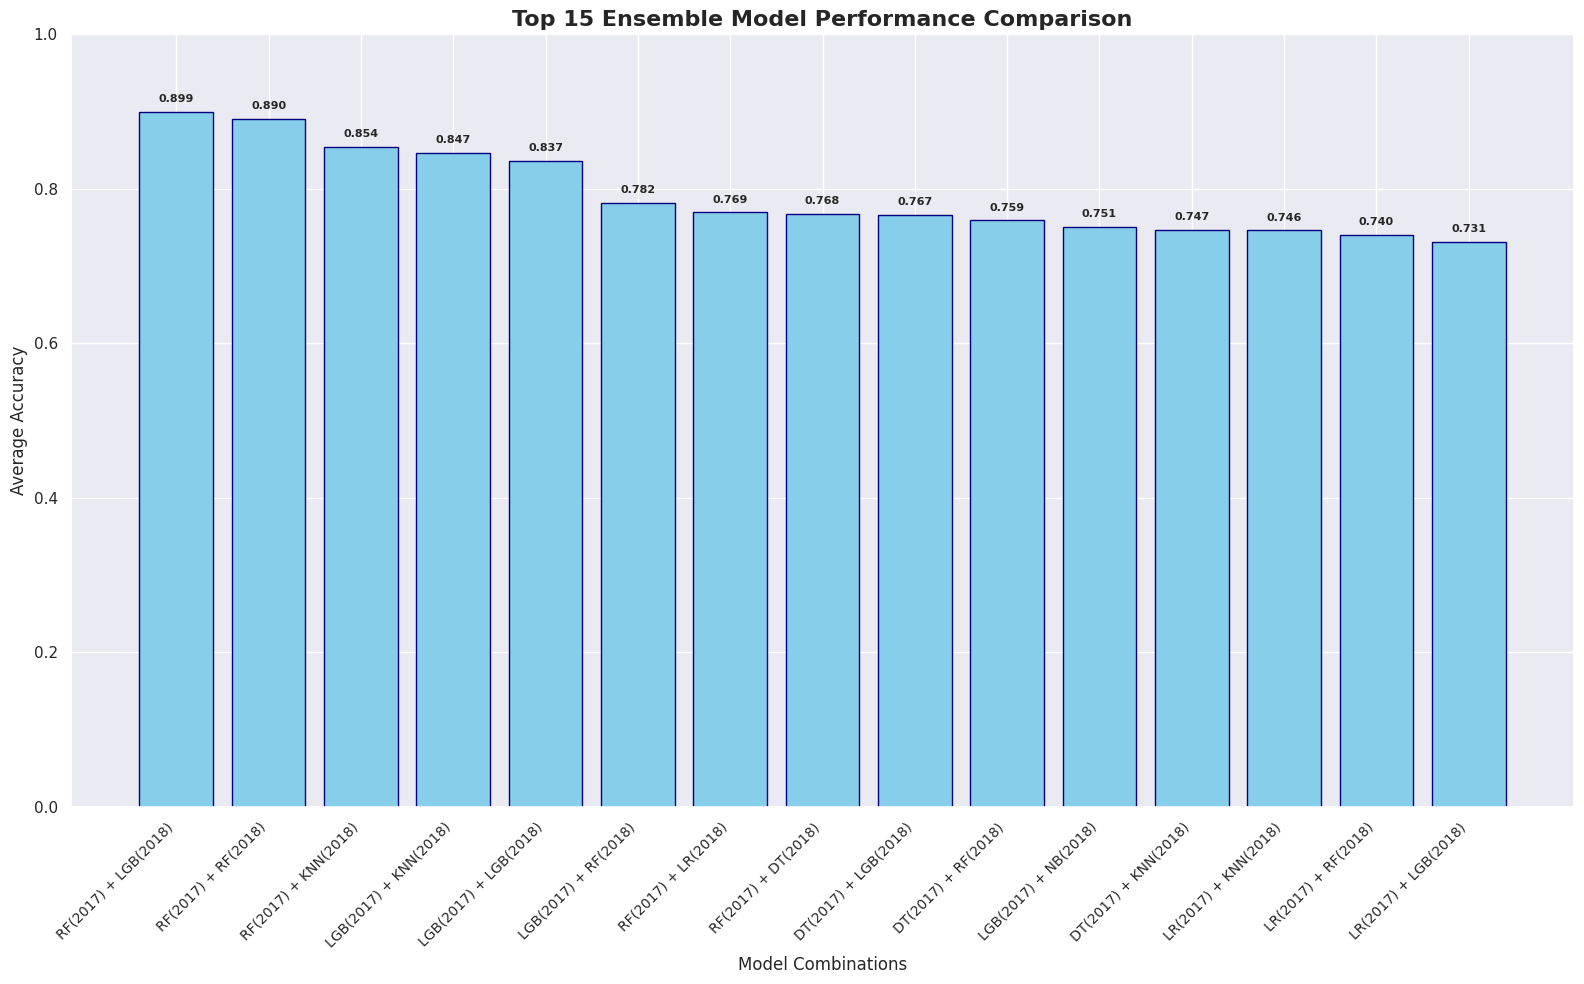

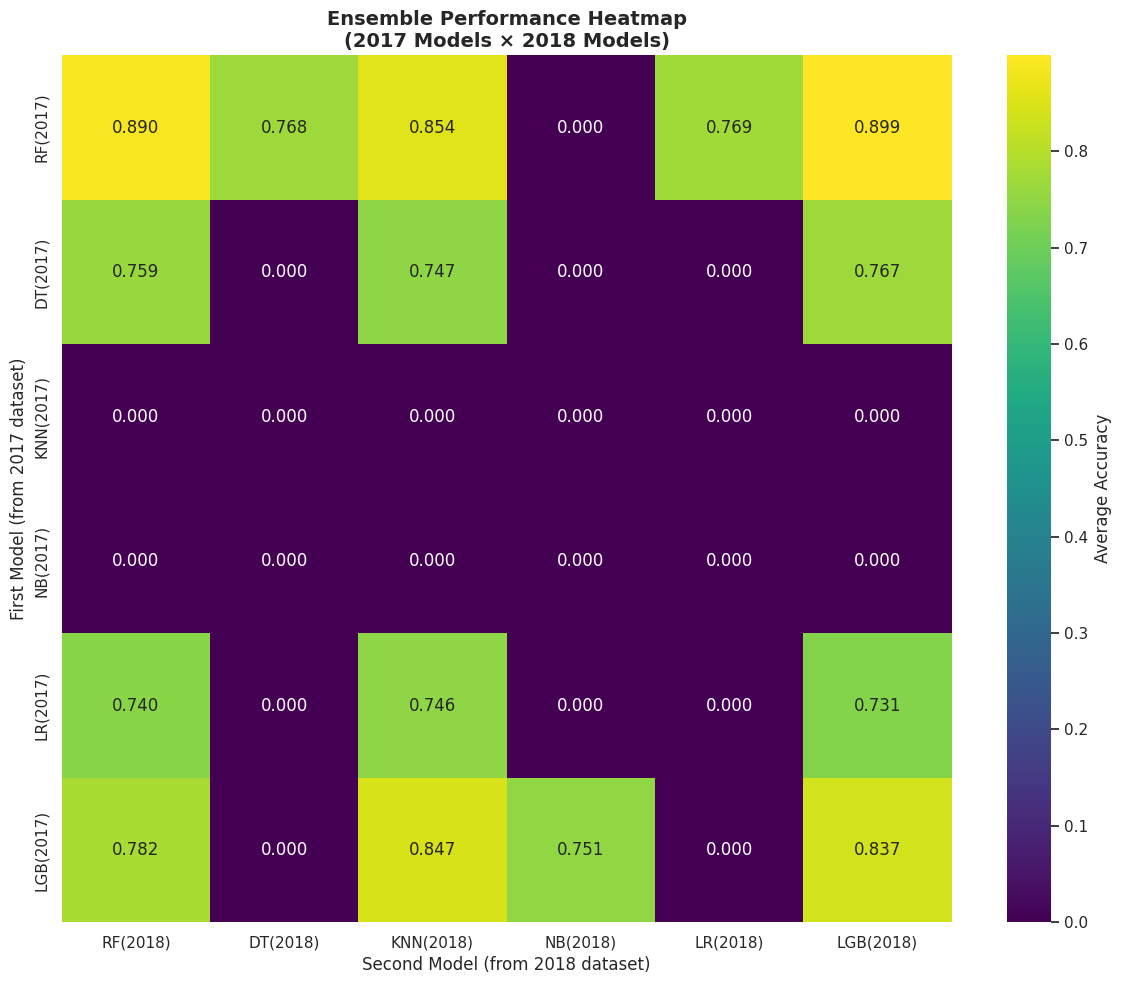


🔄 BEST CROSS-MODEL COMBINATIONS:
    Model_Combination  Avg_Accuracy  Avg_F1_Macro
 RF(2017) + LGB(2018)        0.8995        0.8567
 RF(2017) + KNN(2018)        0.8541        0.8347
LGB(2017) + KNN(2018)        0.8468        0.7554
 LGB(2017) + RF(2018)        0.7819        0.6884
  RF(2017) + LR(2018)        0.7695        0.7427
  RF(2017) + DT(2018)        0.7681        0.7559
 DT(2017) + LGB(2018)        0.7667        0.6126
  DT(2017) + RF(2018)        0.7591        0.6063
 LGB(2017) + NB(2018)        0.7508        0.7113
 DT(2017) + KNN(2018)        0.7473        0.6058

📋 INDIVIDUAL MODEL PERFORMANCE SUMMARY

🏅 TOP INDIVIDUAL MODELS:
    Model  Avg_Accuracy  CICIDS2017_Accuracy  CICIDS2018_Accuracy
 RF(2017)        0.5732               0.9826               0.1639
LGB(2017)        0.5708               0.9978               0.1439
 LR(2017)        0.5638               0.9514               0.1763
KNN(2017)        0.5624               0.9823               0.1425
 DT(2017)        0.5

In [ ]:
def main():
    """Main function to run adaptive ensemble experiments"""
    base_path = '/content/drive/MyDrive/Capstone'

    # Use the enhanced runner
    runner = EnsembleExperimentRunner(base_path)

    if not runner.setup():
        print("❌ Setup failed. Please check your file paths.")
        return

    # Run individual model evaluations
    runner.run_individual_model_evaluations()

    # Run standard ensemble experiments
    runner.run_all_experiments()

    # Run adaptive experiments on top performers
    runner.run_top_adaptive_experiments(top_n=5)

    # Generate comprehensive reports
    standard_summary = runner.generate_summary_report()
    adaptive_summary = runner.generate_adaptive_summary_report()

    return runner, standard_summary, adaptive_summary

# Execute if running as main script
if __name__ == "__main__":
    runner, standard_summary, adaptive_summary = main()